In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b50_k7_b50_k9_b50_k11_b50_k13_b50_k15_b50_k17_b50_k19_b50_k21_b50_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 828)
(657450, 8)
validation
(74368, 828)
(74368, 8)
test
(91684, 828)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:55 - loss: 2.2182 - STD: 0.0532 - MAE: 0.2225

 4/66 [>.............................] - ETA: 2s - loss: 1.6750 - STD: 0.1104 - MAE: 0.1834  

 5/66 [=>............................] - ETA: 2s - loss: 1.6188 - STD: 0.1356 - MAE: 0.1727

 6/66 [=>............................] - ETA: 2s - loss: 1.5785 - STD: 0.1548 - MAE: 0.1643

 7/66 [==>...........................] - ETA: 2s - loss: 1.5517 - STD: 0.1688 - MAE: 0.1583

 8/66 [==>...........................] - ETA: 2s - loss: 1.5311 - STD: 0.1786 - MAE: 0.1542

 9/66 [===>..........................] - ETA: 3s - loss: 1.5111 - STD: 0.1850 - MAE: 0.1513

10/66 [===>..........................] - ETA: 3s - loss: 1.4928 - STD: 0.1884 - MAE: 0.1497

11/66 [====>.........................] - ETA: 3s - loss: 1.4779 - STD: 0.1896 - MAE: 0.1489

12/66 [====>.........................] - ETA: 3s - loss: 1.4645 - STD: 0.1893 - MAE: 0.1488

13/66 [====>.........................] - ETA: 3s - loss: 1.4531 - STD: 0.1881 - MAE: 0.1490

14/66 [=====>........................] - ETA: 3s - loss: 1.4457 - STD: 0.1867 - MAE: 0.1495

15/66 [=====>........................] - ETA: 3s - loss: 1.4392 - STD: 0.1854 - MAE: 0.1500

16/66 [======>.......................] - ETA: 2s - loss: 1.4324 - STD: 0.1844 - MAE: 0.1502

17/66 [======>.......................] - ETA: 2s - loss: 1.4270 - STD: 0.1838 - MAE: 0.1504

18/66 [=======>......................] - ETA: 2s - loss: 1.4216 - STD: 0.1836 - MAE: 0.1504

19/66 [=======>......................] - ETA: 2s - loss: 1.4157 - STD: 0.1839 - MAE: 0.1501

20/66 [========>.....................] - ETA: 2s - loss: 1.4118 - STD: 0.1845 - MAE: 0.1498

21/66 [========>.....................] - ETA: 2s - loss: 1.4080 - STD: 0.1854 - MAE: 0.1494

22/66 [=========>....................] - ETA: 2s - loss: 1.4032 - STD: 0.1864 - MAE: 0.1489

23/66 [=========>....................] - ETA: 2s - loss: 1.3998 - STD: 0.1874 - MAE: 0.1485

24/66 [=========>....................] - ETA: 2s - loss: 1.3959 - STD: 0.1884 - MAE: 0.1480

25/66 [==========>...................] - ETA: 4s - loss: 1.3933 - STD: 0.1893 - MAE: 0.1476

28/66 [===========>..................] - ETA: 3s - loss: 1.3844 - STD: 0.1909 - MAE: 0.1467

30/66 [============>.................] - ETA: 3s - loss: 1.3783 - STD: 0.1911 - MAE: 0.1465

31/66 [=============>................] - ETA: 3s - loss: 1.3759 - STD: 0.1910 - MAE: 0.1465

32/66 [=============>................] - ETA: 3s - loss: 1.3732 - STD: 0.1908 - MAE: 0.1465

33/66 [==============>...............] - ETA: 2s - loss: 1.3709 - STD: 0.1906 - MAE: 0.1465

34/66 [==============>...............] - ETA: 2s - loss: 1.3697 - STD: 0.1904 - MAE: 0.1466

35/66 [==============>...............] - ETA: 2s - loss: 1.3676 - STD: 0.1902 - MAE: 0.1466

36/66 [===============>..............] - ETA: 2s - loss: 1.3663 - STD: 0.1901 - MAE: 0.1467

37/66 [===============>..............] - ETA: 2s - loss: 1.3646 - STD: 0.1901 - MAE: 0.1466

38/66 [================>.............] - ETA: 2s - loss: 1.3635 - STD: 0.1901 - MAE: 0.1466

39/66 [================>.............] - ETA: 2s - loss: 1.3622 - STD: 0.1902 - MAE: 0.1466

40/66 [=================>............] - ETA: 2s - loss: 1.3612 - STD: 0.1903 - MAE: 0.1465

41/66 [=================>............] - ETA: 2s - loss: 1.3599 - STD: 0.1904 - MAE: 0.1465

42/66 [==================>...........] - ETA: 2s - loss: 1.3583 - STD: 0.1906 - MAE: 0.1464

43/66 [==================>...........] - ETA: 1s - loss: 1.3574 - STD: 0.1907 - MAE: 0.1463

44/66 [===================>..........] - ETA: 1s - loss: 1.3565 - STD: 0.1909 - MAE: 0.1462

45/66 [===================>..........] - ETA: 1s - loss: 1.3555 - STD: 0.1910 - MAE: 0.1462

46/66 [===================>..........] - ETA: 1s - loss: 1.3545 - STD: 0.1910 - MAE: 0.1461

47/66 [====================>.........] - ETA: 1s - loss: 1.3535 - STD: 0.1911 - MAE: 0.1461

48/66 [====================>.........] - ETA: 1s - loss: 1.3526 - STD: 0.1911 - MAE: 0.1461

49/66 [=====================>........] - ETA: 1s - loss: 1.3517 - STD: 0.1910 - MAE: 0.1461

50/66 [=====================>........] - ETA: 1s - loss: 1.3506 - STD: 0.1910 - MAE: 0.1461

51/66 [======================>.......] - ETA: 1s - loss: 1.3499 - STD: 0.1909 - MAE: 0.1461

52/66 [======================>.......] - ETA: 1s - loss: 1.3493 - STD: 0.1909 - MAE: 0.1461

53/66 [=======================>......] - ETA: 1s - loss: 1.3487 - STD: 0.1908 - MAE: 0.1462

54/66 [=======================>......] - ETA: 0s - loss: 1.3482 - STD: 0.1908 - MAE: 0.1462

55/66 [========================>.....] - ETA: 0s - loss: 1.3476 - STD: 0.1907 - MAE: 0.1462

56/66 [========================>.....] - ETA: 0s - loss: 1.3469 - STD: 0.1907 - MAE: 0.1462

57/66 [========================>.....] - ETA: 0s - loss: 1.3460 - STD: 0.1907 - MAE: 0.1461

58/66 [=========================>....] - ETA: 0s - loss: 1.3456 - STD: 0.1907 - MAE: 0.1461

59/66 [=========================>....] - ETA: 0s - loss: 1.3453 - STD: 0.1908 - MAE: 0.1461

60/66 [==========================>...] - ETA: 0s - loss: 1.3445 - STD: 0.1908 - MAE: 0.1461

61/66 [==========================>...] - ETA: 0s - loss: 1.3438 - STD: 0.1909 - MAE: 0.1461

62/66 [===========================>..] - ETA: 0s - loss: 1.3434 - STD: 0.1909 - MAE: 0.1460

63/66 [===========================>..] - ETA: 0s - loss: 1.3428 - STD: 0.1909 - MAE: 0.1460

64/66 [============================>.] - ETA: 0s - loss: 1.3425 - STD: 0.1910 - MAE: 0.1460

65/66 [============================>.] - ETA: 0s - loss: 1.3419 - STD: 0.1910 - MAE: 0.1460

66/66 [==============================] - ETA: 0s - loss: 1.3411 - STD: 0.1910 - MAE: 0.1460

66/66 [==============================] - 8s 90ms/step - loss: 1.3411 - STD: 0.1910 - MAE: 0.1460 - val_loss: 1.2448 - val_STD: 0.1915 - val_MAE: 0.1420


Epoch 2/10000


 1/66 [..............................] - ETA: 6s - loss: 1.2755 - STD: 0.1915 - MAE: 0.1435

 2/66 [..............................] - ETA: 4s - loss: 1.2928 - STD: 0.1916 - MAE: 0.1444

 3/66 [>.............................] - ETA: 4s - loss: 1.2934 - STD: 0.1918 - MAE: 0.1443

 4/66 [>.............................] - ETA: 4s - loss: 1.2970 - STD: 0.1920 - MAE: 0.1445

 5/66 [=>............................] - ETA: 4s - loss: 1.2970 - STD: 0.1921 - MAE: 0.1445

 6/66 [=>............................] - ETA: 4s - loss: 1.2980 - STD: 0.1923 - MAE: 0.1444

 7/66 [==>...........................] - ETA: 4s - loss: 1.2958 - STD: 0.1924 - MAE: 0.1442

 8/66 [==>...........................] - ETA: 3s - loss: 1.2978 - STD: 0.1926 - MAE: 0.1443

 9/66 [===>..........................] - ETA: 3s - loss: 1.2977 - STD: 0.1927 - MAE: 0.1442

10/66 [===>..........................] - ETA: 3s - loss: 1.3006 - STD: 0.1929 - MAE: 0.1443

11/66 [====>.........................] - ETA: 3s - loss: 1.3033 - STD: 0.1930 - MAE: 0.1444

12/66 [====>.........................] - ETA: 3s - loss: 1.3048 - STD: 0.1930 - MAE: 0.1445

13/66 [====>.........................] - ETA: 3s - loss: 1.3055 - STD: 0.1929 - MAE: 0.1445

14/66 [=====>........................] - ETA: 3s - loss: 1.3073 - STD: 0.1927 - MAE: 0.1447

15/66 [=====>........................] - ETA: 3s - loss: 1.3071 - STD: 0.1925 - MAE: 0.1447

16/66 [======>.......................] - ETA: 3s - loss: 1.3078 - STD: 0.1923 - MAE: 0.1448

17/66 [======>.......................] - ETA: 3s - loss: 1.3086 - STD: 0.1921 - MAE: 0.1450

18/66 [=======>......................] - ETA: 3s - loss: 1.3087 - STD: 0.1920 - MAE: 0.1450

19/66 [=======>......................] - ETA: 3s - loss: 1.3095 - STD: 0.1918 - MAE: 0.1451

20/66 [========>.....................] - ETA: 3s - loss: 1.3088 - STD: 0.1918 - MAE: 0.1451

21/66 [========>.....................] - ETA: 3s - loss: 1.3095 - STD: 0.1917 - MAE: 0.1452

22/66 [=========>....................] - ETA: 3s - loss: 1.3096 - STD: 0.1917 - MAE: 0.1452

23/66 [=========>....................] - ETA: 2s - loss: 1.3093 - STD: 0.1917 - MAE: 0.1452

24/66 [=========>....................] - ETA: 2s - loss: 1.3093 - STD: 0.1918 - MAE: 0.1451

25/66 [==========>...................] - ETA: 2s - loss: 1.3093 - STD: 0.1918 - MAE: 0.1451

26/66 [==========>...................] - ETA: 2s - loss: 1.3089 - STD: 0.1918 - MAE: 0.1451

27/66 [===========>..................] - ETA: 2s - loss: 1.3090 - STD: 0.1919 - MAE: 0.1451

28/66 [===========>..................] - ETA: 2s - loss: 1.3090 - STD: 0.1919 - MAE: 0.1451

29/66 [============>.................] - ETA: 2s - loss: 1.3091 - STD: 0.1920 - MAE: 0.1451

30/66 [============>.................] - ETA: 2s - loss: 1.3090 - STD: 0.1920 - MAE: 0.1451

31/66 [=============>................] - ETA: 2s - loss: 1.3090 - STD: 0.1920 - MAE: 0.1451

33/66 [==============>...............] - ETA: 2s - loss: 1.3092 - STD: 0.1919 - MAE: 0.1451

34/66 [==============>...............] - ETA: 2s - loss: 1.3090 - STD: 0.1918 - MAE: 0.1451

35/66 [==============>...............] - ETA: 2s - loss: 1.3090 - STD: 0.1918 - MAE: 0.1451

36/66 [===============>..............] - ETA: 2s - loss: 1.3086 - STD: 0.1917 - MAE: 0.1451

37/66 [===============>..............] - ETA: 1s - loss: 1.3084 - STD: 0.1917 - MAE: 0.1451

38/66 [================>.............] - ETA: 1s - loss: 1.3080 - STD: 0.1917 - MAE: 0.1451

39/66 [================>.............] - ETA: 1s - loss: 1.3074 - STD: 0.1918 - MAE: 0.1451

40/66 [=================>............] - ETA: 1s - loss: 1.3066 - STD: 0.1918 - MAE: 0.1450

41/66 [=================>............] - ETA: 1s - loss: 1.3069 - STD: 0.1919 - MAE: 0.1450

42/66 [==================>...........] - ETA: 1s - loss: 1.3066 - STD: 0.1920 - MAE: 0.1449

43/66 [==================>...........] - ETA: 1s - loss: 1.3070 - STD: 0.1921 - MAE: 0.1449

44/66 [===================>..........] - ETA: 1s - loss: 1.3069 - STD: 0.1921 - MAE: 0.1449

45/66 [===================>..........] - ETA: 1s - loss: 1.3069 - STD: 0.1921 - MAE: 0.1449

46/66 [===================>..........] - ETA: 1s - loss: 1.3069 - STD: 0.1921 - MAE: 0.1449

47/66 [====================>.........] - ETA: 1s - loss: 1.3071 - STD: 0.1921 - MAE: 0.1449

48/66 [====================>.........] - ETA: 1s - loss: 1.3069 - STD: 0.1920 - MAE: 0.1449

49/66 [=====================>........] - ETA: 1s - loss: 1.3066 - STD: 0.1920 - MAE: 0.1449

50/66 [=====================>........] - ETA: 1s - loss: 1.3065 - STD: 0.1920 - MAE: 0.1449

51/66 [======================>.......] - ETA: 1s - loss: 1.3060 - STD: 0.1920 - MAE: 0.1449

52/66 [======================>.......] - ETA: 0s - loss: 1.3064 - STD: 0.1920 - MAE: 0.1449

53/66 [=======================>......] - ETA: 0s - loss: 1.3063 - STD: 0.1920 - MAE: 0.1449

54/66 [=======================>......] - ETA: 0s - loss: 1.3058 - STD: 0.1921 - MAE: 0.1449

55/66 [========================>.....] - ETA: 0s - loss: 1.3055 - STD: 0.1921 - MAE: 0.1448

56/66 [========================>.....] - ETA: 0s - loss: 1.3055 - STD: 0.1921 - MAE: 0.1448

57/66 [========================>.....] - ETA: 0s - loss: 1.3051 - STD: 0.1921 - MAE: 0.1448

58/66 [=========================>....] - ETA: 0s - loss: 1.3051 - STD: 0.1921 - MAE: 0.1448

59/66 [=========================>....] - ETA: 0s - loss: 1.3049 - STD: 0.1921 - MAE: 0.1448

60/66 [==========================>...] - ETA: 0s - loss: 1.3048 - STD: 0.1921 - MAE: 0.1448

61/66 [==========================>...] - ETA: 0s - loss: 1.3045 - STD: 0.1921 - MAE: 0.1448

62/66 [===========================>..] - ETA: 0s - loss: 1.3045 - STD: 0.1921 - MAE: 0.1448

63/66 [===========================>..] - ETA: 0s - loss: 1.3042 - STD: 0.1920 - MAE: 0.1448

64/66 [============================>.] - ETA: 0s - loss: 1.3041 - STD: 0.1920 - MAE: 0.1448

65/66 [============================>.] - ETA: 0s - loss: 1.3037 - STD: 0.1920 - MAE: 0.1448

66/66 [==============================] - ETA: 0s - loss: 1.3033 - STD: 0.1920 - MAE: 0.1448

66/66 [==============================] - 5s 72ms/step - loss: 1.3033 - STD: 0.1920 - MAE: 0.1448 - val_loss: 1.2133 - val_STD: 0.1906 - val_MAE: 0.1407


Epoch 3/10000


 1/66 [..............................] - ETA: 6s - loss: 1.2816 - STD: 0.1914 - MAE: 0.1440

 2/66 [..............................] - ETA: 4s - loss: 1.2907 - STD: 0.1921 - MAE: 0.1442

 3/66 [>.............................] - ETA: 4s - loss: 1.2842 - STD: 0.1920 - MAE: 0.1438

 4/66 [>.............................] - ETA: 4s - loss: 1.2815 - STD: 0.1920 - MAE: 0.1437

 5/66 [=>............................] - ETA: 4s - loss: 1.2760 - STD: 0.1925 - MAE: 0.1432

 6/66 [=>............................] - ETA: 4s - loss: 1.2759 - STD: 0.1931 - MAE: 0.1430

 7/66 [==>...........................] - ETA: 3s - loss: 1.2744 - STD: 0.1937 - MAE: 0.1427

 8/66 [==>...........................] - ETA: 3s - loss: 1.2752 - STD: 0.1939 - MAE: 0.1427

 9/66 [===>..........................] - ETA: 3s - loss: 1.2741 - STD: 0.1937 - MAE: 0.1427

10/66 [===>..........................] - ETA: 3s - loss: 1.2738 - STD: 0.1933 - MAE: 0.1428

11/66 [====>.........................] - ETA: 3s - loss: 1.2710 - STD: 0.1931 - MAE: 0.1428

12/66 [====>.........................] - ETA: 3s - loss: 1.2693 - STD: 0.1933 - MAE: 0.1426

13/66 [====>.........................] - ETA: 3s - loss: 1.2669 - STD: 0.1939 - MAE: 0.1423

14/66 [=====>........................] - ETA: 3s - loss: 1.2665 - STD: 0.1946 - MAE: 0.1420

15/66 [=====>........................] - ETA: 3s - loss: 1.2665 - STD: 0.1947 - MAE: 0.1420

16/66 [======>.......................] - ETA: 3s - loss: 1.2658 - STD: 0.1943 - MAE: 0.1421

17/66 [======>.......................] - ETA: 3s - loss: 1.2644 - STD: 0.1940 - MAE: 0.1422

18/66 [=======>......................] - ETA: 3s - loss: 1.2639 - STD: 0.1940 - MAE: 0.1422

19/66 [=======>......................] - ETA: 3s - loss: 1.2626 - STD: 0.1943 - MAE: 0.1420

20/66 [========>.....................] - ETA: 3s - loss: 1.2617 - STD: 0.1948 - MAE: 0.1418

21/66 [========>.....................] - ETA: 2s - loss: 1.2605 - STD: 0.1951 - MAE: 0.1416

22/66 [=========>....................] - ETA: 2s - loss: 1.2598 - STD: 0.1950 - MAE: 0.1416

23/66 [=========>....................] - ETA: 2s - loss: 1.2592 - STD: 0.1947 - MAE: 0.1418

24/66 [=========>....................] - ETA: 2s - loss: 1.2589 - STD: 0.1946 - MAE: 0.1418

25/66 [==========>...................] - ETA: 2s - loss: 1.2571 - STD: 0.1949 - MAE: 0.1416

26/66 [==========>...................] - ETA: 2s - loss: 1.2564 - STD: 0.1953 - MAE: 0.1415

27/66 [===========>..................] - ETA: 2s - loss: 1.2550 - STD: 0.1953 - MAE: 0.1414

28/66 [===========>..................] - ETA: 2s - loss: 1.2544 - STD: 0.1951 - MAE: 0.1415

29/66 [============>.................] - ETA: 2s - loss: 1.2534 - STD: 0.1951 - MAE: 0.1415

30/66 [============>.................] - ETA: 2s - loss: 1.2519 - STD: 0.1954 - MAE: 0.1413

31/66 [=============>................] - ETA: 2s - loss: 1.2509 - STD: 0.1957 - MAE: 0.1412

32/66 [=============>................] - ETA: 2s - loss: 1.2496 - STD: 0.1956 - MAE: 0.1412

33/66 [==============>...............] - ETA: 2s - loss: 1.2484 - STD: 0.1955 - MAE: 0.1412

34/66 [==============>...............] - ETA: 2s - loss: 1.2467 - STD: 0.1958 - MAE: 0.1410

35/66 [==============>...............] - ETA: 2s - loss: 1.2454 - STD: 0.1961 - MAE: 0.1409

36/66 [===============>..............] - ETA: 1s - loss: 1.2443 - STD: 0.1961 - MAE: 0.1408

37/66 [===============>..............] - ETA: 1s - loss: 1.2430 - STD: 0.1961 - MAE: 0.1408

38/66 [================>.............] - ETA: 1s - loss: 1.2415 - STD: 0.1963 - MAE: 0.1407

39/66 [================>.............] - ETA: 1s - loss: 1.2404 - STD: 0.1966 - MAE: 0.1405

40/66 [=================>............] - ETA: 1s - loss: 1.2393 - STD: 0.1967 - MAE: 0.1405

41/66 [=================>............] - ETA: 1s - loss: 1.2385 - STD: 0.1966 - MAE: 0.1405

42/66 [==================>...........] - ETA: 1s - loss: 1.2372 - STD: 0.1968 - MAE: 0.1404

43/66 [==================>...........] - ETA: 1s - loss: 1.2357 - STD: 0.1970 - MAE: 0.1403

44/66 [===================>..........] - ETA: 1s - loss: 1.2343 - STD: 0.1970 - MAE: 0.1402

45/66 [===================>..........] - ETA: 1s - loss: 1.2332 - STD: 0.1970 - MAE: 0.1402

46/66 [===================>..........] - ETA: 1s - loss: 1.2318 - STD: 0.1971 - MAE: 0.1401

47/66 [====================>.........] - ETA: 1s - loss: 1.2310 - STD: 0.1972 - MAE: 0.1401

48/66 [====================>.........] - ETA: 1s - loss: 1.2304 - STD: 0.1973 - MAE: 0.1400

49/66 [=====================>........] - ETA: 1s - loss: 1.2296 - STD: 0.1973 - MAE: 0.1400

51/66 [======================>.......] - ETA: 0s - loss: 1.2274 - STD: 0.1975 - MAE: 0.1399

52/66 [======================>.......] - ETA: 0s - loss: 1.2264 - STD: 0.1976 - MAE: 0.1398

53/66 [=======================>......] - ETA: 0s - loss: 1.2251 - STD: 0.1976 - MAE: 0.1398

54/66 [=======================>......] - ETA: 0s - loss: 1.2240 - STD: 0.1977 - MAE: 0.1397

55/66 [========================>.....] - ETA: 0s - loss: 1.2231 - STD: 0.1978 - MAE: 0.1396

56/66 [========================>.....] - ETA: 0s - loss: 1.2223 - STD: 0.1978 - MAE: 0.1396

57/66 [========================>.....] - ETA: 0s - loss: 1.2216 - STD: 0.1979 - MAE: 0.1396

58/66 [=========================>....] - ETA: 0s - loss: 1.2208 - STD: 0.1980 - MAE: 0.1395

59/66 [=========================>....] - ETA: 0s - loss: 1.2199 - STD: 0.1981 - MAE: 0.1395

60/66 [==========================>...] - ETA: 0s - loss: 1.2193 - STD: 0.1981 - MAE: 0.1395

61/66 [==========================>...] - ETA: 0s - loss: 1.2185 - STD: 0.1981 - MAE: 0.1394

62/66 [===========================>..] - ETA: 0s - loss: 1.2173 - STD: 0.1982 - MAE: 0.1394

63/66 [===========================>..] - ETA: 0s - loss: 1.2164 - STD: 0.1982 - MAE: 0.1394

64/66 [============================>.] - ETA: 0s - loss: 1.2159 - STD: 0.1982 - MAE: 0.1393

65/66 [============================>.] - ETA: 0s - loss: 1.2150 - STD: 0.1982 - MAE: 0.1393

66/66 [==============================] - ETA: 0s - loss: 1.2139 - STD: 0.1983 - MAE: 0.1392

66/66 [==============================] - 5s 68ms/step - loss: 1.2139 - STD: 0.1983 - MAE: 0.1392 - val_loss: 1.0761 - val_STD: 0.1990 - val_MAE: 0.1326


Epoch 4/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1556 - STD: 0.2053 - MAE: 0.1347

 2/66 [..............................] - ETA: 4s - loss: 1.1514 - STD: 0.2014 - MAE: 0.1361

 3/66 [>.............................] - ETA: 3s - loss: 1.1553 - STD: 0.2035 - MAE: 0.1355

 4/66 [>.............................] - ETA: 3s - loss: 1.1560 - STD: 0.2042 - MAE: 0.1353

 5/66 [=>............................] - ETA: 3s - loss: 1.1555 - STD: 0.2032 - MAE: 0.1358

 6/66 [=>............................] - ETA: 3s - loss: 1.1553 - STD: 0.2034 - MAE: 0.1357

 7/66 [==>...........................] - ETA: 3s - loss: 1.1530 - STD: 0.2031 - MAE: 0.1356

 8/66 [==>...........................] - ETA: 3s - loss: 1.1548 - STD: 0.2025 - MAE: 0.1360

 9/66 [===>..........................] - ETA: 3s - loss: 1.1542 - STD: 0.2025 - MAE: 0.1360

10/66 [===>..........................] - ETA: 3s - loss: 1.1520 - STD: 0.2025 - MAE: 0.1359

11/66 [====>.........................] - ETA: 3s - loss: 1.1522 - STD: 0.2025 - MAE: 0.1360

12/66 [====>.........................] - ETA: 3s - loss: 1.1523 - STD: 0.2024 - MAE: 0.1360

13/66 [====>.........................] - ETA: 3s - loss: 1.1511 - STD: 0.2020 - MAE: 0.1361

14/66 [=====>........................] - ETA: 3s - loss: 1.1508 - STD: 0.2022 - MAE: 0.1361

15/66 [=====>........................] - ETA: 3s - loss: 1.1491 - STD: 0.2020 - MAE: 0.1361

16/66 [======>.......................] - ETA: 3s - loss: 1.1470 - STD: 0.2021 - MAE: 0.1359

17/66 [======>.......................] - ETA: 2s - loss: 1.1473 - STD: 0.2024 - MAE: 0.1358

18/66 [=======>......................] - ETA: 2s - loss: 1.1465 - STD: 0.2022 - MAE: 0.1359

19/66 [=======>......................] - ETA: 2s - loss: 1.1456 - STD: 0.2024 - MAE: 0.1357

20/66 [========>.....................] - ETA: 2s - loss: 1.1441 - STD: 0.2026 - MAE: 0.1356

21/66 [========>.....................] - ETA: 2s - loss: 1.1427 - STD: 0.2024 - MAE: 0.1356

22/66 [=========>....................] - ETA: 2s - loss: 1.1410 - STD: 0.2025 - MAE: 0.1355

23/66 [=========>....................] - ETA: 2s - loss: 1.1404 - STD: 0.2026 - MAE: 0.1354

24/66 [=========>....................] - ETA: 2s - loss: 1.1391 - STD: 0.2027 - MAE: 0.1353

25/66 [==========>...................] - ETA: 2s - loss: 1.1381 - STD: 0.2028 - MAE: 0.1352

26/66 [==========>...................] - ETA: 2s - loss: 1.1370 - STD: 0.2028 - MAE: 0.1352

27/66 [===========>..................] - ETA: 2s - loss: 1.1355 - STD: 0.2028 - MAE: 0.1351

28/66 [===========>..................] - ETA: 2s - loss: 1.1341 - STD: 0.2029 - MAE: 0.1350

29/66 [============>.................] - ETA: 2s - loss: 1.1336 - STD: 0.2030 - MAE: 0.1349

30/66 [============>.................] - ETA: 2s - loss: 1.1326 - STD: 0.2028 - MAE: 0.1349

31/66 [=============>................] - ETA: 2s - loss: 1.1313 - STD: 0.2029 - MAE: 0.1348

32/66 [=============>................] - ETA: 2s - loss: 1.1301 - STD: 0.2029 - MAE: 0.1347

33/66 [==============>...............] - ETA: 1s - loss: 1.1287 - STD: 0.2031 - MAE: 0.1346

35/66 [==============>...............] - ETA: 1s - loss: 1.1270 - STD: 0.2031 - MAE: 0.1345

36/66 [===============>..............] - ETA: 1s - loss: 1.1259 - STD: 0.2031 - MAE: 0.1344

37/66 [===============>..............] - ETA: 1s - loss: 1.1244 - STD: 0.2034 - MAE: 0.1342

38/66 [================>.............] - ETA: 1s - loss: 1.1227 - STD: 0.2035 - MAE: 0.1341

39/66 [================>.............] - ETA: 1s - loss: 1.1214 - STD: 0.2036 - MAE: 0.1340

40/66 [=================>............] - ETA: 1s - loss: 1.1201 - STD: 0.2037 - MAE: 0.1338

41/66 [=================>............] - ETA: 1s - loss: 1.1184 - STD: 0.2039 - MAE: 0.1337

42/66 [==================>...........] - ETA: 1s - loss: 1.1169 - STD: 0.2040 - MAE: 0.1335

43/66 [==================>...........] - ETA: 1s - loss: 1.1155 - STD: 0.2041 - MAE: 0.1334

44/66 [===================>..........] - ETA: 1s - loss: 1.1142 - STD: 0.2044 - MAE: 0.1332

45/66 [===================>..........] - ETA: 1s - loss: 1.1132 - STD: 0.2045 - MAE: 0.1331

46/66 [===================>..........] - ETA: 1s - loss: 1.1120 - STD: 0.2045 - MAE: 0.1331

47/66 [====================>.........] - ETA: 1s - loss: 1.1106 - STD: 0.2048 - MAE: 0.1328

48/66 [====================>.........] - ETA: 1s - loss: 1.1094 - STD: 0.2049 - MAE: 0.1327

49/66 [=====================>........] - ETA: 1s - loss: 1.1080 - STD: 0.2050 - MAE: 0.1326

50/66 [=====================>........] - ETA: 0s - loss: 1.1068 - STD: 0.2053 - MAE: 0.1324

51/66 [======================>.......] - ETA: 0s - loss: 1.1055 - STD: 0.2054 - MAE: 0.1323

52/66 [======================>.......] - ETA: 0s - loss: 1.1042 - STD: 0.2056 - MAE: 0.1322

53/66 [=======================>......] - ETA: 0s - loss: 1.1027 - STD: 0.2057 - MAE: 0.1320

54/66 [=======================>......] - ETA: 0s - loss: 1.1014 - STD: 0.2059 - MAE: 0.1319

55/66 [========================>.....] - ETA: 0s - loss: 1.0999 - STD: 0.2061 - MAE: 0.1317

56/66 [========================>.....] - ETA: 0s - loss: 1.0982 - STD: 0.2062 - MAE: 0.1316

57/66 [========================>.....] - ETA: 0s - loss: 1.0972 - STD: 0.2065 - MAE: 0.1314

58/66 [=========================>....] - ETA: 0s - loss: 1.0961 - STD: 0.2065 - MAE: 0.1314

59/66 [=========================>....] - ETA: 0s - loss: 1.0946 - STD: 0.2067 - MAE: 0.1312

60/66 [==========================>...] - ETA: 0s - loss: 1.0932 - STD: 0.2070 - MAE: 0.1310

61/66 [==========================>...] - ETA: 0s - loss: 1.0920 - STD: 0.2071 - MAE: 0.1309

62/66 [===========================>..] - ETA: 0s - loss: 1.0906 - STD: 0.2072 - MAE: 0.1308

63/66 [===========================>..] - ETA: 0s - loss: 1.0893 - STD: 0.2075 - MAE: 0.1306

64/66 [============================>.] - ETA: 0s - loss: 1.0884 - STD: 0.2076 - MAE: 0.1305

65/66 [============================>.] - ETA: 0s - loss: 1.0877 - STD: 0.2076 - MAE: 0.1305

66/66 [==============================] - ETA: 0s - loss: 1.0866 - STD: 0.2078 - MAE: 0.1304

66/66 [==============================] - 4s 62ms/step - loss: 1.0866 - STD: 0.2078 - MAE: 0.1304 - val_loss: 0.9076 - val_STD: 0.2136 - val_MAE: 0.1176


Epoch 5/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0184 - STD: 0.2184 - MAE: 0.1221

 2/66 [..............................] - ETA: 4s - loss: 1.0242 - STD: 0.2217 - MAE: 0.1210

 3/66 [>.............................] - ETA: 3s - loss: 1.0257 - STD: 0.2165 - MAE: 0.1233

 4/66 [>.............................] - ETA: 3s - loss: 1.0293 - STD: 0.2160 - MAE: 0.1237

 5/66 [=>............................] - ETA: 3s - loss: 1.0280 - STD: 0.2184 - MAE: 0.1226

 6/66 [=>............................] - ETA: 3s - loss: 1.0250 - STD: 0.2180 - MAE: 0.1227

 7/66 [==>...........................] - ETA: 3s - loss: 1.0209 - STD: 0.2169 - MAE: 0.1230

 8/66 [==>...........................] - ETA: 3s - loss: 1.0173 - STD: 0.2176 - MAE: 0.1226

 9/66 [===>..........................] - ETA: 3s - loss: 1.0153 - STD: 0.2184 - MAE: 0.1221

10/66 [===>..........................] - ETA: 3s - loss: 1.0133 - STD: 0.2180 - MAE: 0.1222

11/66 [====>.........................] - ETA: 3s - loss: 1.0131 - STD: 0.2176 - MAE: 0.1223

12/66 [====>.........................] - ETA: 3s - loss: 1.0127 - STD: 0.2183 - MAE: 0.1221

13/66 [====>.........................] - ETA: 3s - loss: 1.0111 - STD: 0.2182 - MAE: 0.1220

14/66 [=====>........................] - ETA: 3s - loss: 1.0114 - STD: 0.2180 - MAE: 0.1221

15/66 [=====>........................] - ETA: 3s - loss: 1.0118 - STD: 0.2181 - MAE: 0.1221

16/66 [======>.......................] - ETA: 3s - loss: 1.0108 - STD: 0.2181 - MAE: 0.1221

17/66 [======>.......................] - ETA: 2s - loss: 1.0097 - STD: 0.2182 - MAE: 0.1220

18/66 [=======>......................] - ETA: 2s - loss: 1.0083 - STD: 0.2184 - MAE: 0.1218

19/66 [=======>......................] - ETA: 2s - loss: 1.0077 - STD: 0.2182 - MAE: 0.1219

21/66 [========>.....................] - ETA: 2s - loss: 1.0075 - STD: 0.2183 - MAE: 0.1218

22/66 [=========>....................] - ETA: 2s - loss: 1.0060 - STD: 0.2184 - MAE: 0.1217

23/66 [=========>....................] - ETA: 2s - loss: 1.0056 - STD: 0.2187 - MAE: 0.1216

24/66 [=========>....................] - ETA: 2s - loss: 1.0055 - STD: 0.2186 - MAE: 0.1216

25/66 [==========>...................] - ETA: 2s - loss: 1.0049 - STD: 0.2184 - MAE: 0.1217

26/66 [==========>...................] - ETA: 2s - loss: 1.0046 - STD: 0.2186 - MAE: 0.1216

27/66 [===========>..................] - ETA: 2s - loss: 1.0037 - STD: 0.2187 - MAE: 0.1215

28/66 [===========>..................] - ETA: 2s - loss: 1.0034 - STD: 0.2187 - MAE: 0.1215

29/66 [============>.................] - ETA: 2s - loss: 1.0025 - STD: 0.2186 - MAE: 0.1215

30/66 [============>.................] - ETA: 2s - loss: 1.0022 - STD: 0.2189 - MAE: 0.1214

31/66 [=============>................] - ETA: 2s - loss: 1.0010 - STD: 0.2189 - MAE: 0.1213

32/66 [=============>................] - ETA: 2s - loss: 0.9999 - STD: 0.2188 - MAE: 0.1213

33/66 [==============>...............] - ETA: 1s - loss: 0.9995 - STD: 0.2191 - MAE: 0.1211

34/66 [==============>...............] - ETA: 1s - loss: 0.9986 - STD: 0.2190 - MAE: 0.1212

35/66 [==============>...............] - ETA: 1s - loss: 0.9983 - STD: 0.2191 - MAE: 0.1211

36/66 [===============>..............] - ETA: 1s - loss: 0.9974 - STD: 0.2192 - MAE: 0.1210

37/66 [===============>..............] - ETA: 1s - loss: 0.9969 - STD: 0.2192 - MAE: 0.1210

38/66 [================>.............] - ETA: 1s - loss: 0.9962 - STD: 0.2192 - MAE: 0.1210

39/66 [================>.............] - ETA: 1s - loss: 0.9957 - STD: 0.2194 - MAE: 0.1209

40/66 [=================>............] - ETA: 1s - loss: 0.9952 - STD: 0.2195 - MAE: 0.1208

41/66 [=================>............] - ETA: 1s - loss: 0.9948 - STD: 0.2194 - MAE: 0.1208

42/66 [==================>...........] - ETA: 1s - loss: 0.9940 - STD: 0.2195 - MAE: 0.1207

43/66 [==================>...........] - ETA: 1s - loss: 0.9935 - STD: 0.2197 - MAE: 0.1206

44/66 [===================>..........] - ETA: 1s - loss: 0.9929 - STD: 0.2196 - MAE: 0.1206

45/66 [===================>..........] - ETA: 1s - loss: 0.9923 - STD: 0.2196 - MAE: 0.1206

46/66 [===================>..........] - ETA: 1s - loss: 0.9918 - STD: 0.2198 - MAE: 0.1205

47/66 [====================>.........] - ETA: 1s - loss: 0.9911 - STD: 0.2199 - MAE: 0.1204

48/66 [====================>.........] - ETA: 1s - loss: 0.9905 - STD: 0.2199 - MAE: 0.1204

49/66 [=====================>........] - ETA: 1s - loss: 0.9900 - STD: 0.2200 - MAE: 0.1203

50/66 [=====================>........] - ETA: 0s - loss: 0.9891 - STD: 0.2202 - MAE: 0.1202

51/66 [======================>.......] - ETA: 0s - loss: 0.9886 - STD: 0.2202 - MAE: 0.1202

52/66 [======================>.......] - ETA: 0s - loss: 0.9880 - STD: 0.2202 - MAE: 0.1201

53/66 [=======================>......] - ETA: 0s - loss: 0.9872 - STD: 0.2204 - MAE: 0.1200

54/66 [=======================>......] - ETA: 0s - loss: 0.9868 - STD: 0.2204 - MAE: 0.1200

55/66 [========================>.....] - ETA: 0s - loss: 0.9861 - STD: 0.2203 - MAE: 0.1200

56/66 [========================>.....] - ETA: 0s - loss: 0.9854 - STD: 0.2206 - MAE: 0.1198

57/66 [========================>.....] - ETA: 0s - loss: 0.9849 - STD: 0.2208 - MAE: 0.1197

58/66 [=========================>....] - ETA: 0s - loss: 0.9844 - STD: 0.2206 - MAE: 0.1198

59/66 [=========================>....] - ETA: 0s - loss: 0.9838 - STD: 0.2207 - MAE: 0.1197

60/66 [==========================>...] - ETA: 0s - loss: 0.9835 - STD: 0.2210 - MAE: 0.1196

61/66 [==========================>...] - ETA: 0s - loss: 0.9826 - STD: 0.2210 - MAE: 0.1195

62/66 [===========================>..] - ETA: 0s - loss: 0.9820 - STD: 0.2208 - MAE: 0.1196

63/66 [===========================>..] - ETA: 0s - loss: 0.9818 - STD: 0.2210 - MAE: 0.1195

64/66 [============================>.] - ETA: 0s - loss: 0.9810 - STD: 0.2211 - MAE: 0.1194

65/66 [============================>.] - ETA: 0s - loss: 0.9804 - STD: 0.2211 - MAE: 0.1194

66/66 [==============================] - ETA: 0s - loss: 0.9800 - STD: 0.2211 - MAE: 0.1194

66/66 [==============================] - 4s 63ms/step - loss: 0.9800 - STD: 0.2211 - MAE: 0.1194 - val_loss: 0.8542 - val_STD: 0.2194 - val_MAE: 0.1123


Epoch 6/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9257 - STD: 0.2269 - MAE: 0.1143

 2/66 [..............................] - ETA: 4s - loss: 0.9487 - STD: 0.2273 - MAE: 0.1155

 3/66 [>.............................] - ETA: 4s - loss: 0.9422 - STD: 0.2252 - MAE: 0.1161

 4/66 [>.............................] - ETA: 3s - loss: 0.9429 - STD: 0.2238 - MAE: 0.1168

 5/66 [=>............................] - ETA: 3s - loss: 0.9416 - STD: 0.2246 - MAE: 0.1164

 6/66 [=>............................] - ETA: 3s - loss: 0.9407 - STD: 0.2259 - MAE: 0.1157

 7/66 [==>...........................] - ETA: 3s - loss: 0.9387 - STD: 0.2258 - MAE: 0.1156

 8/66 [==>...........................] - ETA: 3s - loss: 0.9373 - STD: 0.2247 - MAE: 0.1161

 9/66 [===>..........................] - ETA: 3s - loss: 0.9377 - STD: 0.2246 - MAE: 0.1162

10/66 [===>..........................] - ETA: 3s - loss: 0.9368 - STD: 0.2255 - MAE: 0.1157

11/66 [====>.........................] - ETA: 3s - loss: 0.9359 - STD: 0.2254 - MAE: 0.1157

12/66 [====>.........................] - ETA: 3s - loss: 0.9344 - STD: 0.2252 - MAE: 0.1158

13/66 [====>.........................] - ETA: 3s - loss: 0.9339 - STD: 0.2253 - MAE: 0.1157

14/66 [=====>........................] - ETA: 3s - loss: 0.9334 - STD: 0.2254 - MAE: 0.1156

15/66 [=====>........................] - ETA: 3s - loss: 0.9329 - STD: 0.2257 - MAE: 0.1155

16/66 [======>.......................] - ETA: 3s - loss: 0.9328 - STD: 0.2257 - MAE: 0.1155

17/66 [======>.......................] - ETA: 3s - loss: 0.9324 - STD: 0.2255 - MAE: 0.1156

18/66 [=======>......................] - ETA: 2s - loss: 0.9328 - STD: 0.2254 - MAE: 0.1156

19/66 [=======>......................] - ETA: 2s - loss: 0.9332 - STD: 0.2259 - MAE: 0.1154

20/66 [========>.....................] - ETA: 2s - loss: 0.9324 - STD: 0.2258 - MAE: 0.1154

21/66 [========>.....................] - ETA: 2s - loss: 0.9318 - STD: 0.2255 - MAE: 0.1155

22/66 [=========>....................] - ETA: 2s - loss: 0.9313 - STD: 0.2256 - MAE: 0.1155

23/66 [=========>....................] - ETA: 2s - loss: 0.9304 - STD: 0.2259 - MAE: 0.1153

24/66 [=========>....................] - ETA: 2s - loss: 0.9299 - STD: 0.2257 - MAE: 0.1154

25/66 [==========>...................] - ETA: 2s - loss: 0.9289 - STD: 0.2257 - MAE: 0.1154

26/66 [==========>...................] - ETA: 2s - loss: 0.9283 - STD: 0.2258 - MAE: 0.1153

27/66 [===========>..................] - ETA: 2s - loss: 0.9275 - STD: 0.2260 - MAE: 0.1152

28/66 [===========>..................] - ETA: 2s - loss: 0.9270 - STD: 0.2260 - MAE: 0.1152

29/66 [============>.................] - ETA: 2s - loss: 0.9262 - STD: 0.2260 - MAE: 0.1152

30/66 [============>.................] - ETA: 2s - loss: 0.9260 - STD: 0.2260 - MAE: 0.1151

31/66 [=============>................] - ETA: 2s - loss: 0.9259 - STD: 0.2260 - MAE: 0.1152

32/66 [=============>................] - ETA: 2s - loss: 0.9254 - STD: 0.2260 - MAE: 0.1151

33/66 [==============>...............] - ETA: 2s - loss: 0.9249 - STD: 0.2262 - MAE: 0.1150

34/66 [==============>...............] - ETA: 1s - loss: 0.9246 - STD: 0.2261 - MAE: 0.1151

35/66 [==============>...............] - ETA: 1s - loss: 0.9241 - STD: 0.2260 - MAE: 0.1151

36/66 [===============>..............] - ETA: 1s - loss: 0.9237 - STD: 0.2262 - MAE: 0.1150

37/66 [===============>..............] - ETA: 1s - loss: 0.9236 - STD: 0.2262 - MAE: 0.1150

38/66 [================>.............] - ETA: 1s - loss: 0.9235 - STD: 0.2260 - MAE: 0.1151

39/66 [================>.............] - ETA: 1s - loss: 0.9231 - STD: 0.2261 - MAE: 0.1150

40/66 [=================>............] - ETA: 1s - loss: 0.9224 - STD: 0.2262 - MAE: 0.1150

41/66 [=================>............] - ETA: 1s - loss: 0.9217 - STD: 0.2261 - MAE: 0.1150

42/66 [==================>...........] - ETA: 1s - loss: 0.9215 - STD: 0.2262 - MAE: 0.1150

43/66 [==================>...........] - ETA: 1s - loss: 0.9216 - STD: 0.2263 - MAE: 0.1149

44/66 [===================>..........] - ETA: 1s - loss: 0.9213 - STD: 0.2261 - MAE: 0.1150

45/66 [===================>..........] - ETA: 1s - loss: 0.9206 - STD: 0.2261 - MAE: 0.1150

46/66 [===================>..........] - ETA: 1s - loss: 0.9203 - STD: 0.2264 - MAE: 0.1149

47/66 [====================>.........] - ETA: 1s - loss: 0.9195 - STD: 0.2264 - MAE: 0.1148

48/66 [====================>.........] - ETA: 1s - loss: 0.9187 - STD: 0.2262 - MAE: 0.1149

49/66 [=====================>........] - ETA: 1s - loss: 0.9182 - STD: 0.2265 - MAE: 0.1147

50/66 [=====================>........] - ETA: 0s - loss: 0.9176 - STD: 0.2266 - MAE: 0.1147

51/66 [======================>.......] - ETA: 0s - loss: 0.9172 - STD: 0.2264 - MAE: 0.1147

52/66 [======================>.......] - ETA: 0s - loss: 0.9167 - STD: 0.2264 - MAE: 0.1147

53/66 [=======================>......] - ETA: 0s - loss: 0.9165 - STD: 0.2266 - MAE: 0.1146

54/66 [=======================>......] - ETA: 0s - loss: 0.9160 - STD: 0.2266 - MAE: 0.1146

55/66 [========================>.....] - ETA: 0s - loss: 0.9156 - STD: 0.2266 - MAE: 0.1146

56/66 [========================>.....] - ETA: 0s - loss: 0.9154 - STD: 0.2267 - MAE: 0.1146

57/66 [========================>.....] - ETA: 0s - loss: 0.9150 - STD: 0.2267 - MAE: 0.1146

58/66 [=========================>....] - ETA: 0s - loss: 0.9147 - STD: 0.2267 - MAE: 0.1145

59/66 [=========================>....] - ETA: 0s - loss: 0.9143 - STD: 0.2268 - MAE: 0.1145

60/66 [==========================>...] - ETA: 0s - loss: 0.9139 - STD: 0.2268 - MAE: 0.1145

61/66 [==========================>...] - ETA: 0s - loss: 0.9136 - STD: 0.2268 - MAE: 0.1145

63/66 [===========================>..] - ETA: 0s - loss: 0.9130 - STD: 0.2269 - MAE: 0.1144

64/66 [============================>.] - ETA: 0s - loss: 0.9125 - STD: 0.2270 - MAE: 0.1143

65/66 [============================>.] - ETA: 0s - loss: 0.9122 - STD: 0.2269 - MAE: 0.1144

66/66 [==============================] - ETA: 0s - loss: 0.9116 - STD: 0.2270 - MAE: 0.1143

66/66 [==============================] - 4s 64ms/step - loss: 0.9116 - STD: 0.2270 - MAE: 0.1143 - val_loss: 0.8153 - val_STD: 0.2328 - val_MAE: 0.1056


Epoch 7/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8867 - STD: 0.2374 - MAE: 0.1090

 2/66 [..............................] - ETA: 3s - loss: 0.8853 - STD: 0.2305 - MAE: 0.1120

 3/66 [>.............................] - ETA: 3s - loss: 0.8837 - STD: 0.2277 - MAE: 0.1131

 4/66 [>.............................] - ETA: 3s - loss: 0.8820 - STD: 0.2295 - MAE: 0.1122

 5/66 [=>............................] - ETA: 3s - loss: 0.8811 - STD: 0.2302 - MAE: 0.1118

 6/66 [=>............................] - ETA: 3s - loss: 0.8847 - STD: 0.2290 - MAE: 0.1126

 7/66 [==>...........................] - ETA: 3s - loss: 0.8836 - STD: 0.2288 - MAE: 0.1126

 8/66 [==>...........................] - ETA: 3s - loss: 0.8840 - STD: 0.2295 - MAE: 0.1123

 9/66 [===>..........................] - ETA: 3s - loss: 0.8835 - STD: 0.2294 - MAE: 0.1123

10/66 [===>..........................] - ETA: 3s - loss: 0.8815 - STD: 0.2291 - MAE: 0.1124

11/66 [====>.........................] - ETA: 3s - loss: 0.8823 - STD: 0.2294 - MAE: 0.1123

12/66 [====>.........................] - ETA: 3s - loss: 0.8819 - STD: 0.2294 - MAE: 0.1123

13/66 [====>.........................] - ETA: 3s - loss: 0.8812 - STD: 0.2290 - MAE: 0.1124

14/66 [=====>........................] - ETA: 3s - loss: 0.8794 - STD: 0.2290 - MAE: 0.1123

15/66 [=====>........................] - ETA: 3s - loss: 0.8795 - STD: 0.2296 - MAE: 0.1121

16/66 [======>.......................] - ETA: 3s - loss: 0.8794 - STD: 0.2295 - MAE: 0.1121

17/66 [======>.......................] - ETA: 2s - loss: 0.8789 - STD: 0.2291 - MAE: 0.1123

18/66 [=======>......................] - ETA: 2s - loss: 0.8786 - STD: 0.2292 - MAE: 0.1122

19/66 [=======>......................] - ETA: 2s - loss: 0.8785 - STD: 0.2296 - MAE: 0.1121

20/66 [========>.....................] - ETA: 2s - loss: 0.8790 - STD: 0.2294 - MAE: 0.1122

21/66 [========>.....................] - ETA: 2s - loss: 0.8801 - STD: 0.2291 - MAE: 0.1124

22/66 [=========>....................] - ETA: 2s - loss: 0.8797 - STD: 0.2292 - MAE: 0.1123

23/66 [=========>....................] - ETA: 2s - loss: 0.8787 - STD: 0.2292 - MAE: 0.1123

24/66 [=========>....................] - ETA: 2s - loss: 0.8786 - STD: 0.2292 - MAE: 0.1122

25/66 [==========>...................] - ETA: 2s - loss: 0.8787 - STD: 0.2295 - MAE: 0.1121

26/66 [==========>...................] - ETA: 2s - loss: 0.8781 - STD: 0.2294 - MAE: 0.1121

27/66 [===========>..................] - ETA: 2s - loss: 0.8785 - STD: 0.2291 - MAE: 0.1123

28/66 [===========>..................] - ETA: 2s - loss: 0.8781 - STD: 0.2293 - MAE: 0.1122

30/66 [============>.................] - ETA: 2s - loss: 0.8766 - STD: 0.2297 - MAE: 0.1119

31/66 [=============>................] - ETA: 2s - loss: 0.8761 - STD: 0.2295 - MAE: 0.1120

32/66 [=============>................] - ETA: 2s - loss: 0.8767 - STD: 0.2295 - MAE: 0.1120

33/66 [==============>...............] - ETA: 1s - loss: 0.8768 - STD: 0.2297 - MAE: 0.1119

34/66 [==============>...............] - ETA: 1s - loss: 0.8758 - STD: 0.2296 - MAE: 0.1119

35/66 [==============>...............] - ETA: 1s - loss: 0.8754 - STD: 0.2297 - MAE: 0.1119

36/66 [===============>..............] - ETA: 1s - loss: 0.8753 - STD: 0.2297 - MAE: 0.1119

37/66 [===============>..............] - ETA: 1s - loss: 0.8749 - STD: 0.2296 - MAE: 0.1119

38/66 [================>.............] - ETA: 1s - loss: 0.8745 - STD: 0.2297 - MAE: 0.1118

39/66 [================>.............] - ETA: 1s - loss: 0.8744 - STD: 0.2297 - MAE: 0.1118

40/66 [=================>............] - ETA: 1s - loss: 0.8742 - STD: 0.2297 - MAE: 0.1118

41/66 [=================>............] - ETA: 1s - loss: 0.8738 - STD: 0.2297 - MAE: 0.1118

42/66 [==================>...........] - ETA: 1s - loss: 0.8736 - STD: 0.2298 - MAE: 0.1118

43/66 [==================>...........] - ETA: 1s - loss: 0.8731 - STD: 0.2298 - MAE: 0.1118

44/66 [===================>..........] - ETA: 1s - loss: 0.8731 - STD: 0.2299 - MAE: 0.1117

45/66 [===================>..........] - ETA: 1s - loss: 0.8729 - STD: 0.2298 - MAE: 0.1118

46/66 [===================>..........] - ETA: 1s - loss: 0.8726 - STD: 0.2299 - MAE: 0.1117

47/66 [====================>.........] - ETA: 1s - loss: 0.8722 - STD: 0.2300 - MAE: 0.1116

48/66 [====================>.........] - ETA: 1s - loss: 0.8719 - STD: 0.2299 - MAE: 0.1117

49/66 [=====================>........] - ETA: 1s - loss: 0.8717 - STD: 0.2300 - MAE: 0.1116

50/66 [=====================>........] - ETA: 0s - loss: 0.8718 - STD: 0.2300 - MAE: 0.1116

51/66 [======================>.......] - ETA: 0s - loss: 0.8714 - STD: 0.2300 - MAE: 0.1116

52/66 [======================>.......] - ETA: 0s - loss: 0.8711 - STD: 0.2300 - MAE: 0.1116

53/66 [=======================>......] - ETA: 0s - loss: 0.8708 - STD: 0.2301 - MAE: 0.1115

54/66 [=======================>......] - ETA: 0s - loss: 0.8708 - STD: 0.2301 - MAE: 0.1115

55/66 [========================>.....] - ETA: 0s - loss: 0.8705 - STD: 0.2301 - MAE: 0.1115

56/66 [========================>.....] - ETA: 0s - loss: 0.8702 - STD: 0.2302 - MAE: 0.1115

57/66 [========================>.....] - ETA: 0s - loss: 0.8701 - STD: 0.2302 - MAE: 0.1114

58/66 [=========================>....] - ETA: 0s - loss: 0.8700 - STD: 0.2301 - MAE: 0.1115

59/66 [=========================>....] - ETA: 0s - loss: 0.8695 - STD: 0.2303 - MAE: 0.1114

60/66 [==========================>...] - ETA: 0s - loss: 0.8690 - STD: 0.2304 - MAE: 0.1113

61/66 [==========================>...] - ETA: 0s - loss: 0.8688 - STD: 0.2303 - MAE: 0.1114

62/66 [===========================>..] - ETA: 0s - loss: 0.8688 - STD: 0.2303 - MAE: 0.1113

63/66 [===========================>..] - ETA: 0s - loss: 0.8683 - STD: 0.2304 - MAE: 0.1113

64/66 [============================>.] - ETA: 0s - loss: 0.8681 - STD: 0.2304 - MAE: 0.1113

65/66 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2304 - MAE: 0.1113

66/66 [==============================] - ETA: 0s - loss: 0.8677 - STD: 0.2304 - MAE: 0.1112

66/66 [==============================] - 4s 63ms/step - loss: 0.8677 - STD: 0.2304 - MAE: 0.1112 - val_loss: 0.7960 - val_STD: 0.2261 - val_MAE: 0.1079


Epoch 8/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8511 - STD: 0.2306 - MAE: 0.1105

 2/66 [..............................] - ETA: 3s - loss: 0.8468 - STD: 0.2324 - MAE: 0.1094

 3/66 [>.............................] - ETA: 3s - loss: 0.8467 - STD: 0.2329 - MAE: 0.1091

 4/66 [>.............................] - ETA: 3s - loss: 0.8463 - STD: 0.2325 - MAE: 0.1092

 5/66 [=>............................] - ETA: 3s - loss: 0.8479 - STD: 0.2325 - MAE: 0.1093

 6/66 [=>............................] - ETA: 3s - loss: 0.8456 - STD: 0.2328 - MAE: 0.1091

 7/66 [==>...........................] - ETA: 3s - loss: 0.8461 - STD: 0.2324 - MAE: 0.1093

 8/66 [==>...........................] - ETA: 3s - loss: 0.8483 - STD: 0.2322 - MAE: 0.1095

 9/66 [===>..........................] - ETA: 3s - loss: 0.8497 - STD: 0.2322 - MAE: 0.1096

10/66 [===>..........................] - ETA: 3s - loss: 0.8493 - STD: 0.2324 - MAE: 0.1095

11/66 [====>.........................] - ETA: 3s - loss: 0.8495 - STD: 0.2324 - MAE: 0.1096

12/66 [====>.........................] - ETA: 3s - loss: 0.8504 - STD: 0.2324 - MAE: 0.1097

13/66 [====>.........................] - ETA: 3s - loss: 0.8518 - STD: 0.2321 - MAE: 0.1098

14/66 [=====>........................] - ETA: 3s - loss: 0.8514 - STD: 0.2326 - MAE: 0.1096

15/66 [=====>........................] - ETA: 3s - loss: 0.8518 - STD: 0.2324 - MAE: 0.1097

16/66 [======>.......................] - ETA: 2s - loss: 0.8532 - STD: 0.2323 - MAE: 0.1098

17/66 [======>.......................] - ETA: 2s - loss: 0.8534 - STD: 0.2329 - MAE: 0.1095

18/66 [=======>......................] - ETA: 2s - loss: 0.8539 - STD: 0.2327 - MAE: 0.1097

19/66 [=======>......................] - ETA: 2s - loss: 0.8540 - STD: 0.2322 - MAE: 0.1099

20/66 [========>.....................] - ETA: 2s - loss: 0.8549 - STD: 0.2328 - MAE: 0.1097

21/66 [========>.....................] - ETA: 2s - loss: 0.8543 - STD: 0.2328 - MAE: 0.1096

22/66 [=========>....................] - ETA: 2s - loss: 0.8551 - STD: 0.2323 - MAE: 0.1099

23/66 [=========>....................] - ETA: 2s - loss: 0.8547 - STD: 0.2324 - MAE: 0.1099

24/66 [=========>....................] - ETA: 2s - loss: 0.8551 - STD: 0.2327 - MAE: 0.1098

25/66 [==========>...................] - ETA: 2s - loss: 0.8542 - STD: 0.2324 - MAE: 0.1099

26/66 [==========>...................] - ETA: 2s - loss: 0.8538 - STD: 0.2323 - MAE: 0.1099

27/66 [===========>..................] - ETA: 2s - loss: 0.8538 - STD: 0.2326 - MAE: 0.1098

28/66 [===========>..................] - ETA: 2s - loss: 0.8533 - STD: 0.2326 - MAE: 0.1097

29/66 [============>.................] - ETA: 2s - loss: 0.8530 - STD: 0.2324 - MAE: 0.1098

30/66 [============>.................] - ETA: 2s - loss: 0.8524 - STD: 0.2323 - MAE: 0.1098

31/66 [=============>................] - ETA: 2s - loss: 0.8520 - STD: 0.2324 - MAE: 0.1097

32/66 [=============>................] - ETA: 2s - loss: 0.8517 - STD: 0.2325 - MAE: 0.1097

33/66 [==============>...............] - ETA: 1s - loss: 0.8513 - STD: 0.2324 - MAE: 0.1097

34/66 [==============>...............] - ETA: 1s - loss: 0.8511 - STD: 0.2323 - MAE: 0.1097

35/66 [==============>...............] - ETA: 1s - loss: 0.8509 - STD: 0.2325 - MAE: 0.1097

36/66 [===============>..............] - ETA: 1s - loss: 0.8502 - STD: 0.2326 - MAE: 0.1096

37/66 [===============>..............] - ETA: 1s - loss: 0.8496 - STD: 0.2325 - MAE: 0.1096

38/66 [================>.............] - ETA: 1s - loss: 0.8499 - STD: 0.2325 - MAE: 0.1096

39/66 [================>.............] - ETA: 1s - loss: 0.8495 - STD: 0.2326 - MAE: 0.1095

40/66 [=================>............] - ETA: 1s - loss: 0.8490 - STD: 0.2326 - MAE: 0.1095

41/66 [=================>............] - ETA: 1s - loss: 0.8492 - STD: 0.2326 - MAE: 0.1095

42/66 [==================>...........] - ETA: 1s - loss: 0.8492 - STD: 0.2326 - MAE: 0.1095

43/66 [==================>...........] - ETA: 1s - loss: 0.8490 - STD: 0.2326 - MAE: 0.1095

44/66 [===================>..........] - ETA: 1s - loss: 0.8487 - STD: 0.2326 - MAE: 0.1095

45/66 [===================>..........] - ETA: 1s - loss: 0.8482 - STD: 0.2326 - MAE: 0.1095

46/66 [===================>..........] - ETA: 1s - loss: 0.8478 - STD: 0.2327 - MAE: 0.1094

48/66 [====================>.........] - ETA: 1s - loss: 0.8475 - STD: 0.2326 - MAE: 0.1094

49/66 [=====================>........] - ETA: 1s - loss: 0.8470 - STD: 0.2327 - MAE: 0.1094

50/66 [=====================>........] - ETA: 0s - loss: 0.8469 - STD: 0.2328 - MAE: 0.1093

51/66 [======================>.......] - ETA: 0s - loss: 0.8469 - STD: 0.2327 - MAE: 0.1093

52/66 [======================>.......] - ETA: 0s - loss: 0.8467 - STD: 0.2327 - MAE: 0.1094

53/66 [=======================>......] - ETA: 0s - loss: 0.8466 - STD: 0.2328 - MAE: 0.1093

54/66 [=======================>......] - ETA: 0s - loss: 0.8465 - STD: 0.2328 - MAE: 0.1093

55/66 [========================>.....] - ETA: 0s - loss: 0.8466 - STD: 0.2327 - MAE: 0.1094

56/66 [========================>.....] - ETA: 0s - loss: 0.8468 - STD: 0.2328 - MAE: 0.1093

57/66 [========================>.....] - ETA: 0s - loss: 0.8465 - STD: 0.2328 - MAE: 0.1093

58/66 [=========================>....] - ETA: 0s - loss: 0.8464 - STD: 0.2328 - MAE: 0.1093

59/66 [=========================>....] - ETA: 0s - loss: 0.8460 - STD: 0.2328 - MAE: 0.1093

60/66 [==========================>...] - ETA: 0s - loss: 0.8457 - STD: 0.2329 - MAE: 0.1092

61/66 [==========================>...] - ETA: 0s - loss: 0.8455 - STD: 0.2328 - MAE: 0.1093

62/66 [===========================>..] - ETA: 0s - loss: 0.8452 - STD: 0.2328 - MAE: 0.1092

63/66 [===========================>..] - ETA: 0s - loss: 0.8451 - STD: 0.2329 - MAE: 0.1092

64/66 [============================>.] - ETA: 0s - loss: 0.8448 - STD: 0.2329 - MAE: 0.1092

65/66 [============================>.] - ETA: 0s - loss: 0.8445 - STD: 0.2329 - MAE: 0.1092

66/66 [==============================] - ETA: 0s - loss: 0.8443 - STD: 0.2329 - MAE: 0.1092

66/66 [==============================] - 4s 63ms/step - loss: 0.8443 - STD: 0.2329 - MAE: 0.1092 - val_loss: 0.7818 - val_STD: 0.2320 - val_MAE: 0.1048


Epoch 9/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8285 - STD: 0.2361 - MAE: 0.1071

 2/66 [..............................] - ETA: 3s - loss: 0.8362 - STD: 0.2338 - MAE: 0.1086

 3/66 [>.............................] - ETA: 4s - loss: 0.8338 - STD: 0.2343 - MAE: 0.1082

 4/66 [>.............................] - ETA: 3s - loss: 0.8349 - STD: 0.2341 - MAE: 0.1082

 5/66 [=>............................] - ETA: 3s - loss: 0.8345 - STD: 0.2340 - MAE: 0.1083

 6/66 [=>............................] - ETA: 3s - loss: 0.8334 - STD: 0.2342 - MAE: 0.1080

 7/66 [==>...........................] - ETA: 3s - loss: 0.8321 - STD: 0.2343 - MAE: 0.1080

 8/66 [==>...........................] - ETA: 3s - loss: 0.8315 - STD: 0.2346 - MAE: 0.1078

 9/66 [===>..........................] - ETA: 3s - loss: 0.8312 - STD: 0.2341 - MAE: 0.1080

10/66 [===>..........................] - ETA: 3s - loss: 0.8306 - STD: 0.2347 - MAE: 0.1077

11/66 [====>.........................] - ETA: 3s - loss: 0.8308 - STD: 0.2346 - MAE: 0.1077

12/66 [====>.........................] - ETA: 3s - loss: 0.8304 - STD: 0.2346 - MAE: 0.1077

13/66 [====>.........................] - ETA: 3s - loss: 0.8306 - STD: 0.2345 - MAE: 0.1078

14/66 [=====>........................] - ETA: 3s - loss: 0.8311 - STD: 0.2345 - MAE: 0.1078

15/66 [=====>........................] - ETA: 3s - loss: 0.8309 - STD: 0.2346 - MAE: 0.1077

16/66 [======>.......................] - ETA: 3s - loss: 0.8307 - STD: 0.2345 - MAE: 0.1078

17/66 [======>.......................] - ETA: 2s - loss: 0.8297 - STD: 0.2344 - MAE: 0.1078

18/66 [=======>......................] - ETA: 2s - loss: 0.8300 - STD: 0.2344 - MAE: 0.1078

19/66 [=======>......................] - ETA: 2s - loss: 0.8302 - STD: 0.2347 - MAE: 0.1077

20/66 [========>.....................] - ETA: 2s - loss: 0.8292 - STD: 0.2344 - MAE: 0.1078

22/66 [=========>....................] - ETA: 2s - loss: 0.8297 - STD: 0.2345 - MAE: 0.1077

23/66 [=========>....................] - ETA: 2s - loss: 0.8300 - STD: 0.2347 - MAE: 0.1077

24/66 [=========>....................] - ETA: 2s - loss: 0.8300 - STD: 0.2346 - MAE: 0.1077

25/66 [==========>...................] - ETA: 2s - loss: 0.8308 - STD: 0.2345 - MAE: 0.1078

26/66 [==========>...................] - ETA: 2s - loss: 0.8309 - STD: 0.2345 - MAE: 0.1078

27/66 [===========>..................] - ETA: 2s - loss: 0.8312 - STD: 0.2344 - MAE: 0.1079

28/66 [===========>..................] - ETA: 2s - loss: 0.8319 - STD: 0.2347 - MAE: 0.1078

29/66 [============>.................] - ETA: 2s - loss: 0.8318 - STD: 0.2345 - MAE: 0.1079

30/66 [============>.................] - ETA: 2s - loss: 0.8316 - STD: 0.2345 - MAE: 0.1079

31/66 [=============>................] - ETA: 2s - loss: 0.8318 - STD: 0.2346 - MAE: 0.1078

32/66 [=============>................] - ETA: 2s - loss: 0.8323 - STD: 0.2345 - MAE: 0.1079

33/66 [==============>...............] - ETA: 1s - loss: 0.8327 - STD: 0.2347 - MAE: 0.1078

34/66 [==============>...............] - ETA: 1s - loss: 0.8331 - STD: 0.2348 - MAE: 0.1078

35/66 [==============>...............] - ETA: 1s - loss: 0.8332 - STD: 0.2344 - MAE: 0.1080

36/66 [===============>..............] - ETA: 1s - loss: 0.8334 - STD: 0.2344 - MAE: 0.1080

37/66 [===============>..............] - ETA: 1s - loss: 0.8331 - STD: 0.2347 - MAE: 0.1078

38/66 [================>.............] - ETA: 1s - loss: 0.8329 - STD: 0.2347 - MAE: 0.1079

39/66 [================>.............] - ETA: 1s - loss: 0.8329 - STD: 0.2347 - MAE: 0.1078

40/66 [=================>............] - ETA: 1s - loss: 0.8330 - STD: 0.2346 - MAE: 0.1079

41/66 [=================>............] - ETA: 1s - loss: 0.8329 - STD: 0.2345 - MAE: 0.1079

42/66 [==================>...........] - ETA: 1s - loss: 0.8330 - STD: 0.2346 - MAE: 0.1079

43/66 [==================>...........] - ETA: 1s - loss: 0.8323 - STD: 0.2346 - MAE: 0.1079

44/66 [===================>..........] - ETA: 1s - loss: 0.8320 - STD: 0.2347 - MAE: 0.1078

45/66 [===================>..........] - ETA: 1s - loss: 0.8316 - STD: 0.2347 - MAE: 0.1078

46/66 [===================>..........] - ETA: 1s - loss: 0.8319 - STD: 0.2346 - MAE: 0.1079

47/66 [====================>.........] - ETA: 1s - loss: 0.8317 - STD: 0.2346 - MAE: 0.1079

48/66 [====================>.........] - ETA: 1s - loss: 0.8313 - STD: 0.2346 - MAE: 0.1078

49/66 [=====================>........] - ETA: 1s - loss: 0.8311 - STD: 0.2347 - MAE: 0.1078

50/66 [=====================>........] - ETA: 0s - loss: 0.8306 - STD: 0.2347 - MAE: 0.1077

51/66 [======================>.......] - ETA: 0s - loss: 0.8306 - STD: 0.2347 - MAE: 0.1078

52/66 [======================>.......] - ETA: 0s - loss: 0.8302 - STD: 0.2347 - MAE: 0.1077

53/66 [=======================>......] - ETA: 0s - loss: 0.8299 - STD: 0.2347 - MAE: 0.1077

54/66 [=======================>......] - ETA: 0s - loss: 0.8296 - STD: 0.2348 - MAE: 0.1077

55/66 [========================>.....] - ETA: 0s - loss: 0.8293 - STD: 0.2347 - MAE: 0.1077

56/66 [========================>.....] - ETA: 0s - loss: 0.8290 - STD: 0.2348 - MAE: 0.1076

57/66 [========================>.....] - ETA: 0s - loss: 0.8286 - STD: 0.2348 - MAE: 0.1076

58/66 [=========================>....] - ETA: 0s - loss: 0.8284 - STD: 0.2348 - MAE: 0.1076

59/66 [=========================>....] - ETA: 0s - loss: 0.8284 - STD: 0.2348 - MAE: 0.1076

60/66 [==========================>...] - ETA: 0s - loss: 0.8283 - STD: 0.2349 - MAE: 0.1076

61/66 [==========================>...] - ETA: 0s - loss: 0.8278 - STD: 0.2349 - MAE: 0.1075

62/66 [===========================>..] - ETA: 0s - loss: 0.8277 - STD: 0.2349 - MAE: 0.1075

63/66 [===========================>..] - ETA: 0s - loss: 0.8279 - STD: 0.2348 - MAE: 0.1076

64/66 [============================>.] - ETA: 0s - loss: 0.8276 - STD: 0.2349 - MAE: 0.1076

65/66 [============================>.] - ETA: 0s - loss: 0.8275 - STD: 0.2349 - MAE: 0.1075

66/66 [==============================] - ETA: 0s - loss: 0.8272 - STD: 0.2349 - MAE: 0.1075

66/66 [==============================] - 4s 64ms/step - loss: 0.8272 - STD: 0.2349 - MAE: 0.1075 - val_loss: 0.7690 - val_STD: 0.2345 - val_MAE: 0.1032


Epoch 10/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8046 - STD: 0.2385 - MAE: 0.1046

 2/66 [..............................] - ETA: 4s - loss: 0.8033 - STD: 0.2379 - MAE: 0.1049

 3/66 [>.............................] - ETA: 4s - loss: 0.8097 - STD: 0.2368 - MAE: 0.1057

 4/66 [>.............................] - ETA: 4s - loss: 0.8127 - STD: 0.2378 - MAE: 0.1055

 5/66 [=>............................] - ETA: 4s - loss: 0.8125 - STD: 0.2367 - MAE: 0.1060

 6/66 [=>............................] - ETA: 4s - loss: 0.8136 - STD: 0.2363 - MAE: 0.1063

 7/66 [==>...........................] - ETA: 4s - loss: 0.8169 - STD: 0.2360 - MAE: 0.1066

 8/66 [==>...........................] - ETA: 4s - loss: 0.8169 - STD: 0.2368 - MAE: 0.1062

 9/66 [===>..........................] - ETA: 3s - loss: 0.8165 - STD: 0.2365 - MAE: 0.1063

10/66 [===>..........................] - ETA: 3s - loss: 0.8145 - STD: 0.2361 - MAE: 0.1064

11/66 [====>.........................] - ETA: 3s - loss: 0.8147 - STD: 0.2362 - MAE: 0.1064

12/66 [====>.........................] - ETA: 3s - loss: 0.8153 - STD: 0.2361 - MAE: 0.1064

13/66 [====>.........................] - ETA: 3s - loss: 0.8149 - STD: 0.2363 - MAE: 0.1063

14/66 [=====>........................] - ETA: 3s - loss: 0.8150 - STD: 0.2363 - MAE: 0.1063

15/66 [=====>........................] - ETA: 3s - loss: 0.8156 - STD: 0.2362 - MAE: 0.1064

16/66 [======>.......................] - ETA: 3s - loss: 0.8156 - STD: 0.2358 - MAE: 0.1066

17/66 [======>.......................] - ETA: 3s - loss: 0.8159 - STD: 0.2363 - MAE: 0.1064

18/66 [=======>......................] - ETA: 3s - loss: 0.8160 - STD: 0.2364 - MAE: 0.1063

19/66 [=======>......................] - ETA: 3s - loss: 0.8155 - STD: 0.2361 - MAE: 0.1065

20/66 [========>.....................] - ETA: 3s - loss: 0.8148 - STD: 0.2362 - MAE: 0.1064

21/66 [========>.....................] - ETA: 3s - loss: 0.8152 - STD: 0.2362 - MAE: 0.1064

22/66 [=========>....................] - ETA: 3s - loss: 0.8149 - STD: 0.2362 - MAE: 0.1064

23/66 [=========>....................] - ETA: 3s - loss: 0.8153 - STD: 0.2362 - MAE: 0.1064

24/66 [=========>....................] - ETA: 2s - loss: 0.8151 - STD: 0.2362 - MAE: 0.1064

25/66 [==========>...................] - ETA: 2s - loss: 0.8163 - STD: 0.2361 - MAE: 0.1065

26/66 [==========>...................] - ETA: 2s - loss: 0.8179 - STD: 0.2358 - MAE: 0.1067

27/66 [===========>..................] - ETA: 2s - loss: 0.8188 - STD: 0.2363 - MAE: 0.1065

28/66 [===========>..................] - ETA: 2s - loss: 0.8188 - STD: 0.2363 - MAE: 0.1065

29/66 [============>.................] - ETA: 2s - loss: 0.8202 - STD: 0.2359 - MAE: 0.1068

30/66 [============>.................] - ETA: 2s - loss: 0.8219 - STD: 0.2361 - MAE: 0.1068

31/66 [=============>................] - ETA: 2s - loss: 0.8221 - STD: 0.2362 - MAE: 0.1067

32/66 [=============>................] - ETA: 2s - loss: 0.8226 - STD: 0.2360 - MAE: 0.1068

33/66 [==============>...............] - ETA: 2s - loss: 0.8225 - STD: 0.2363 - MAE: 0.1067

34/66 [==============>...............] - ETA: 2s - loss: 0.8217 - STD: 0.2364 - MAE: 0.1066

35/66 [==============>...............] - ETA: 2s - loss: 0.8217 - STD: 0.2362 - MAE: 0.1067

36/66 [===============>..............] - ETA: 2s - loss: 0.8219 - STD: 0.2361 - MAE: 0.1068

37/66 [===============>..............] - ETA: 1s - loss: 0.8222 - STD: 0.2363 - MAE: 0.1067

38/66 [================>.............] - ETA: 1s - loss: 0.8221 - STD: 0.2362 - MAE: 0.1067

39/66 [================>.............] - ETA: 1s - loss: 0.8219 - STD: 0.2361 - MAE: 0.1068

40/66 [=================>............] - ETA: 1s - loss: 0.8220 - STD: 0.2362 - MAE: 0.1067

41/66 [=================>............] - ETA: 1s - loss: 0.8213 - STD: 0.2363 - MAE: 0.1067

42/66 [==================>...........] - ETA: 1s - loss: 0.8212 - STD: 0.2362 - MAE: 0.1067

43/66 [==================>...........] - ETA: 1s - loss: 0.8209 - STD: 0.2362 - MAE: 0.1067

44/66 [===================>..........] - ETA: 1s - loss: 0.8207 - STD: 0.2362 - MAE: 0.1067

45/66 [===================>..........] - ETA: 1s - loss: 0.8209 - STD: 0.2361 - MAE: 0.1067

46/66 [===================>..........] - ETA: 1s - loss: 0.8208 - STD: 0.2361 - MAE: 0.1067

47/66 [====================>.........] - ETA: 1s - loss: 0.8205 - STD: 0.2362 - MAE: 0.1067

48/66 [====================>.........] - ETA: 1s - loss: 0.8203 - STD: 0.2362 - MAE: 0.1067

49/66 [=====================>........] - ETA: 1s - loss: 0.8201 - STD: 0.2361 - MAE: 0.1067

50/66 [=====================>........] - ETA: 1s - loss: 0.8197 - STD: 0.2362 - MAE: 0.1066

51/66 [======================>.......] - ETA: 0s - loss: 0.8192 - STD: 0.2362 - MAE: 0.1066

52/66 [======================>.......] - ETA: 0s - loss: 0.8188 - STD: 0.2362 - MAE: 0.1065

53/66 [=======================>......] - ETA: 0s - loss: 0.8185 - STD: 0.2363 - MAE: 0.1065

54/66 [=======================>......] - ETA: 0s - loss: 0.8181 - STD: 0.2362 - MAE: 0.1065

55/66 [========================>.....] - ETA: 0s - loss: 0.8179 - STD: 0.2362 - MAE: 0.1065

56/66 [========================>.....] - ETA: 0s - loss: 0.8176 - STD: 0.2362 - MAE: 0.1065

58/66 [=========================>....] - ETA: 0s - loss: 0.8172 - STD: 0.2362 - MAE: 0.1065

59/66 [=========================>....] - ETA: 0s - loss: 0.8170 - STD: 0.2362 - MAE: 0.1065

60/66 [==========================>...] - ETA: 0s - loss: 0.8168 - STD: 0.2362 - MAE: 0.1065

61/66 [==========================>...] - ETA: 0s - loss: 0.8169 - STD: 0.2363 - MAE: 0.1065

62/66 [===========================>..] - ETA: 0s - loss: 0.8171 - STD: 0.2362 - MAE: 0.1065

63/66 [===========================>..] - ETA: 0s - loss: 0.8169 - STD: 0.2362 - MAE: 0.1065

64/66 [============================>.] - ETA: 0s - loss: 0.8170 - STD: 0.2363 - MAE: 0.1064

65/66 [============================>.] - ETA: 0s - loss: 0.8168 - STD: 0.2362 - MAE: 0.1065

66/66 [==============================] - ETA: 0s - loss: 0.8165 - STD: 0.2363 - MAE: 0.1064

66/66 [==============================] - 4s 67ms/step - loss: 0.8165 - STD: 0.2363 - MAE: 0.1064 - val_loss: 0.7578 - val_STD: 0.2380 - val_MAE: 0.1012


Epoch 11/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8051 - STD: 0.2403 - MAE: 0.1041

 2/66 [..............................] - ETA: 3s - loss: 0.8051 - STD: 0.2364 - MAE: 0.1057

 3/66 [>.............................] - ETA: 3s - loss: 0.8044 - STD: 0.2374 - MAE: 0.1053

 4/66 [>.............................] - ETA: 3s - loss: 0.8005 - STD: 0.2382 - MAE: 0.1048

 5/66 [=>............................] - ETA: 3s - loss: 0.7988 - STD: 0.2375 - MAE: 0.1050

 6/66 [=>............................] - ETA: 3s - loss: 0.8004 - STD: 0.2372 - MAE: 0.1052

 7/66 [==>...........................] - ETA: 3s - loss: 0.8046 - STD: 0.2373 - MAE: 0.1054

 8/66 [==>...........................] - ETA: 3s - loss: 0.8056 - STD: 0.2376 - MAE: 0.1053

 9/66 [===>..........................] - ETA: 3s - loss: 0.8066 - STD: 0.2373 - MAE: 0.1055

10/66 [===>..........................] - ETA: 3s - loss: 0.8056 - STD: 0.2372 - MAE: 0.1055

11/66 [====>.........................] - ETA: 3s - loss: 0.8052 - STD: 0.2375 - MAE: 0.1053

12/66 [====>.........................] - ETA: 3s - loss: 0.8061 - STD: 0.2371 - MAE: 0.1055

13/66 [====>.........................] - ETA: 3s - loss: 0.8070 - STD: 0.2371 - MAE: 0.1056

14/66 [=====>........................] - ETA: 3s - loss: 0.8063 - STD: 0.2376 - MAE: 0.1053

15/66 [=====>........................] - ETA: 3s - loss: 0.8063 - STD: 0.2374 - MAE: 0.1054

16/66 [======>.......................] - ETA: 3s - loss: 0.8056 - STD: 0.2372 - MAE: 0.1055

17/66 [======>.......................] - ETA: 2s - loss: 0.8061 - STD: 0.2374 - MAE: 0.1054

18/66 [=======>......................] - ETA: 2s - loss: 0.8053 - STD: 0.2375 - MAE: 0.1053

19/66 [=======>......................] - ETA: 2s - loss: 0.8050 - STD: 0.2373 - MAE: 0.1054

20/66 [========>.....................] - ETA: 2s - loss: 0.8048 - STD: 0.2374 - MAE: 0.1053

21/66 [========>.....................] - ETA: 2s - loss: 0.8048 - STD: 0.2374 - MAE: 0.1053

22/66 [=========>....................] - ETA: 2s - loss: 0.8048 - STD: 0.2373 - MAE: 0.1054

23/66 [=========>....................] - ETA: 2s - loss: 0.8045 - STD: 0.2373 - MAE: 0.1054

24/66 [=========>....................] - ETA: 2s - loss: 0.8042 - STD: 0.2374 - MAE: 0.1053

25/66 [==========>...................] - ETA: 2s - loss: 0.8046 - STD: 0.2373 - MAE: 0.1054

26/66 [==========>...................] - ETA: 2s - loss: 0.8042 - STD: 0.2373 - MAE: 0.1054

27/66 [===========>..................] - ETA: 2s - loss: 0.8044 - STD: 0.2374 - MAE: 0.1053

28/66 [===========>..................] - ETA: 2s - loss: 0.8041 - STD: 0.2374 - MAE: 0.1053

29/66 [============>.................] - ETA: 2s - loss: 0.8034 - STD: 0.2373 - MAE: 0.1053

30/66 [============>.................] - ETA: 2s - loss: 0.8029 - STD: 0.2375 - MAE: 0.1052

31/66 [=============>................] - ETA: 2s - loss: 0.8028 - STD: 0.2375 - MAE: 0.1052

32/66 [=============>................] - ETA: 2s - loss: 0.8029 - STD: 0.2374 - MAE: 0.1053

33/66 [==============>...............] - ETA: 2s - loss: 0.8040 - STD: 0.2375 - MAE: 0.1053

34/66 [==============>...............] - ETA: 1s - loss: 0.8043 - STD: 0.2374 - MAE: 0.1053

35/66 [==============>...............] - ETA: 1s - loss: 0.8043 - STD: 0.2373 - MAE: 0.1054

36/66 [===============>..............] - ETA: 1s - loss: 0.8045 - STD: 0.2374 - MAE: 0.1053

37/66 [===============>..............] - ETA: 1s - loss: 0.8039 - STD: 0.2374 - MAE: 0.1053

38/66 [================>.............] - ETA: 1s - loss: 0.8037 - STD: 0.2373 - MAE: 0.1053

39/66 [================>.............] - ETA: 1s - loss: 0.8033 - STD: 0.2374 - MAE: 0.1052

40/66 [=================>............] - ETA: 1s - loss: 0.8029 - STD: 0.2375 - MAE: 0.1052

41/66 [=================>............] - ETA: 1s - loss: 0.8026 - STD: 0.2374 - MAE: 0.1052

42/66 [==================>...........] - ETA: 1s - loss: 0.8022 - STD: 0.2375 - MAE: 0.1052

43/66 [==================>...........] - ETA: 1s - loss: 0.8021 - STD: 0.2375 - MAE: 0.1052

44/66 [===================>..........] - ETA: 1s - loss: 0.8022 - STD: 0.2375 - MAE: 0.1052

45/66 [===================>..........] - ETA: 1s - loss: 0.8022 - STD: 0.2375 - MAE: 0.1052

46/66 [===================>..........] - ETA: 1s - loss: 0.8023 - STD: 0.2375 - MAE: 0.1052

47/66 [====================>.........] - ETA: 1s - loss: 0.8021 - STD: 0.2375 - MAE: 0.1052

48/66 [====================>.........] - ETA: 1s - loss: 0.8018 - STD: 0.2375 - MAE: 0.1051

49/66 [=====================>........] - ETA: 1s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1052

50/66 [=====================>........] - ETA: 0s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1052

51/66 [======================>.......] - ETA: 0s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1052

52/66 [======================>.......] - ETA: 0s - loss: 0.8020 - STD: 0.2374 - MAE: 0.1052

53/66 [=======================>......] - ETA: 0s - loss: 0.8024 - STD: 0.2375 - MAE: 0.1052

54/66 [=======================>......] - ETA: 0s - loss: 0.8024 - STD: 0.2375 - MAE: 0.1052

55/66 [========================>.....] - ETA: 0s - loss: 0.8024 - STD: 0.2374 - MAE: 0.1052

56/66 [========================>.....] - ETA: 0s - loss: 0.8023 - STD: 0.2374 - MAE: 0.1052

57/66 [========================>.....] - ETA: 0s - loss: 0.8023 - STD: 0.2374 - MAE: 0.1052

58/66 [=========================>....] - ETA: 0s - loss: 0.8025 - STD: 0.2375 - MAE: 0.1052

59/66 [=========================>....] - ETA: 0s - loss: 0.8022 - STD: 0.2375 - MAE: 0.1052

60/66 [==========================>...] - ETA: 0s - loss: 0.8021 - STD: 0.2375 - MAE: 0.1052

61/66 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2375 - MAE: 0.1052

63/66 [===========================>..] - ETA: 0s - loss: 0.8016 - STD: 0.2375 - MAE: 0.1051

64/66 [============================>.] - ETA: 0s - loss: 0.8016 - STD: 0.2375 - MAE: 0.1052

65/66 [============================>.] - ETA: 0s - loss: 0.8015 - STD: 0.2375 - MAE: 0.1052

66/66 [==============================] - ETA: 0s - loss: 0.8012 - STD: 0.2376 - MAE: 0.1051

66/66 [==============================] - 4s 63ms/step - loss: 0.8012 - STD: 0.2376 - MAE: 0.1051 - val_loss: 0.7641 - val_STD: 0.2317 - val_MAE: 0.1049


Epoch 12/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8012 - STD: 0.2336 - MAE: 0.1073

 2/66 [..............................] - ETA: 3s - loss: 0.8048 - STD: 0.2357 - MAE: 0.1063

 3/66 [>.............................] - ETA: 3s - loss: 0.8057 - STD: 0.2365 - MAE: 0.1059

 4/66 [>.............................] - ETA: 3s - loss: 0.8060 - STD: 0.2365 - MAE: 0.1060

 5/66 [=>............................] - ETA: 3s - loss: 0.8019 - STD: 0.2373 - MAE: 0.1053

 6/66 [=>............................] - ETA: 3s - loss: 0.8018 - STD: 0.2377 - MAE: 0.1052

 7/66 [==>...........................] - ETA: 3s - loss: 0.8032 - STD: 0.2372 - MAE: 0.1054

 8/66 [==>...........................] - ETA: 3s - loss: 0.8053 - STD: 0.2375 - MAE: 0.1054

 9/66 [===>..........................] - ETA: 3s - loss: 0.8056 - STD: 0.2384 - MAE: 0.1050

10/66 [===>..........................] - ETA: 3s - loss: 0.8059 - STD: 0.2378 - MAE: 0.1053

11/66 [====>.........................] - ETA: 3s - loss: 0.8061 - STD: 0.2379 - MAE: 0.1053

12/66 [====>.........................] - ETA: 3s - loss: 0.8054 - STD: 0.2380 - MAE: 0.1052

13/66 [====>.........................] - ETA: 3s - loss: 0.8044 - STD: 0.2379 - MAE: 0.1052

14/66 [=====>........................] - ETA: 3s - loss: 0.8022 - STD: 0.2383 - MAE: 0.1049

15/66 [=====>........................] - ETA: 3s - loss: 0.8012 - STD: 0.2383 - MAE: 0.1048

16/66 [======>.......................] - ETA: 3s - loss: 0.8009 - STD: 0.2378 - MAE: 0.1050

17/66 [======>.......................] - ETA: 2s - loss: 0.8006 - STD: 0.2383 - MAE: 0.1048

18/66 [=======>......................] - ETA: 2s - loss: 0.7997 - STD: 0.2382 - MAE: 0.1048

19/66 [=======>......................] - ETA: 2s - loss: 0.7988 - STD: 0.2381 - MAE: 0.1048

20/66 [========>.....................] - ETA: 2s - loss: 0.7985 - STD: 0.2382 - MAE: 0.1047

21/66 [========>.....................] - ETA: 2s - loss: 0.7982 - STD: 0.2381 - MAE: 0.1048

22/66 [=========>....................] - ETA: 2s - loss: 0.7977 - STD: 0.2381 - MAE: 0.1048

23/66 [=========>....................] - ETA: 2s - loss: 0.7976 - STD: 0.2383 - MAE: 0.1047

24/66 [=========>....................] - ETA: 2s - loss: 0.7972 - STD: 0.2381 - MAE: 0.1047

25/66 [==========>...................] - ETA: 2s - loss: 0.7963 - STD: 0.2381 - MAE: 0.1047

26/66 [==========>...................] - ETA: 2s - loss: 0.7959 - STD: 0.2382 - MAE: 0.1046

27/66 [===========>..................] - ETA: 2s - loss: 0.7952 - STD: 0.2385 - MAE: 0.1044

28/66 [===========>..................] - ETA: 2s - loss: 0.7953 - STD: 0.2383 - MAE: 0.1045

29/66 [============>.................] - ETA: 2s - loss: 0.7953 - STD: 0.2382 - MAE: 0.1046

30/66 [============>.................] - ETA: 2s - loss: 0.7954 - STD: 0.2384 - MAE: 0.1045

31/66 [=============>................] - ETA: 2s - loss: 0.7954 - STD: 0.2384 - MAE: 0.1045

32/66 [=============>................] - ETA: 2s - loss: 0.7953 - STD: 0.2382 - MAE: 0.1046

33/66 [==============>...............] - ETA: 2s - loss: 0.7953 - STD: 0.2383 - MAE: 0.1046

34/66 [==============>...............] - ETA: 1s - loss: 0.7955 - STD: 0.2384 - MAE: 0.1045

35/66 [==============>...............] - ETA: 1s - loss: 0.7953 - STD: 0.2383 - MAE: 0.1046

36/66 [===============>..............] - ETA: 1s - loss: 0.7949 - STD: 0.2383 - MAE: 0.1045

37/66 [===============>..............] - ETA: 1s - loss: 0.7943 - STD: 0.2383 - MAE: 0.1045

38/66 [================>.............] - ETA: 1s - loss: 0.7947 - STD: 0.2382 - MAE: 0.1046

39/66 [================>.............] - ETA: 1s - loss: 0.7945 - STD: 0.2384 - MAE: 0.1044

40/66 [=================>............] - ETA: 1s - loss: 0.7943 - STD: 0.2384 - MAE: 0.1044

41/66 [=================>............] - ETA: 1s - loss: 0.7944 - STD: 0.2383 - MAE: 0.1045

42/66 [==================>...........] - ETA: 1s - loss: 0.7946 - STD: 0.2384 - MAE: 0.1045

43/66 [==================>...........] - ETA: 1s - loss: 0.7950 - STD: 0.2384 - MAE: 0.1045

44/66 [===================>..........] - ETA: 1s - loss: 0.7951 - STD: 0.2384 - MAE: 0.1045

45/66 [===================>..........] - ETA: 1s - loss: 0.7950 - STD: 0.2383 - MAE: 0.1046

46/66 [===================>..........] - ETA: 1s - loss: 0.7947 - STD: 0.2384 - MAE: 0.1045

47/66 [====================>.........] - ETA: 1s - loss: 0.7944 - STD: 0.2384 - MAE: 0.1044

48/66 [====================>.........] - ETA: 1s - loss: 0.7942 - STD: 0.2384 - MAE: 0.1045

49/66 [=====================>........] - ETA: 1s - loss: 0.7938 - STD: 0.2385 - MAE: 0.1044

50/66 [=====================>........] - ETA: 0s - loss: 0.7938 - STD: 0.2385 - MAE: 0.1044

51/66 [======================>.......] - ETA: 0s - loss: 0.7935 - STD: 0.2385 - MAE: 0.1044

52/66 [======================>.......] - ETA: 0s - loss: 0.7933 - STD: 0.2385 - MAE: 0.1043

53/66 [=======================>......] - ETA: 0s - loss: 0.7931 - STD: 0.2385 - MAE: 0.1043

54/66 [=======================>......] - ETA: 0s - loss: 0.7928 - STD: 0.2386 - MAE: 0.1043

55/66 [========================>.....] - ETA: 0s - loss: 0.7928 - STD: 0.2385 - MAE: 0.1043

56/66 [========================>.....] - ETA: 0s - loss: 0.7930 - STD: 0.2386 - MAE: 0.1043

57/66 [========================>.....] - ETA: 0s - loss: 0.7930 - STD: 0.2386 - MAE: 0.1043

58/66 [=========================>....] - ETA: 0s - loss: 0.7931 - STD: 0.2385 - MAE: 0.1043

59/66 [=========================>....] - ETA: 0s - loss: 0.7933 - STD: 0.2386 - MAE: 0.1043

60/66 [==========================>...] - ETA: 0s - loss: 0.7934 - STD: 0.2385 - MAE: 0.1044

61/66 [==========================>...] - ETA: 0s - loss: 0.7938 - STD: 0.2386 - MAE: 0.1043

62/66 [===========================>..] - ETA: 0s - loss: 0.7941 - STD: 0.2385 - MAE: 0.1044

64/66 [============================>.] - ETA: 0s - loss: 0.7942 - STD: 0.2386 - MAE: 0.1043

65/66 [============================>.] - ETA: 0s - loss: 0.7945 - STD: 0.2385 - MAE: 0.1044

66/66 [==============================] - ETA: 0s - loss: 0.7943 - STD: 0.2386 - MAE: 0.1043

66/66 [==============================] - 4s 63ms/step - loss: 0.7943 - STD: 0.2386 - MAE: 0.1043 - val_loss: 0.7396 - val_STD: 0.2370 - val_MAE: 0.1013


Epoch 13/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7834 - STD: 0.2397 - MAE: 0.1033

 2/66 [..............................] - ETA: 4s - loss: 0.7797 - STD: 0.2392 - MAE: 0.1034

 3/66 [>.............................] - ETA: 3s - loss: 0.7845 - STD: 0.2396 - MAE: 0.1036

 4/66 [>.............................] - ETA: 3s - loss: 0.7849 - STD: 0.2380 - MAE: 0.1043

 5/66 [=>............................] - ETA: 3s - loss: 0.7857 - STD: 0.2385 - MAE: 0.1041

 6/66 [=>............................] - ETA: 3s - loss: 0.7835 - STD: 0.2397 - MAE: 0.1034

 7/66 [==>...........................] - ETA: 3s - loss: 0.7849 - STD: 0.2394 - MAE: 0.1037

 8/66 [==>...........................] - ETA: 3s - loss: 0.7856 - STD: 0.2389 - MAE: 0.1039

 9/66 [===>..........................] - ETA: 3s - loss: 0.7861 - STD: 0.2390 - MAE: 0.1038

10/66 [===>..........................] - ETA: 3s - loss: 0.7871 - STD: 0.2392 - MAE: 0.1038

11/66 [====>.........................] - ETA: 3s - loss: 0.7854 - STD: 0.2390 - MAE: 0.1038

12/66 [====>.........................] - ETA: 3s - loss: 0.7844 - STD: 0.2391 - MAE: 0.1037

13/66 [====>.........................] - ETA: 3s - loss: 0.7834 - STD: 0.2391 - MAE: 0.1036

14/66 [=====>........................] - ETA: 3s - loss: 0.7841 - STD: 0.2392 - MAE: 0.1036

15/66 [=====>........................] - ETA: 3s - loss: 0.7841 - STD: 0.2393 - MAE: 0.1036

16/66 [======>.......................] - ETA: 2s - loss: 0.7852 - STD: 0.2393 - MAE: 0.1036

17/66 [======>.......................] - ETA: 2s - loss: 0.7864 - STD: 0.2391 - MAE: 0.1038

18/66 [=======>......................] - ETA: 2s - loss: 0.7858 - STD: 0.2391 - MAE: 0.1037

19/66 [=======>......................] - ETA: 2s - loss: 0.7858 - STD: 0.2394 - MAE: 0.1036

20/66 [========>.....................] - ETA: 2s - loss: 0.7864 - STD: 0.2392 - MAE: 0.1037

21/66 [========>.....................] - ETA: 2s - loss: 0.7863 - STD: 0.2391 - MAE: 0.1037

22/66 [=========>....................] - ETA: 2s - loss: 0.7862 - STD: 0.2394 - MAE: 0.1036

23/66 [=========>....................] - ETA: 2s - loss: 0.7864 - STD: 0.2395 - MAE: 0.1036

25/66 [==========>...................] - ETA: 2s - loss: 0.7867 - STD: 0.2394 - MAE: 0.1036

26/66 [==========>...................] - ETA: 2s - loss: 0.7861 - STD: 0.2393 - MAE: 0.1036

27/66 [===========>..................] - ETA: 2s - loss: 0.7860 - STD: 0.2393 - MAE: 0.1036

28/66 [===========>..................] - ETA: 2s - loss: 0.7853 - STD: 0.2394 - MAE: 0.1035

29/66 [============>.................] - ETA: 2s - loss: 0.7854 - STD: 0.2393 - MAE: 0.1036

30/66 [============>.................] - ETA: 2s - loss: 0.7848 - STD: 0.2393 - MAE: 0.1036

31/66 [=============>................] - ETA: 2s - loss: 0.7846 - STD: 0.2395 - MAE: 0.1035

32/66 [=============>................] - ETA: 2s - loss: 0.7843 - STD: 0.2395 - MAE: 0.1035

33/66 [==============>...............] - ETA: 1s - loss: 0.7843 - STD: 0.2394 - MAE: 0.1035

34/66 [==============>...............] - ETA: 1s - loss: 0.7839 - STD: 0.2394 - MAE: 0.1034

35/66 [==============>...............] - ETA: 1s - loss: 0.7837 - STD: 0.2396 - MAE: 0.1034

36/66 [===============>..............] - ETA: 1s - loss: 0.7838 - STD: 0.2395 - MAE: 0.1034

37/66 [===============>..............] - ETA: 1s - loss: 0.7840 - STD: 0.2393 - MAE: 0.1035

38/66 [================>.............] - ETA: 1s - loss: 0.7841 - STD: 0.2395 - MAE: 0.1034

39/66 [================>.............] - ETA: 1s - loss: 0.7842 - STD: 0.2395 - MAE: 0.1034

40/66 [=================>............] - ETA: 1s - loss: 0.7847 - STD: 0.2394 - MAE: 0.1035

41/66 [=================>............] - ETA: 1s - loss: 0.7845 - STD: 0.2393 - MAE: 0.1036

42/66 [==================>...........] - ETA: 1s - loss: 0.7848 - STD: 0.2394 - MAE: 0.1035

43/66 [==================>...........] - ETA: 1s - loss: 0.7843 - STD: 0.2395 - MAE: 0.1035

44/66 [===================>..........] - ETA: 1s - loss: 0.7841 - STD: 0.2394 - MAE: 0.1035

45/66 [===================>..........] - ETA: 1s - loss: 0.7847 - STD: 0.2394 - MAE: 0.1035

46/66 [===================>..........] - ETA: 1s - loss: 0.7846 - STD: 0.2394 - MAE: 0.1035

47/66 [====================>.........] - ETA: 1s - loss: 0.7845 - STD: 0.2393 - MAE: 0.1036

48/66 [====================>.........] - ETA: 1s - loss: 0.7845 - STD: 0.2395 - MAE: 0.1035

49/66 [=====================>........] - ETA: 1s - loss: 0.7847 - STD: 0.2394 - MAE: 0.1035

50/66 [=====================>........] - ETA: 0s - loss: 0.7848 - STD: 0.2393 - MAE: 0.1036

51/66 [======================>.......] - ETA: 0s - loss: 0.7847 - STD: 0.2394 - MAE: 0.1035

52/66 [======================>.......] - ETA: 0s - loss: 0.7846 - STD: 0.2394 - MAE: 0.1035

53/66 [=======================>......] - ETA: 0s - loss: 0.7849 - STD: 0.2394 - MAE: 0.1035

54/66 [=======================>......] - ETA: 0s - loss: 0.7851 - STD: 0.2393 - MAE: 0.1036

55/66 [========================>.....] - ETA: 0s - loss: 0.7852 - STD: 0.2395 - MAE: 0.1035

56/66 [========================>.....] - ETA: 0s - loss: 0.7850 - STD: 0.2395 - MAE: 0.1035

57/66 [========================>.....] - ETA: 0s - loss: 0.7853 - STD: 0.2394 - MAE: 0.1035

58/66 [=========================>....] - ETA: 0s - loss: 0.7854 - STD: 0.2396 - MAE: 0.1035

59/66 [=========================>....] - ETA: 0s - loss: 0.7854 - STD: 0.2396 - MAE: 0.1035

60/66 [==========================>...] - ETA: 0s - loss: 0.7853 - STD: 0.2395 - MAE: 0.1035

61/66 [==========================>...] - ETA: 0s - loss: 0.7854 - STD: 0.2396 - MAE: 0.1035

62/66 [===========================>..] - ETA: 0s - loss: 0.7854 - STD: 0.2396 - MAE: 0.1035

63/66 [===========================>..] - ETA: 0s - loss: 0.7859 - STD: 0.2395 - MAE: 0.1035

64/66 [============================>.] - ETA: 0s - loss: 0.7856 - STD: 0.2395 - MAE: 0.1035

65/66 [============================>.] - ETA: 0s - loss: 0.7857 - STD: 0.2396 - MAE: 0.1035

66/66 [==============================] - ETA: 0s - loss: 0.7860 - STD: 0.2396 - MAE: 0.1035

66/66 [==============================] - 4s 62ms/step - loss: 0.7860 - STD: 0.2396 - MAE: 0.1035 - val_loss: 0.7681 - val_STD: 0.2292 - val_MAE: 0.1072


Epoch 14/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7969 - STD: 0.2306 - MAE: 0.1087

 2/66 [..............................] - ETA: 3s - loss: 0.7858 - STD: 0.2359 - MAE: 0.1054

 3/66 [>.............................] - ETA: 4s - loss: 0.7907 - STD: 0.2389 - MAE: 0.1043

 4/66 [>.............................] - ETA: 3s - loss: 0.7923 - STD: 0.2373 - MAE: 0.1050

 5/66 [=>............................] - ETA: 3s - loss: 0.7879 - STD: 0.2377 - MAE: 0.1046

 6/66 [=>............................] - ETA: 3s - loss: 0.7865 - STD: 0.2388 - MAE: 0.1040

 7/66 [==>...........................] - ETA: 3s - loss: 0.7898 - STD: 0.2386 - MAE: 0.1042

 8/66 [==>...........................] - ETA: 3s - loss: 0.7861 - STD: 0.2385 - MAE: 0.1041

 9/66 [===>..........................] - ETA: 3s - loss: 0.7859 - STD: 0.2395 - MAE: 0.1035

10/66 [===>..........................] - ETA: 3s - loss: 0.7892 - STD: 0.2393 - MAE: 0.1038

11/66 [====>.........................] - ETA: 3s - loss: 0.7895 - STD: 0.2389 - MAE: 0.1040

12/66 [====>.........................] - ETA: 3s - loss: 0.7892 - STD: 0.2390 - MAE: 0.1039

13/66 [====>.........................] - ETA: 3s - loss: 0.7899 - STD: 0.2394 - MAE: 0.1037

14/66 [=====>........................] - ETA: 3s - loss: 0.7892 - STD: 0.2395 - MAE: 0.1036

15/66 [=====>........................] - ETA: 3s - loss: 0.7895 - STD: 0.2392 - MAE: 0.1038

16/66 [======>.......................] - ETA: 3s - loss: 0.7890 - STD: 0.2390 - MAE: 0.1039

17/66 [======>.......................] - ETA: 2s - loss: 0.7890 - STD: 0.2398 - MAE: 0.1035

18/66 [=======>......................] - ETA: 2s - loss: 0.7879 - STD: 0.2398 - MAE: 0.1034

19/66 [=======>......................] - ETA: 2s - loss: 0.7893 - STD: 0.2392 - MAE: 0.1038

20/66 [========>.....................] - ETA: 2s - loss: 0.7884 - STD: 0.2394 - MAE: 0.1037

21/66 [========>.....................] - ETA: 2s - loss: 0.7885 - STD: 0.2399 - MAE: 0.1034

23/66 [=========>....................] - ETA: 2s - loss: 0.7880 - STD: 0.2395 - MAE: 0.1036

24/66 [=========>....................] - ETA: 2s - loss: 0.7881 - STD: 0.2397 - MAE: 0.1035

25/66 [==========>...................] - ETA: 2s - loss: 0.7877 - STD: 0.2398 - MAE: 0.1035

26/66 [==========>...................] - ETA: 2s - loss: 0.7882 - STD: 0.2396 - MAE: 0.1036

27/66 [===========>..................] - ETA: 2s - loss: 0.7882 - STD: 0.2398 - MAE: 0.1035

28/66 [===========>..................] - ETA: 2s - loss: 0.7884 - STD: 0.2399 - MAE: 0.1035

29/66 [============>.................] - ETA: 2s - loss: 0.7879 - STD: 0.2396 - MAE: 0.1036

30/66 [============>.................] - ETA: 2s - loss: 0.7881 - STD: 0.2396 - MAE: 0.1036

31/66 [=============>................] - ETA: 2s - loss: 0.7876 - STD: 0.2397 - MAE: 0.1035

32/66 [=============>................] - ETA: 2s - loss: 0.7877 - STD: 0.2396 - MAE: 0.1036

33/66 [==============>...............] - ETA: 1s - loss: 0.7876 - STD: 0.2395 - MAE: 0.1037

34/66 [==============>...............] - ETA: 1s - loss: 0.7870 - STD: 0.2395 - MAE: 0.1036

35/66 [==============>...............] - ETA: 1s - loss: 0.7866 - STD: 0.2397 - MAE: 0.1035

36/66 [===============>..............] - ETA: 1s - loss: 0.7861 - STD: 0.2398 - MAE: 0.1034

37/66 [===============>..............] - ETA: 1s - loss: 0.7857 - STD: 0.2397 - MAE: 0.1035

38/66 [================>.............] - ETA: 1s - loss: 0.7854 - STD: 0.2396 - MAE: 0.1035

39/66 [================>.............] - ETA: 1s - loss: 0.7848 - STD: 0.2397 - MAE: 0.1034

40/66 [=================>............] - ETA: 1s - loss: 0.7842 - STD: 0.2398 - MAE: 0.1033

41/66 [=================>............] - ETA: 1s - loss: 0.7840 - STD: 0.2398 - MAE: 0.1033

42/66 [==================>...........] - ETA: 1s - loss: 0.7833 - STD: 0.2397 - MAE: 0.1033

43/66 [==================>...........] - ETA: 1s - loss: 0.7834 - STD: 0.2398 - MAE: 0.1033

44/66 [===================>..........] - ETA: 1s - loss: 0.7830 - STD: 0.2398 - MAE: 0.1032

45/66 [===================>..........] - ETA: 1s - loss: 0.7826 - STD: 0.2399 - MAE: 0.1032

46/66 [===================>..........] - ETA: 1s - loss: 0.7822 - STD: 0.2399 - MAE: 0.1032

47/66 [====================>.........] - ETA: 1s - loss: 0.7819 - STD: 0.2399 - MAE: 0.1032

48/66 [====================>.........] - ETA: 1s - loss: 0.7816 - STD: 0.2399 - MAE: 0.1032

49/66 [=====================>........] - ETA: 1s - loss: 0.7817 - STD: 0.2399 - MAE: 0.1032

50/66 [=====================>........] - ETA: 0s - loss: 0.7816 - STD: 0.2399 - MAE: 0.1032

51/66 [======================>.......] - ETA: 0s - loss: 0.7814 - STD: 0.2399 - MAE: 0.1032

52/66 [======================>.......] - ETA: 0s - loss: 0.7812 - STD: 0.2398 - MAE: 0.1032

53/66 [=======================>......] - ETA: 0s - loss: 0.7809 - STD: 0.2398 - MAE: 0.1032

54/66 [=======================>......] - ETA: 0s - loss: 0.7804 - STD: 0.2399 - MAE: 0.1031

55/66 [========================>.....] - ETA: 0s - loss: 0.7801 - STD: 0.2400 - MAE: 0.1030

56/66 [========================>.....] - ETA: 0s - loss: 0.7801 - STD: 0.2399 - MAE: 0.1031

57/66 [========================>.....] - ETA: 0s - loss: 0.7800 - STD: 0.2399 - MAE: 0.1031

58/66 [=========================>....] - ETA: 0s - loss: 0.7798 - STD: 0.2400 - MAE: 0.1030

59/66 [=========================>....] - ETA: 0s - loss: 0.7798 - STD: 0.2399 - MAE: 0.1030

60/66 [==========================>...] - ETA: 0s - loss: 0.7796 - STD: 0.2399 - MAE: 0.1030

61/66 [==========================>...] - ETA: 0s - loss: 0.7796 - STD: 0.2399 - MAE: 0.1030

62/66 [===========================>..] - ETA: 0s - loss: 0.7797 - STD: 0.2400 - MAE: 0.1030

63/66 [===========================>..] - ETA: 0s - loss: 0.7795 - STD: 0.2399 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7794 - STD: 0.2400 - MAE: 0.1030

65/66 [============================>.] - ETA: 0s - loss: 0.7792 - STD: 0.2400 - MAE: 0.1030

66/66 [==============================] - ETA: 0s - loss: 0.7792 - STD: 0.2399 - MAE: 0.1030

66/66 [==============================] - 4s 62ms/step - loss: 0.7792 - STD: 0.2399 - MAE: 0.1030 - val_loss: 0.7404 - val_STD: 0.2453 - val_MAE: 0.0977


Epoch 15/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7742 - STD: 0.2475 - MAE: 0.0993

 2/66 [..............................] - ETA: 4s - loss: 0.7704 - STD: 0.2439 - MAE: 0.1007

 3/66 [>.............................] - ETA: 3s - loss: 0.7724 - STD: 0.2410 - MAE: 0.1022

 4/66 [>.............................] - ETA: 3s - loss: 0.7702 - STD: 0.2415 - MAE: 0.1018

 5/66 [=>............................] - ETA: 3s - loss: 0.7725 - STD: 0.2425 - MAE: 0.1014

 6/66 [=>............................] - ETA: 3s - loss: 0.7733 - STD: 0.2417 - MAE: 0.1019

 7/66 [==>...........................] - ETA: 3s - loss: 0.7724 - STD: 0.2413 - MAE: 0.1021

 8/66 [==>...........................] - ETA: 3s - loss: 0.7725 - STD: 0.2417 - MAE: 0.1019

 9/66 [===>..........................] - ETA: 3s - loss: 0.7720 - STD: 0.2417 - MAE: 0.1019

10/66 [===>..........................] - ETA: 3s - loss: 0.7713 - STD: 0.2410 - MAE: 0.1022

11/66 [====>.........................] - ETA: 3s - loss: 0.7714 - STD: 0.2412 - MAE: 0.1021

12/66 [====>.........................] - ETA: 3s - loss: 0.7708 - STD: 0.2415 - MAE: 0.1019

13/66 [====>.........................] - ETA: 3s - loss: 0.7709 - STD: 0.2411 - MAE: 0.1021

14/66 [=====>........................] - ETA: 3s - loss: 0.7701 - STD: 0.2408 - MAE: 0.1022

15/66 [=====>........................] - ETA: 3s - loss: 0.7712 - STD: 0.2411 - MAE: 0.1021

16/66 [======>.......................] - ETA: 3s - loss: 0.7710 - STD: 0.2411 - MAE: 0.1021

17/66 [======>.......................] - ETA: 2s - loss: 0.7705 - STD: 0.2409 - MAE: 0.1022

18/66 [=======>......................] - ETA: 2s - loss: 0.7703 - STD: 0.2409 - MAE: 0.1022

19/66 [=======>......................] - ETA: 2s - loss: 0.7709 - STD: 0.2410 - MAE: 0.1022

20/66 [========>.....................] - ETA: 2s - loss: 0.7712 - STD: 0.2411 - MAE: 0.1021

21/66 [========>.....................] - ETA: 2s - loss: 0.7716 - STD: 0.2409 - MAE: 0.1023

22/66 [=========>....................] - ETA: 2s - loss: 0.7720 - STD: 0.2410 - MAE: 0.1022

23/66 [=========>....................] - ETA: 2s - loss: 0.7718 - STD: 0.2410 - MAE: 0.1022

24/66 [=========>....................] - ETA: 2s - loss: 0.7726 - STD: 0.2408 - MAE: 0.1023

25/66 [==========>...................] - ETA: 2s - loss: 0.7729 - STD: 0.2410 - MAE: 0.1023

26/66 [==========>...................] - ETA: 2s - loss: 0.7731 - STD: 0.2410 - MAE: 0.1023

28/66 [===========>..................] - ETA: 2s - loss: 0.7733 - STD: 0.2409 - MAE: 0.1024

29/66 [============>.................] - ETA: 2s - loss: 0.7734 - STD: 0.2409 - MAE: 0.1023

30/66 [============>.................] - ETA: 2s - loss: 0.7729 - STD: 0.2408 - MAE: 0.1024

31/66 [=============>................] - ETA: 2s - loss: 0.7728 - STD: 0.2408 - MAE: 0.1024

32/66 [=============>................] - ETA: 2s - loss: 0.7730 - STD: 0.2409 - MAE: 0.1023

33/66 [==============>...............] - ETA: 1s - loss: 0.7725 - STD: 0.2409 - MAE: 0.1023

34/66 [==============>...............] - ETA: 1s - loss: 0.7728 - STD: 0.2408 - MAE: 0.1024

35/66 [==============>...............] - ETA: 1s - loss: 0.7725 - STD: 0.2408 - MAE: 0.1023

36/66 [===============>..............] - ETA: 1s - loss: 0.7722 - STD: 0.2409 - MAE: 0.1023

37/66 [===============>..............] - ETA: 1s - loss: 0.7719 - STD: 0.2408 - MAE: 0.1023

38/66 [================>.............] - ETA: 1s - loss: 0.7715 - STD: 0.2408 - MAE: 0.1022

39/66 [================>.............] - ETA: 1s - loss: 0.7714 - STD: 0.2410 - MAE: 0.1022

40/66 [=================>............] - ETA: 1s - loss: 0.7710 - STD: 0.2410 - MAE: 0.1022

41/66 [=================>............] - ETA: 1s - loss: 0.7707 - STD: 0.2409 - MAE: 0.1022

42/66 [==================>...........] - ETA: 1s - loss: 0.7710 - STD: 0.2409 - MAE: 0.1022

43/66 [==================>...........] - ETA: 1s - loss: 0.7707 - STD: 0.2410 - MAE: 0.1022

44/66 [===================>..........] - ETA: 1s - loss: 0.7705 - STD: 0.2410 - MAE: 0.1021

45/66 [===================>..........] - ETA: 1s - loss: 0.7701 - STD: 0.2410 - MAE: 0.1021

46/66 [===================>..........] - ETA: 1s - loss: 0.7701 - STD: 0.2411 - MAE: 0.1021

47/66 [====================>.........] - ETA: 1s - loss: 0.7700 - STD: 0.2410 - MAE: 0.1021

48/66 [====================>.........] - ETA: 1s - loss: 0.7697 - STD: 0.2411 - MAE: 0.1020

49/66 [=====================>........] - ETA: 1s - loss: 0.7695 - STD: 0.2411 - MAE: 0.1020

50/66 [=====================>........] - ETA: 0s - loss: 0.7695 - STD: 0.2410 - MAE: 0.1020

51/66 [======================>.......] - ETA: 0s - loss: 0.7698 - STD: 0.2412 - MAE: 0.1020

52/66 [======================>.......] - ETA: 0s - loss: 0.7695 - STD: 0.2411 - MAE: 0.1020

53/66 [=======================>......] - ETA: 0s - loss: 0.7693 - STD: 0.2411 - MAE: 0.1020

54/66 [=======================>......] - ETA: 0s - loss: 0.7690 - STD: 0.2412 - MAE: 0.1019

55/66 [========================>.....] - ETA: 0s - loss: 0.7690 - STD: 0.2412 - MAE: 0.1019

56/66 [========================>.....] - ETA: 0s - loss: 0.7691 - STD: 0.2411 - MAE: 0.1020

57/66 [========================>.....] - ETA: 0s - loss: 0.7689 - STD: 0.2411 - MAE: 0.1020

58/66 [=========================>....] - ETA: 0s - loss: 0.7688 - STD: 0.2411 - MAE: 0.1020

59/66 [=========================>....] - ETA: 0s - loss: 0.7688 - STD: 0.2411 - MAE: 0.1020

60/66 [==========================>...] - ETA: 0s - loss: 0.7685 - STD: 0.2411 - MAE: 0.1019

61/66 [==========================>...] - ETA: 0s - loss: 0.7685 - STD: 0.2412 - MAE: 0.1019

62/66 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2411 - MAE: 0.1019

63/66 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2411 - MAE: 0.1019

64/66 [============================>.] - ETA: 0s - loss: 0.7684 - STD: 0.2412 - MAE: 0.1019

65/66 [============================>.] - ETA: 0s - loss: 0.7684 - STD: 0.2412 - MAE: 0.1019

66/66 [==============================] - ETA: 0s - loss: 0.7681 - STD: 0.2412 - MAE: 0.1019

66/66 [==============================] - 4s 63ms/step - loss: 0.7681 - STD: 0.2412 - MAE: 0.1019 - val_loss: 0.7314 - val_STD: 0.2418 - val_MAE: 0.0987


Epoch 16/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7735 - STD: 0.2425 - MAE: 0.1016

 2/66 [..............................] - ETA: 3s - loss: 0.7707 - STD: 0.2422 - MAE: 0.1014

 3/66 [>.............................] - ETA: 3s - loss: 0.7647 - STD: 0.2406 - MAE: 0.1019

 4/66 [>.............................] - ETA: 3s - loss: 0.7631 - STD: 0.2415 - MAE: 0.1014

 5/66 [=>............................] - ETA: 3s - loss: 0.7667 - STD: 0.2419 - MAE: 0.1015

 6/66 [=>............................] - ETA: 3s - loss: 0.7673 - STD: 0.2409 - MAE: 0.1020

 7/66 [==>...........................] - ETA: 3s - loss: 0.7675 - STD: 0.2414 - MAE: 0.1018

 8/66 [==>...........................] - ETA: 3s - loss: 0.7707 - STD: 0.2411 - MAE: 0.1022

 9/66 [===>..........................] - ETA: 3s - loss: 0.7760 - STD: 0.2412 - MAE: 0.1024

10/66 [===>..........................] - ETA: 3s - loss: 0.7781 - STD: 0.2406 - MAE: 0.1027

11/66 [====>.........................] - ETA: 3s - loss: 0.7778 - STD: 0.2416 - MAE: 0.1023

12/66 [====>.........................] - ETA: 3s - loss: 0.7750 - STD: 0.2416 - MAE: 0.1021

13/66 [====>.........................] - ETA: 3s - loss: 0.7756 - STD: 0.2413 - MAE: 0.1023

14/66 [=====>........................] - ETA: 3s - loss: 0.7781 - STD: 0.2418 - MAE: 0.1022

15/66 [=====>........................] - ETA: 3s - loss: 0.7771 - STD: 0.2416 - MAE: 0.1022

16/66 [======>.......................] - ETA: 3s - loss: 0.7769 - STD: 0.2415 - MAE: 0.1023

17/66 [======>.......................] - ETA: 2s - loss: 0.7776 - STD: 0.2417 - MAE: 0.1022

18/66 [=======>......................] - ETA: 2s - loss: 0.7779 - STD: 0.2415 - MAE: 0.1023

19/66 [=======>......................] - ETA: 2s - loss: 0.7766 - STD: 0.2415 - MAE: 0.1023

20/66 [========>.....................] - ETA: 2s - loss: 0.7765 - STD: 0.2417 - MAE: 0.1022

21/66 [========>.....................] - ETA: 2s - loss: 0.7759 - STD: 0.2415 - MAE: 0.1022

22/66 [=========>....................] - ETA: 2s - loss: 0.7755 - STD: 0.2413 - MAE: 0.1023

23/66 [=========>....................] - ETA: 2s - loss: 0.7757 - STD: 0.2415 - MAE: 0.1022

24/66 [=========>....................] - ETA: 2s - loss: 0.7769 - STD: 0.2415 - MAE: 0.1023

25/66 [==========>...................] - ETA: 2s - loss: 0.7755 - STD: 0.2414 - MAE: 0.1022

26/66 [==========>...................] - ETA: 2s - loss: 0.7753 - STD: 0.2415 - MAE: 0.1021

27/66 [===========>..................] - ETA: 2s - loss: 0.7754 - STD: 0.2415 - MAE: 0.1021

28/66 [===========>..................] - ETA: 2s - loss: 0.7743 - STD: 0.2414 - MAE: 0.1021

29/66 [============>.................] - ETA: 2s - loss: 0.7743 - STD: 0.2415 - MAE: 0.1021

30/66 [============>.................] - ETA: 2s - loss: 0.7750 - STD: 0.2415 - MAE: 0.1021

31/66 [=============>................] - ETA: 2s - loss: 0.7743 - STD: 0.2416 - MAE: 0.1020

32/66 [=============>................] - ETA: 2s - loss: 0.7749 - STD: 0.2416 - MAE: 0.1020

33/66 [==============>...............] - ETA: 1s - loss: 0.7744 - STD: 0.2416 - MAE: 0.1020

34/66 [==============>...............] - ETA: 1s - loss: 0.7742 - STD: 0.2417 - MAE: 0.1019

35/66 [==============>...............] - ETA: 1s - loss: 0.7739 - STD: 0.2417 - MAE: 0.1019

36/66 [===============>..............] - ETA: 1s - loss: 0.7735 - STD: 0.2416 - MAE: 0.1019

37/66 [===============>..............] - ETA: 1s - loss: 0.7737 - STD: 0.2416 - MAE: 0.1019

38/66 [================>.............] - ETA: 1s - loss: 0.7739 - STD: 0.2417 - MAE: 0.1019

39/66 [================>.............] - ETA: 1s - loss: 0.7737 - STD: 0.2417 - MAE: 0.1019

40/66 [=================>............] - ETA: 1s - loss: 0.7738 - STD: 0.2416 - MAE: 0.1020

41/66 [=================>............] - ETA: 1s - loss: 0.7736 - STD: 0.2417 - MAE: 0.1019

42/66 [==================>...........] - ETA: 1s - loss: 0.7734 - STD: 0.2417 - MAE: 0.1019

43/66 [==================>...........] - ETA: 1s - loss: 0.7736 - STD: 0.2416 - MAE: 0.1019

44/66 [===================>..........] - ETA: 1s - loss: 0.7734 - STD: 0.2416 - MAE: 0.1019

45/66 [===================>..........] - ETA: 1s - loss: 0.7733 - STD: 0.2417 - MAE: 0.1019

46/66 [===================>..........] - ETA: 1s - loss: 0.7737 - STD: 0.2416 - MAE: 0.1020

47/66 [====================>.........] - ETA: 1s - loss: 0.7736 - STD: 0.2415 - MAE: 0.1020

48/66 [====================>.........] - ETA: 1s - loss: 0.7735 - STD: 0.2416 - MAE: 0.1019

49/66 [=====================>........] - ETA: 1s - loss: 0.7740 - STD: 0.2416 - MAE: 0.1020

50/66 [=====================>........] - ETA: 0s - loss: 0.7738 - STD: 0.2415 - MAE: 0.1020

51/66 [======================>.......] - ETA: 0s - loss: 0.7739 - STD: 0.2415 - MAE: 0.1020

52/66 [======================>.......] - ETA: 0s - loss: 0.7739 - STD: 0.2415 - MAE: 0.1020

53/66 [=======================>......] - ETA: 0s - loss: 0.7735 - STD: 0.2415 - MAE: 0.1020

54/66 [=======================>......] - ETA: 0s - loss: 0.7735 - STD: 0.2415 - MAE: 0.1020

55/66 [========================>.....] - ETA: 0s - loss: 0.7732 - STD: 0.2414 - MAE: 0.1020

57/66 [========================>.....] - ETA: 0s - loss: 0.7729 - STD: 0.2415 - MAE: 0.1019

58/66 [=========================>....] - ETA: 0s - loss: 0.7725 - STD: 0.2415 - MAE: 0.1019

59/66 [=========================>....] - ETA: 0s - loss: 0.7723 - STD: 0.2415 - MAE: 0.1019

60/66 [==========================>...] - ETA: 0s - loss: 0.7717 - STD: 0.2416 - MAE: 0.1018

61/66 [==========================>...] - ETA: 0s - loss: 0.7718 - STD: 0.2417 - MAE: 0.1018

62/66 [===========================>..] - ETA: 0s - loss: 0.7718 - STD: 0.2416 - MAE: 0.1018

63/66 [===========================>..] - ETA: 0s - loss: 0.7714 - STD: 0.2416 - MAE: 0.1018

64/66 [============================>.] - ETA: 0s - loss: 0.7716 - STD: 0.2417 - MAE: 0.1018

65/66 [============================>.] - ETA: 0s - loss: 0.7714 - STD: 0.2416 - MAE: 0.1018

66/66 [==============================] - ETA: 0s - loss: 0.7710 - STD: 0.2416 - MAE: 0.1018

66/66 [==============================] - 4s 65ms/step - loss: 0.7710 - STD: 0.2416 - MAE: 0.1018 - val_loss: 0.7443 - val_STD: 0.2449 - val_MAE: 0.0983


Epoch 17/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7541 - STD: 0.2462 - MAE: 0.0986

 2/66 [..............................] - ETA: 3s - loss: 0.7546 - STD: 0.2447 - MAE: 0.0994

 3/66 [>.............................] - ETA: 3s - loss: 0.7572 - STD: 0.2436 - MAE: 0.1001

 4/66 [>.............................] - ETA: 4s - loss: 0.7573 - STD: 0.2433 - MAE: 0.1001

 5/66 [=>............................] - ETA: 4s - loss: 0.7580 - STD: 0.2430 - MAE: 0.1004

 6/66 [=>............................] - ETA: 4s - loss: 0.7571 - STD: 0.2430 - MAE: 0.1004

 7/66 [==>...........................] - ETA: 4s - loss: 0.7556 - STD: 0.2431 - MAE: 0.1003

 8/66 [==>...........................] - ETA: 4s - loss: 0.7544 - STD: 0.2428 - MAE: 0.1003

 9/66 [===>..........................] - ETA: 3s - loss: 0.7543 - STD: 0.2428 - MAE: 0.1003

10/66 [===>..........................] - ETA: 3s - loss: 0.7548 - STD: 0.2429 - MAE: 0.1003

11/66 [====>.........................] - ETA: 3s - loss: 0.7547 - STD: 0.2425 - MAE: 0.1005

12/66 [====>.........................] - ETA: 3s - loss: 0.7559 - STD: 0.2421 - MAE: 0.1007

13/66 [====>.........................] - ETA: 3s - loss: 0.7566 - STD: 0.2424 - MAE: 0.1006

14/66 [=====>........................] - ETA: 3s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1006

15/66 [=====>........................] - ETA: 3s - loss: 0.7554 - STD: 0.2421 - MAE: 0.1007

16/66 [======>.......................] - ETA: 3s - loss: 0.7555 - STD: 0.2421 - MAE: 0.1008

17/66 [======>.......................] - ETA: 3s - loss: 0.7546 - STD: 0.2423 - MAE: 0.1006

18/66 [=======>......................] - ETA: 3s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1006

19/66 [=======>......................] - ETA: 3s - loss: 0.7544 - STD: 0.2421 - MAE: 0.1007

20/66 [========>.....................] - ETA: 2s - loss: 0.7553 - STD: 0.2421 - MAE: 0.1007

21/66 [========>.....................] - ETA: 2s - loss: 0.7552 - STD: 0.2422 - MAE: 0.1007

22/66 [=========>....................] - ETA: 2s - loss: 0.7553 - STD: 0.2423 - MAE: 0.1006

23/66 [=========>....................] - ETA: 2s - loss: 0.7555 - STD: 0.2422 - MAE: 0.1007

24/66 [=========>....................] - ETA: 2s - loss: 0.7563 - STD: 0.2422 - MAE: 0.1008

25/66 [==========>...................] - ETA: 2s - loss: 0.7569 - STD: 0.2423 - MAE: 0.1007

26/66 [==========>...................] - ETA: 2s - loss: 0.7567 - STD: 0.2422 - MAE: 0.1008

27/66 [===========>..................] - ETA: 2s - loss: 0.7569 - STD: 0.2422 - MAE: 0.1008

28/66 [===========>..................] - ETA: 2s - loss: 0.7574 - STD: 0.2423 - MAE: 0.1008

29/66 [============>.................] - ETA: 2s - loss: 0.7570 - STD: 0.2423 - MAE: 0.1008

30/66 [============>.................] - ETA: 2s - loss: 0.7574 - STD: 0.2422 - MAE: 0.1008

31/66 [=============>................] - ETA: 2s - loss: 0.7570 - STD: 0.2423 - MAE: 0.1008

32/66 [=============>................] - ETA: 2s - loss: 0.7572 - STD: 0.2422 - MAE: 0.1008

33/66 [==============>...............] - ETA: 2s - loss: 0.7577 - STD: 0.2421 - MAE: 0.1009

34/66 [==============>...............] - ETA: 2s - loss: 0.7584 - STD: 0.2422 - MAE: 0.1009

35/66 [==============>...............] - ETA: 1s - loss: 0.7587 - STD: 0.2421 - MAE: 0.1010

36/66 [===============>..............] - ETA: 1s - loss: 0.7584 - STD: 0.2422 - MAE: 0.1009

37/66 [===============>..............] - ETA: 1s - loss: 0.7586 - STD: 0.2422 - MAE: 0.1009

38/66 [================>.............] - ETA: 1s - loss: 0.7586 - STD: 0.2420 - MAE: 0.1010

39/66 [================>.............] - ETA: 1s - loss: 0.7584 - STD: 0.2421 - MAE: 0.1010

40/66 [=================>............] - ETA: 1s - loss: 0.7580 - STD: 0.2423 - MAE: 0.1009

41/66 [=================>............] - ETA: 1s - loss: 0.7576 - STD: 0.2421 - MAE: 0.1009

42/66 [==================>...........] - ETA: 1s - loss: 0.7572 - STD: 0.2421 - MAE: 0.1009

43/66 [==================>...........] - ETA: 1s - loss: 0.7569 - STD: 0.2423 - MAE: 0.1008

45/66 [===================>..........] - ETA: 1s - loss: 0.7565 - STD: 0.2423 - MAE: 0.1008

46/66 [===================>..........] - ETA: 1s - loss: 0.7564 - STD: 0.2423 - MAE: 0.1007

47/66 [====================>.........] - ETA: 1s - loss: 0.7562 - STD: 0.2424 - MAE: 0.1007

48/66 [====================>.........] - ETA: 1s - loss: 0.7564 - STD: 0.2424 - MAE: 0.1007

49/66 [=====================>........] - ETA: 1s - loss: 0.7570 - STD: 0.2424 - MAE: 0.1007

50/66 [=====================>........] - ETA: 1s - loss: 0.7568 - STD: 0.2424 - MAE: 0.1007

51/66 [======================>.......] - ETA: 0s - loss: 0.7567 - STD: 0.2425 - MAE: 0.1007

52/66 [======================>.......] - ETA: 0s - loss: 0.7568 - STD: 0.2425 - MAE: 0.1007

53/66 [=======================>......] - ETA: 0s - loss: 0.7568 - STD: 0.2425 - MAE: 0.1007

54/66 [=======================>......] - ETA: 0s - loss: 0.7566 - STD: 0.2425 - MAE: 0.1007

55/66 [========================>.....] - ETA: 0s - loss: 0.7570 - STD: 0.2426 - MAE: 0.1007

56/66 [========================>.....] - ETA: 0s - loss: 0.7573 - STD: 0.2425 - MAE: 0.1007

57/66 [========================>.....] - ETA: 0s - loss: 0.7573 - STD: 0.2424 - MAE: 0.1007

58/66 [=========================>....] - ETA: 0s - loss: 0.7572 - STD: 0.2425 - MAE: 0.1007

59/66 [=========================>....] - ETA: 0s - loss: 0.7575 - STD: 0.2425 - MAE: 0.1007

60/66 [==========================>...] - ETA: 0s - loss: 0.7576 - STD: 0.2424 - MAE: 0.1008

61/66 [==========================>...] - ETA: 0s - loss: 0.7578 - STD: 0.2425 - MAE: 0.1007

62/66 [===========================>..] - ETA: 0s - loss: 0.7579 - STD: 0.2425 - MAE: 0.1007

63/66 [===========================>..] - ETA: 0s - loss: 0.7582 - STD: 0.2424 - MAE: 0.1008

64/66 [============================>.] - ETA: 0s - loss: 0.7586 - STD: 0.2426 - MAE: 0.1008

65/66 [============================>.] - ETA: 0s - loss: 0.7584 - STD: 0.2425 - MAE: 0.1008

66/66 [==============================] - ETA: 0s - loss: 0.7586 - STD: 0.2424 - MAE: 0.1008

66/66 [==============================] - 4s 67ms/step - loss: 0.7586 - STD: 0.2424 - MAE: 0.1008 - val_loss: 0.7419 - val_STD: 0.2457 - val_MAE: 0.0975


Epoch 18/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7777 - STD: 0.2465 - MAE: 0.1000

 2/66 [..............................] - ETA: 4s - loss: 0.7669 - STD: 0.2456 - MAE: 0.1000

 3/66 [>.............................] - ETA: 4s - loss: 0.7662 - STD: 0.2423 - MAE: 0.1015

 4/66 [>.............................] - ETA: 4s - loss: 0.7644 - STD: 0.2429 - MAE: 0.1011

 5/66 [=>............................] - ETA: 4s - loss: 0.7663 - STD: 0.2435 - MAE: 0.1009

 6/66 [=>............................] - ETA: 3s - loss: 0.7639 - STD: 0.2428 - MAE: 0.1011

 7/66 [==>...........................] - ETA: 3s - loss: 0.7659 - STD: 0.2420 - MAE: 0.1015

 8/66 [==>...........................] - ETA: 3s - loss: 0.7661 - STD: 0.2425 - MAE: 0.1012

 9/66 [===>..........................] - ETA: 3s - loss: 0.7635 - STD: 0.2426 - MAE: 0.1010

10/66 [===>..........................] - ETA: 3s - loss: 0.7621 - STD: 0.2424 - MAE: 0.1010

11/66 [====>.........................] - ETA: 3s - loss: 0.7609 - STD: 0.2425 - MAE: 0.1009

12/66 [====>.........................] - ETA: 3s - loss: 0.7590 - STD: 0.2426 - MAE: 0.1008

13/66 [====>.........................] - ETA: 3s - loss: 0.7597 - STD: 0.2426 - MAE: 0.1009

14/66 [=====>........................] - ETA: 3s - loss: 0.7603 - STD: 0.2420 - MAE: 0.1011

15/66 [=====>........................] - ETA: 3s - loss: 0.7595 - STD: 0.2422 - MAE: 0.1010

16/66 [======>.......................] - ETA: 3s - loss: 0.7586 - STD: 0.2425 - MAE: 0.1008

17/66 [======>.......................] - ETA: 2s - loss: 0.7591 - STD: 0.2424 - MAE: 0.1009

18/66 [=======>......................] - ETA: 2s - loss: 0.7589 - STD: 0.2424 - MAE: 0.1009

19/66 [=======>......................] - ETA: 2s - loss: 0.7591 - STD: 0.2424 - MAE: 0.1009

20/66 [========>.....................] - ETA: 2s - loss: 0.7581 - STD: 0.2424 - MAE: 0.1008

21/66 [========>.....................] - ETA: 2s - loss: 0.7578 - STD: 0.2425 - MAE: 0.1008

22/66 [=========>....................] - ETA: 2s - loss: 0.7589 - STD: 0.2424 - MAE: 0.1009

23/66 [=========>....................] - ETA: 2s - loss: 0.7587 - STD: 0.2424 - MAE: 0.1009

24/66 [=========>....................] - ETA: 2s - loss: 0.7586 - STD: 0.2423 - MAE: 0.1009

25/66 [==========>...................] - ETA: 2s - loss: 0.7582 - STD: 0.2425 - MAE: 0.1008

26/66 [==========>...................] - ETA: 2s - loss: 0.7577 - STD: 0.2427 - MAE: 0.1007

27/66 [===========>..................] - ETA: 2s - loss: 0.7569 - STD: 0.2426 - MAE: 0.1007

28/66 [===========>..................] - ETA: 2s - loss: 0.7566 - STD: 0.2424 - MAE: 0.1008

29/66 [============>.................] - ETA: 2s - loss: 0.7566 - STD: 0.2426 - MAE: 0.1007

30/66 [============>.................] - ETA: 2s - loss: 0.7566 - STD: 0.2427 - MAE: 0.1006

31/66 [=============>................] - ETA: 2s - loss: 0.7567 - STD: 0.2424 - MAE: 0.1008

32/66 [=============>................] - ETA: 1s - loss: 0.7565 - STD: 0.2425 - MAE: 0.1007

33/66 [==============>...............] - ETA: 1s - loss: 0.7562 - STD: 0.2426 - MAE: 0.1006

34/66 [==============>...............] - ETA: 1s - loss: 0.7558 - STD: 0.2426 - MAE: 0.1006

35/66 [==============>...............] - ETA: 1s - loss: 0.7558 - STD: 0.2426 - MAE: 0.1006

36/66 [===============>..............] - ETA: 1s - loss: 0.7554 - STD: 0.2426 - MAE: 0.1006

37/66 [===============>..............] - ETA: 1s - loss: 0.7553 - STD: 0.2427 - MAE: 0.1005

38/66 [================>.............] - ETA: 1s - loss: 0.7558 - STD: 0.2427 - MAE: 0.1006

39/66 [================>.............] - ETA: 1s - loss: 0.7557 - STD: 0.2427 - MAE: 0.1006

40/66 [=================>............] - ETA: 1s - loss: 0.7558 - STD: 0.2428 - MAE: 0.1005

41/66 [=================>............] - ETA: 1s - loss: 0.7556 - STD: 0.2428 - MAE: 0.1005

42/66 [==================>...........] - ETA: 1s - loss: 0.7557 - STD: 0.2427 - MAE: 0.1005

43/66 [==================>...........] - ETA: 1s - loss: 0.7557 - STD: 0.2429 - MAE: 0.1005

44/66 [===================>..........] - ETA: 1s - loss: 0.7554 - STD: 0.2429 - MAE: 0.1005

45/66 [===================>..........] - ETA: 1s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1005

46/66 [===================>..........] - ETA: 1s - loss: 0.7552 - STD: 0.2428 - MAE: 0.1005

47/66 [====================>.........] - ETA: 1s - loss: 0.7551 - STD: 0.2429 - MAE: 0.1004

48/66 [====================>.........] - ETA: 1s - loss: 0.7551 - STD: 0.2428 - MAE: 0.1005

49/66 [=====================>........] - ETA: 0s - loss: 0.7552 - STD: 0.2428 - MAE: 0.1005

50/66 [=====================>........] - ETA: 0s - loss: 0.7550 - STD: 0.2429 - MAE: 0.1004

51/66 [======================>.......] - ETA: 0s - loss: 0.7550 - STD: 0.2429 - MAE: 0.1004

52/66 [======================>.......] - ETA: 0s - loss: 0.7552 - STD: 0.2429 - MAE: 0.1004

54/66 [=======================>......] - ETA: 0s - loss: 0.7554 - STD: 0.2429 - MAE: 0.1005

55/66 [========================>.....] - ETA: 0s - loss: 0.7557 - STD: 0.2429 - MAE: 0.1004

56/66 [========================>.....] - ETA: 0s - loss: 0.7556 - STD: 0.2428 - MAE: 0.1005

57/66 [========================>.....] - ETA: 0s - loss: 0.7553 - STD: 0.2429 - MAE: 0.1004

58/66 [=========================>....] - ETA: 0s - loss: 0.7552 - STD: 0.2430 - MAE: 0.1004

59/66 [=========================>....] - ETA: 0s - loss: 0.7551 - STD: 0.2429 - MAE: 0.1004

60/66 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2429 - MAE: 0.1005

61/66 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2429 - MAE: 0.1004

62/66 [===========================>..] - ETA: 0s - loss: 0.7553 - STD: 0.2429 - MAE: 0.1004

63/66 [===========================>..] - ETA: 0s - loss: 0.7554 - STD: 0.2429 - MAE: 0.1005

64/66 [============================>.] - ETA: 0s - loss: 0.7552 - STD: 0.2429 - MAE: 0.1004

65/66 [============================>.] - ETA: 0s - loss: 0.7551 - STD: 0.2429 - MAE: 0.1004

66/66 [==============================] - ETA: 0s - loss: 0.7548 - STD: 0.2429 - MAE: 0.1004

66/66 [==============================] - 4s 63ms/step - loss: 0.7548 - STD: 0.2429 - MAE: 0.1004 - val_loss: 0.7324 - val_STD: 0.2407 - val_MAE: 0.0999


Epoch 19/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7541 - STD: 0.2432 - MAE: 0.1003

 2/66 [..............................] - ETA: 4s - loss: 0.7432 - STD: 0.2413 - MAE: 0.1005

 3/66 [>.............................] - ETA: 4s - loss: 0.7440 - STD: 0.2420 - MAE: 0.1001

 4/66 [>.............................] - ETA: 4s - loss: 0.7455 - STD: 0.2430 - MAE: 0.0997

 5/66 [=>............................] - ETA: 4s - loss: 0.7463 - STD: 0.2422 - MAE: 0.1002

 6/66 [=>............................] - ETA: 4s - loss: 0.7449 - STD: 0.2427 - MAE: 0.1000

 7/66 [==>...........................] - ETA: 3s - loss: 0.7466 - STD: 0.2434 - MAE: 0.0997

 8/66 [==>...........................] - ETA: 3s - loss: 0.7475 - STD: 0.2427 - MAE: 0.1001

 9/66 [===>..........................] - ETA: 3s - loss: 0.7482 - STD: 0.2428 - MAE: 0.1001

10/66 [===>..........................] - ETA: 3s - loss: 0.7490 - STD: 0.2433 - MAE: 0.0999

11/66 [====>.........................] - ETA: 3s - loss: 0.7483 - STD: 0.2432 - MAE: 0.0999

12/66 [====>.........................] - ETA: 3s - loss: 0.7481 - STD: 0.2430 - MAE: 0.1000

13/66 [====>.........................] - ETA: 3s - loss: 0.7485 - STD: 0.2434 - MAE: 0.0998

14/66 [=====>........................] - ETA: 3s - loss: 0.7496 - STD: 0.2433 - MAE: 0.0999

15/66 [=====>........................] - ETA: 3s - loss: 0.7505 - STD: 0.2432 - MAE: 0.1001

16/66 [======>.......................] - ETA: 3s - loss: 0.7509 - STD: 0.2430 - MAE: 0.1002

17/66 [======>.......................] - ETA: 3s - loss: 0.7505 - STD: 0.2431 - MAE: 0.1001

18/66 [=======>......................] - ETA: 3s - loss: 0.7498 - STD: 0.2432 - MAE: 0.1000

19/66 [=======>......................] - ETA: 3s - loss: 0.7502 - STD: 0.2430 - MAE: 0.1002

20/66 [========>.....................] - ETA: 3s - loss: 0.7496 - STD: 0.2430 - MAE: 0.1001

21/66 [========>.....................] - ETA: 3s - loss: 0.7489 - STD: 0.2431 - MAE: 0.1000

22/66 [=========>....................] - ETA: 3s - loss: 0.7491 - STD: 0.2430 - MAE: 0.1001

23/66 [=========>....................] - ETA: 2s - loss: 0.7488 - STD: 0.2431 - MAE: 0.1000

24/66 [=========>....................] - ETA: 2s - loss: 0.7490 - STD: 0.2430 - MAE: 0.1001

25/66 [==========>...................] - ETA: 2s - loss: 0.7493 - STD: 0.2429 - MAE: 0.1001

26/66 [==========>...................] - ETA: 2s - loss: 0.7488 - STD: 0.2430 - MAE: 0.1001

27/66 [===========>..................] - ETA: 2s - loss: 0.7486 - STD: 0.2430 - MAE: 0.1001

28/66 [===========>..................] - ETA: 2s - loss: 0.7484 - STD: 0.2430 - MAE: 0.1001

29/66 [============>.................] - ETA: 2s - loss: 0.7486 - STD: 0.2430 - MAE: 0.1001

30/66 [============>.................] - ETA: 2s - loss: 0.7484 - STD: 0.2430 - MAE: 0.1001

31/66 [=============>................] - ETA: 2s - loss: 0.7483 - STD: 0.2430 - MAE: 0.1000

32/66 [=============>................] - ETA: 2s - loss: 0.7484 - STD: 0.2431 - MAE: 0.1000

33/66 [==============>...............] - ETA: 2s - loss: 0.7483 - STD: 0.2429 - MAE: 0.1001

34/66 [==============>...............] - ETA: 2s - loss: 0.7483 - STD: 0.2431 - MAE: 0.1000

35/66 [==============>...............] - ETA: 2s - loss: 0.7481 - STD: 0.2432 - MAE: 0.0999

36/66 [===============>..............] - ETA: 1s - loss: 0.7487 - STD: 0.2430 - MAE: 0.1000

37/66 [===============>..............] - ETA: 1s - loss: 0.7489 - STD: 0.2431 - MAE: 0.1000

38/66 [================>.............] - ETA: 1s - loss: 0.7487 - STD: 0.2432 - MAE: 0.1000

39/66 [================>.............] - ETA: 1s - loss: 0.7490 - STD: 0.2431 - MAE: 0.1001

40/66 [=================>............] - ETA: 1s - loss: 0.7493 - STD: 0.2432 - MAE: 0.1000

41/66 [=================>............] - ETA: 1s - loss: 0.7492 - STD: 0.2432 - MAE: 0.1000

42/66 [==================>...........] - ETA: 1s - loss: 0.7488 - STD: 0.2432 - MAE: 0.1000

43/66 [==================>...........] - ETA: 1s - loss: 0.7486 - STD: 0.2432 - MAE: 0.0999

44/66 [===================>..........] - ETA: 1s - loss: 0.7483 - STD: 0.2433 - MAE: 0.0999

45/66 [===================>..........] - ETA: 1s - loss: 0.7480 - STD: 0.2432 - MAE: 0.0999

46/66 [===================>..........] - ETA: 1s - loss: 0.7477 - STD: 0.2433 - MAE: 0.0999

47/66 [====================>.........] - ETA: 1s - loss: 0.7479 - STD: 0.2433 - MAE: 0.0999

48/66 [====================>.........] - ETA: 1s - loss: 0.7483 - STD: 0.2433 - MAE: 0.0999

49/66 [=====================>........] - ETA: 1s - loss: 0.7483 - STD: 0.2433 - MAE: 0.0999

50/66 [=====================>........] - ETA: 1s - loss: 0.7480 - STD: 0.2433 - MAE: 0.0999

51/66 [======================>.......] - ETA: 0s - loss: 0.7479 - STD: 0.2433 - MAE: 0.0999

52/66 [======================>.......] - ETA: 0s - loss: 0.7477 - STD: 0.2433 - MAE: 0.0999

53/66 [=======================>......] - ETA: 0s - loss: 0.7475 - STD: 0.2433 - MAE: 0.0998

54/66 [=======================>......] - ETA: 0s - loss: 0.7474 - STD: 0.2434 - MAE: 0.0998

55/66 [========================>.....] - ETA: 0s - loss: 0.7474 - STD: 0.2433 - MAE: 0.0999

56/66 [========================>.....] - ETA: 0s - loss: 0.7475 - STD: 0.2434 - MAE: 0.0998

57/66 [========================>.....] - ETA: 0s - loss: 0.7474 - STD: 0.2433 - MAE: 0.0999

59/66 [=========================>....] - ETA: 0s - loss: 0.7473 - STD: 0.2434 - MAE: 0.0998

60/66 [==========================>...] - ETA: 0s - loss: 0.7473 - STD: 0.2434 - MAE: 0.0998

61/66 [==========================>...] - ETA: 0s - loss: 0.7474 - STD: 0.2433 - MAE: 0.0998

62/66 [===========================>..] - ETA: 0s - loss: 0.7474 - STD: 0.2434 - MAE: 0.0998

63/66 [===========================>..] - ETA: 0s - loss: 0.7471 - STD: 0.2434 - MAE: 0.0998

64/66 [============================>.] - ETA: 0s - loss: 0.7471 - STD: 0.2434 - MAE: 0.0998

65/66 [============================>.] - ETA: 0s - loss: 0.7469 - STD: 0.2434 - MAE: 0.0998

66/66 [==============================] - ETA: 0s - loss: 0.7467 - STD: 0.2435 - MAE: 0.0997

66/66 [==============================] - 4s 66ms/step - loss: 0.7467 - STD: 0.2435 - MAE: 0.0997 - val_loss: 0.7313 - val_STD: 0.2412 - val_MAE: 0.0998


Epoch 20/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7535 - STD: 0.2412 - MAE: 0.1015

 2/66 [..............................] - ETA: 5s - loss: 0.7465 - STD: 0.2411 - MAE: 0.1010

 3/66 [>.............................] - ETA: 4s - loss: 0.7458 - STD: 0.2432 - MAE: 0.1000

 4/66 [>.............................] - ETA: 4s - loss: 0.7450 - STD: 0.2435 - MAE: 0.0997

 5/66 [=>............................] - ETA: 4s - loss: 0.7439 - STD: 0.2429 - MAE: 0.1000

 6/66 [=>............................] - ETA: 4s - loss: 0.7451 - STD: 0.2433 - MAE: 0.0999

 7/66 [==>...........................] - ETA: 3s - loss: 0.7434 - STD: 0.2435 - MAE: 0.0996

 8/66 [==>...........................] - ETA: 3s - loss: 0.7432 - STD: 0.2432 - MAE: 0.0998

 9/66 [===>..........................] - ETA: 3s - loss: 0.7456 - STD: 0.2433 - MAE: 0.0998

10/66 [===>..........................] - ETA: 3s - loss: 0.7466 - STD: 0.2433 - MAE: 0.0998

11/66 [====>.........................] - ETA: 3s - loss: 0.7460 - STD: 0.2436 - MAE: 0.0997

13/66 [====>.........................] - ETA: 3s - loss: 0.7455 - STD: 0.2435 - MAE: 0.0996

14/66 [=====>........................] - ETA: 3s - loss: 0.7457 - STD: 0.2441 - MAE: 0.0993

15/66 [=====>........................] - ETA: 3s - loss: 0.7448 - STD: 0.2440 - MAE: 0.0993

16/66 [======>.......................] - ETA: 3s - loss: 0.7454 - STD: 0.2437 - MAE: 0.0995

17/66 [======>.......................] - ETA: 3s - loss: 0.7465 - STD: 0.2439 - MAE: 0.0995

18/66 [=======>......................] - ETA: 3s - loss: 0.7464 - STD: 0.2439 - MAE: 0.0995

19/66 [=======>......................] - ETA: 3s - loss: 0.7467 - STD: 0.2437 - MAE: 0.0996

20/66 [========>.....................] - ETA: 3s - loss: 0.7471 - STD: 0.2439 - MAE: 0.0996

21/66 [========>.....................] - ETA: 3s - loss: 0.7475 - STD: 0.2439 - MAE: 0.0996

22/66 [=========>....................] - ETA: 3s - loss: 0.7469 - STD: 0.2440 - MAE: 0.0995

23/66 [=========>....................] - ETA: 3s - loss: 0.7462 - STD: 0.2440 - MAE: 0.0995

24/66 [=========>....................] - ETA: 3s - loss: 0.7467 - STD: 0.2439 - MAE: 0.0995

25/66 [==========>...................] - ETA: 2s - loss: 0.7458 - STD: 0.2439 - MAE: 0.0995

26/66 [==========>...................] - ETA: 2s - loss: 0.7450 - STD: 0.2439 - MAE: 0.0994

27/66 [===========>..................] - ETA: 2s - loss: 0.7453 - STD: 0.2438 - MAE: 0.0995

28/66 [===========>..................] - ETA: 2s - loss: 0.7450 - STD: 0.2439 - MAE: 0.0994

29/66 [============>.................] - ETA: 2s - loss: 0.7448 - STD: 0.2440 - MAE: 0.0994

30/66 [============>.................] - ETA: 2s - loss: 0.7452 - STD: 0.2439 - MAE: 0.0994

31/66 [=============>................] - ETA: 2s - loss: 0.7456 - STD: 0.2439 - MAE: 0.0994

32/66 [=============>................] - ETA: 2s - loss: 0.7458 - STD: 0.2440 - MAE: 0.0994

33/66 [==============>...............] - ETA: 2s - loss: 0.7460 - STD: 0.2440 - MAE: 0.0994

34/66 [==============>...............] - ETA: 2s - loss: 0.7461 - STD: 0.2440 - MAE: 0.0994

35/66 [==============>...............] - ETA: 2s - loss: 0.7463 - STD: 0.2441 - MAE: 0.0994

36/66 [===============>..............] - ETA: 2s - loss: 0.7461 - STD: 0.2440 - MAE: 0.0994

37/66 [===============>..............] - ETA: 2s - loss: 0.7466 - STD: 0.2441 - MAE: 0.0994

38/66 [================>.............] - ETA: 1s - loss: 0.7471 - STD: 0.2439 - MAE: 0.0995

39/66 [================>.............] - ETA: 1s - loss: 0.7471 - STD: 0.2439 - MAE: 0.0995

40/66 [=================>............] - ETA: 1s - loss: 0.7473 - STD: 0.2440 - MAE: 0.0995

41/66 [=================>............] - ETA: 1s - loss: 0.7473 - STD: 0.2439 - MAE: 0.0995

42/66 [==================>...........] - ETA: 1s - loss: 0.7471 - STD: 0.2438 - MAE: 0.0995

43/66 [==================>...........] - ETA: 1s - loss: 0.7472 - STD: 0.2440 - MAE: 0.0994

44/66 [===================>..........] - ETA: 1s - loss: 0.7471 - STD: 0.2439 - MAE: 0.0995

45/66 [===================>..........] - ETA: 1s - loss: 0.7470 - STD: 0.2438 - MAE: 0.0995

46/66 [===================>..........] - ETA: 1s - loss: 0.7469 - STD: 0.2440 - MAE: 0.0995

47/66 [====================>.........] - ETA: 1s - loss: 0.7468 - STD: 0.2440 - MAE: 0.0994

48/66 [====================>.........] - ETA: 1s - loss: 0.7470 - STD: 0.2439 - MAE: 0.0995

49/66 [=====================>........] - ETA: 1s - loss: 0.7469 - STD: 0.2440 - MAE: 0.0995

50/66 [=====================>........] - ETA: 1s - loss: 0.7468 - STD: 0.2440 - MAE: 0.0994

51/66 [======================>.......] - ETA: 1s - loss: 0.7467 - STD: 0.2440 - MAE: 0.0994

52/66 [======================>.......] - ETA: 1s - loss: 0.7471 - STD: 0.2439 - MAE: 0.0995

53/66 [=======================>......] - ETA: 0s - loss: 0.7469 - STD: 0.2440 - MAE: 0.0994

54/66 [=======================>......] - ETA: 0s - loss: 0.7468 - STD: 0.2441 - MAE: 0.0994

55/66 [========================>.....] - ETA: 0s - loss: 0.7465 - STD: 0.2440 - MAE: 0.0994

56/66 [========================>.....] - ETA: 0s - loss: 0.7466 - STD: 0.2440 - MAE: 0.0994

57/66 [========================>.....] - ETA: 0s - loss: 0.7465 - STD: 0.2441 - MAE: 0.0994

58/66 [=========================>....] - ETA: 0s - loss: 0.7464 - STD: 0.2440 - MAE: 0.0994

59/66 [=========================>....] - ETA: 0s - loss: 0.7463 - STD: 0.2440 - MAE: 0.0995

60/66 [==========================>...] - ETA: 0s - loss: 0.7458 - STD: 0.2440 - MAE: 0.0994

61/66 [==========================>...] - ETA: 0s - loss: 0.7458 - STD: 0.2440 - MAE: 0.0994

62/66 [===========================>..] - ETA: 0s - loss: 0.7454 - STD: 0.2440 - MAE: 0.0994

63/66 [===========================>..] - ETA: 0s - loss: 0.7453 - STD: 0.2440 - MAE: 0.0994

64/66 [============================>.] - ETA: 0s - loss: 0.7452 - STD: 0.2441 - MAE: 0.0993

65/66 [============================>.] - ETA: 0s - loss: 0.7451 - STD: 0.2440 - MAE: 0.0994

66/66 [==============================] - ETA: 0s - loss: 0.7449 - STD: 0.2439 - MAE: 0.0994

66/66 [==============================] - 5s 77ms/step - loss: 0.7449 - STD: 0.2439 - MAE: 0.0994 - val_loss: 0.7235 - val_STD: 0.2501 - val_MAE: 0.0947


Epoch 21/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7315 - STD: 0.2521 - MAE: 0.0949

 2/66 [..............................] - ETA: 5s - loss: 0.7314 - STD: 0.2491 - MAE: 0.0964

 3/66 [>.............................] - ETA: 4s - loss: 0.7332 - STD: 0.2458 - MAE: 0.0981

 4/66 [>.............................] - ETA: 4s - loss: 0.7348 - STD: 0.2458 - MAE: 0.0981

 5/66 [=>............................] - ETA: 4s - loss: 0.7314 - STD: 0.2461 - MAE: 0.0977

 6/66 [=>............................] - ETA: 4s - loss: 0.7348 - STD: 0.2454 - MAE: 0.0982

 7/66 [==>...........................] - ETA: 4s - loss: 0.7342 - STD: 0.2452 - MAE: 0.0983

 8/66 [==>...........................] - ETA: 4s - loss: 0.7363 - STD: 0.2457 - MAE: 0.0982

 9/66 [===>..........................] - ETA: 4s - loss: 0.7364 - STD: 0.2449 - MAE: 0.0986

10/66 [===>..........................] - ETA: 4s - loss: 0.7354 - STD: 0.2449 - MAE: 0.0985

11/66 [====>.........................] - ETA: 4s - loss: 0.7352 - STD: 0.2451 - MAE: 0.0984

12/66 [====>.........................] - ETA: 4s - loss: 0.7354 - STD: 0.2449 - MAE: 0.0986

13/66 [====>.........................] - ETA: 4s - loss: 0.7347 - STD: 0.2448 - MAE: 0.0985

14/66 [=====>........................] - ETA: 4s - loss: 0.7346 - STD: 0.2449 - MAE: 0.0985

15/66 [=====>........................] - ETA: 4s - loss: 0.7361 - STD: 0.2449 - MAE: 0.0985

16/66 [======>.......................] - ETA: 4s - loss: 0.7357 - STD: 0.2446 - MAE: 0.0986

17/66 [======>.......................] - ETA: 3s - loss: 0.7347 - STD: 0.2448 - MAE: 0.0985

18/66 [=======>......................] - ETA: 3s - loss: 0.7352 - STD: 0.2449 - MAE: 0.0985

19/66 [=======>......................] - ETA: 3s - loss: 0.7352 - STD: 0.2448 - MAE: 0.0985

20/66 [========>.....................] - ETA: 3s - loss: 0.7354 - STD: 0.2449 - MAE: 0.0985

21/66 [========>.....................] - ETA: 3s - loss: 0.7361 - STD: 0.2449 - MAE: 0.0985

22/66 [=========>....................] - ETA: 3s - loss: 0.7362 - STD: 0.2447 - MAE: 0.0986

23/66 [=========>....................] - ETA: 3s - loss: 0.7365 - STD: 0.2448 - MAE: 0.0986

24/66 [=========>....................] - ETA: 3s - loss: 0.7361 - STD: 0.2448 - MAE: 0.0986

25/66 [==========>...................] - ETA: 3s - loss: 0.7358 - STD: 0.2447 - MAE: 0.0986

26/66 [==========>...................] - ETA: 3s - loss: 0.7362 - STD: 0.2447 - MAE: 0.0986

27/66 [===========>..................] - ETA: 3s - loss: 0.7363 - STD: 0.2447 - MAE: 0.0987

28/66 [===========>..................] - ETA: 3s - loss: 0.7364 - STD: 0.2446 - MAE: 0.0987

29/66 [============>.................] - ETA: 2s - loss: 0.7363 - STD: 0.2447 - MAE: 0.0986

30/66 [============>.................] - ETA: 2s - loss: 0.7360 - STD: 0.2446 - MAE: 0.0986

31/66 [=============>................] - ETA: 2s - loss: 0.7362 - STD: 0.2447 - MAE: 0.0987

32/66 [=============>................] - ETA: 2s - loss: 0.7361 - STD: 0.2446 - MAE: 0.0986

33/66 [==============>...............] - ETA: 2s - loss: 0.7356 - STD: 0.2447 - MAE: 0.0986

34/66 [==============>...............] - ETA: 2s - loss: 0.7353 - STD: 0.2447 - MAE: 0.0986

35/66 [==============>...............] - ETA: 2s - loss: 0.7354 - STD: 0.2447 - MAE: 0.0986

36/66 [===============>..............] - ETA: 2s - loss: 0.7356 - STD: 0.2448 - MAE: 0.0985

37/66 [===============>..............] - ETA: 2s - loss: 0.7360 - STD: 0.2447 - MAE: 0.0986

38/66 [================>.............] - ETA: 2s - loss: 0.7362 - STD: 0.2446 - MAE: 0.0986

39/66 [================>.............] - ETA: 2s - loss: 0.7361 - STD: 0.2447 - MAE: 0.0986

40/66 [=================>............] - ETA: 2s - loss: 0.7359 - STD: 0.2447 - MAE: 0.0986

41/66 [=================>............] - ETA: 2s - loss: 0.7362 - STD: 0.2446 - MAE: 0.0986

42/66 [==================>...........] - ETA: 1s - loss: 0.7363 - STD: 0.2447 - MAE: 0.0986

43/66 [==================>...........] - ETA: 1s - loss: 0.7361 - STD: 0.2447 - MAE: 0.0986

44/66 [===================>..........] - ETA: 1s - loss: 0.7365 - STD: 0.2446 - MAE: 0.0987

45/66 [===================>..........] - ETA: 1s - loss: 0.7367 - STD: 0.2447 - MAE: 0.0986

46/66 [===================>..........] - ETA: 1s - loss: 0.7373 - STD: 0.2447 - MAE: 0.0987

47/66 [====================>.........] - ETA: 1s - loss: 0.7375 - STD: 0.2445 - MAE: 0.0987

48/66 [====================>.........] - ETA: 1s - loss: 0.7378 - STD: 0.2446 - MAE: 0.0987

49/66 [=====================>........] - ETA: 1s - loss: 0.7377 - STD: 0.2447 - MAE: 0.0987

50/66 [=====================>........] - ETA: 1s - loss: 0.7376 - STD: 0.2446 - MAE: 0.0987

51/66 [======================>.......] - ETA: 1s - loss: 0.7381 - STD: 0.2447 - MAE: 0.0987

52/66 [======================>.......] - ETA: 1s - loss: 0.7385 - STD: 0.2446 - MAE: 0.0988

53/66 [=======================>......] - ETA: 1s - loss: 0.7388 - STD: 0.2445 - MAE: 0.0988

54/66 [=======================>......] - ETA: 0s - loss: 0.7393 - STD: 0.2447 - MAE: 0.0988

55/66 [========================>.....] - ETA: 0s - loss: 0.7395 - STD: 0.2446 - MAE: 0.0988

56/66 [========================>.....] - ETA: 0s - loss: 0.7399 - STD: 0.2445 - MAE: 0.0989

57/66 [========================>.....] - ETA: 0s - loss: 0.7404 - STD: 0.2447 - MAE: 0.0988

58/66 [=========================>....] - ETA: 0s - loss: 0.7410 - STD: 0.2447 - MAE: 0.0989

59/66 [=========================>....] - ETA: 0s - loss: 0.7418 - STD: 0.2445 - MAE: 0.0990

60/66 [==========================>...] - ETA: 0s - loss: 0.7417 - STD: 0.2447 - MAE: 0.0989

61/66 [==========================>...] - ETA: 0s - loss: 0.7422 - STD: 0.2448 - MAE: 0.0989

62/66 [===========================>..] - ETA: 0s - loss: 0.7422 - STD: 0.2446 - MAE: 0.0990

63/66 [===========================>..] - ETA: 0s - loss: 0.7422 - STD: 0.2447 - MAE: 0.0989

64/66 [============================>.] - ETA: 0s - loss: 0.7427 - STD: 0.2448 - MAE: 0.0989

65/66 [============================>.] - ETA: 0s - loss: 0.7422 - STD: 0.2447 - MAE: 0.0989

66/66 [==============================] - ETA: 0s - loss: 0.7425 - STD: 0.2446 - MAE: 0.0990

66/66 [==============================] - 6s 85ms/step - loss: 0.7425 - STD: 0.2446 - MAE: 0.0990 - val_loss: 0.7230 - val_STD: 0.2446 - val_MAE: 0.0973


Epoch 22/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7374 - STD: 0.2462 - MAE: 0.0975

 2/66 [..............................] - ETA: 5s - loss: 0.7419 - STD: 0.2481 - MAE: 0.0970

 3/66 [>.............................] - ETA: 5s - loss: 0.7439 - STD: 0.2463 - MAE: 0.0980

 4/66 [>.............................] - ETA: 5s - loss: 0.7431 - STD: 0.2443 - MAE: 0.0989

 5/66 [=>............................] - ETA: 5s - loss: 0.7395 - STD: 0.2451 - MAE: 0.0984

 6/66 [=>............................] - ETA: 5s - loss: 0.7402 - STD: 0.2460 - MAE: 0.0981

 7/66 [==>...........................] - ETA: 5s - loss: 0.7388 - STD: 0.2450 - MAE: 0.0985

 8/66 [==>...........................] - ETA: 5s - loss: 0.7387 - STD: 0.2442 - MAE: 0.0989

 9/66 [===>..........................] - ETA: 4s - loss: 0.7422 - STD: 0.2449 - MAE: 0.0988

10/66 [===>..........................] - ETA: 4s - loss: 0.7418 - STD: 0.2450 - MAE: 0.0987

11/66 [====>.........................] - ETA: 4s - loss: 0.7445 - STD: 0.2442 - MAE: 0.0992

12/66 [====>.........................] - ETA: 4s - loss: 0.7437 - STD: 0.2442 - MAE: 0.0992

13/66 [====>.........................] - ETA: 4s - loss: 0.7426 - STD: 0.2448 - MAE: 0.0989

14/66 [=====>........................] - ETA: 4s - loss: 0.7416 - STD: 0.2447 - MAE: 0.0989

15/66 [=====>........................] - ETA: 4s - loss: 0.7409 - STD: 0.2443 - MAE: 0.0990

16/66 [======>.......................] - ETA: 4s - loss: 0.7401 - STD: 0.2443 - MAE: 0.0990

17/66 [======>.......................] - ETA: 3s - loss: 0.7399 - STD: 0.2446 - MAE: 0.0988

18/66 [=======>......................] - ETA: 3s - loss: 0.7397 - STD: 0.2444 - MAE: 0.0989

19/66 [=======>......................] - ETA: 3s - loss: 0.7391 - STD: 0.2442 - MAE: 0.0990

20/66 [========>.....................] - ETA: 3s - loss: 0.7382 - STD: 0.2442 - MAE: 0.0989

21/66 [========>.....................] - ETA: 3s - loss: 0.7385 - STD: 0.2445 - MAE: 0.0988

22/66 [=========>....................] - ETA: 3s - loss: 0.7389 - STD: 0.2444 - MAE: 0.0989

23/66 [=========>....................] - ETA: 3s - loss: 0.7391 - STD: 0.2442 - MAE: 0.0990

24/66 [=========>....................] - ETA: 3s - loss: 0.7389 - STD: 0.2444 - MAE: 0.0989

25/66 [==========>...................] - ETA: 3s - loss: 0.7392 - STD: 0.2445 - MAE: 0.0989

26/66 [==========>...................] - ETA: 3s - loss: 0.7392 - STD: 0.2443 - MAE: 0.0990

27/66 [===========>..................] - ETA: 3s - loss: 0.7388 - STD: 0.2442 - MAE: 0.0990

28/66 [===========>..................] - ETA: 3s - loss: 0.7388 - STD: 0.2445 - MAE: 0.0988

29/66 [============>.................] - ETA: 3s - loss: 0.7385 - STD: 0.2446 - MAE: 0.0988

30/66 [============>.................] - ETA: 2s - loss: 0.7383 - STD: 0.2444 - MAE: 0.0989

31/66 [=============>................] - ETA: 2s - loss: 0.7381 - STD: 0.2443 - MAE: 0.0989

32/66 [=============>................] - ETA: 2s - loss: 0.7380 - STD: 0.2444 - MAE: 0.0988

33/66 [==============>...............] - ETA: 2s - loss: 0.7373 - STD: 0.2445 - MAE: 0.0987

34/66 [==============>...............] - ETA: 2s - loss: 0.7377 - STD: 0.2444 - MAE: 0.0988

35/66 [==============>...............] - ETA: 2s - loss: 0.7373 - STD: 0.2443 - MAE: 0.0988

36/66 [===============>..............] - ETA: 2s - loss: 0.7369 - STD: 0.2445 - MAE: 0.0987

37/66 [===============>..............] - ETA: 2s - loss: 0.7372 - STD: 0.2446 - MAE: 0.0987

38/66 [================>.............] - ETA: 2s - loss: 0.7377 - STD: 0.2444 - MAE: 0.0989

39/66 [================>.............] - ETA: 2s - loss: 0.7375 - STD: 0.2445 - MAE: 0.0988

40/66 [=================>............] - ETA: 2s - loss: 0.7375 - STD: 0.2447 - MAE: 0.0987

41/66 [=================>............] - ETA: 2s - loss: 0.7372 - STD: 0.2446 - MAE: 0.0987

42/66 [==================>...........] - ETA: 1s - loss: 0.7373 - STD: 0.2445 - MAE: 0.0987

43/66 [==================>...........] - ETA: 1s - loss: 0.7371 - STD: 0.2446 - MAE: 0.0987

44/66 [===================>..........] - ETA: 1s - loss: 0.7369 - STD: 0.2447 - MAE: 0.0986

45/66 [===================>..........] - ETA: 1s - loss: 0.7370 - STD: 0.2446 - MAE: 0.0987

46/66 [===================>..........] - ETA: 1s - loss: 0.7368 - STD: 0.2446 - MAE: 0.0987

47/66 [====================>.........] - ETA: 1s - loss: 0.7368 - STD: 0.2447 - MAE: 0.0987

48/66 [====================>.........] - ETA: 1s - loss: 0.7372 - STD: 0.2449 - MAE: 0.0986

49/66 [=====================>........] - ETA: 1s - loss: 0.7371 - STD: 0.2447 - MAE: 0.0987

50/66 [=====================>........] - ETA: 1s - loss: 0.7372 - STD: 0.2446 - MAE: 0.0987

51/66 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2448 - MAE: 0.0986

52/66 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2448 - MAE: 0.0986

53/66 [=======================>......] - ETA: 1s - loss: 0.7377 - STD: 0.2446 - MAE: 0.0987

54/66 [=======================>......] - ETA: 0s - loss: 0.7376 - STD: 0.2446 - MAE: 0.0987

55/66 [========================>.....] - ETA: 0s - loss: 0.7377 - STD: 0.2447 - MAE: 0.0987

56/66 [========================>.....] - ETA: 0s - loss: 0.7375 - STD: 0.2447 - MAE: 0.0987

57/66 [========================>.....] - ETA: 0s - loss: 0.7376 - STD: 0.2447 - MAE: 0.0987

58/66 [=========================>....] - ETA: 0s - loss: 0.7373 - STD: 0.2446 - MAE: 0.0987

59/66 [=========================>....] - ETA: 0s - loss: 0.7377 - STD: 0.2448 - MAE: 0.0987

60/66 [==========================>...] - ETA: 0s - loss: 0.7374 - STD: 0.2448 - MAE: 0.0986

61/66 [==========================>...] - ETA: 0s - loss: 0.7374 - STD: 0.2447 - MAE: 0.0987

62/66 [===========================>..] - ETA: 0s - loss: 0.7377 - STD: 0.2447 - MAE: 0.0987

63/66 [===========================>..] - ETA: 0s - loss: 0.7376 - STD: 0.2447 - MAE: 0.0987

64/66 [============================>.] - ETA: 0s - loss: 0.7376 - STD: 0.2448 - MAE: 0.0987

65/66 [============================>.] - ETA: 0s - loss: 0.7375 - STD: 0.2447 - MAE: 0.0987

66/66 [==============================] - ETA: 0s - loss: 0.7374 - STD: 0.2447 - MAE: 0.0987

66/66 [==============================] - 6s 85ms/step - loss: 0.7374 - STD: 0.2447 - MAE: 0.0987 - val_loss: 0.7176 - val_STD: 0.2483 - val_MAE: 0.0954


Epoch 23/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7213 - STD: 0.2501 - MAE: 0.0952

 2/66 [..............................] - ETA: 4s - loss: 0.7191 - STD: 0.2493 - MAE: 0.0954

 3/66 [>.............................] - ETA: 4s - loss: 0.7191 - STD: 0.2471 - MAE: 0.0964

 4/66 [>.............................] - ETA: 4s - loss: 0.7207 - STD: 0.2467 - MAE: 0.0967

 5/66 [=>............................] - ETA: 4s - loss: 0.7221 - STD: 0.2469 - MAE: 0.0968

 6/66 [=>............................] - ETA: 4s - loss: 0.7238 - STD: 0.2466 - MAE: 0.0970

 7/66 [==>...........................] - ETA: 4s - loss: 0.7248 - STD: 0.2459 - MAE: 0.0974

 8/66 [==>...........................] - ETA: 4s - loss: 0.7245 - STD: 0.2461 - MAE: 0.0973

 9/66 [===>..........................] - ETA: 4s - loss: 0.7233 - STD: 0.2461 - MAE: 0.0972

10/66 [===>..........................] - ETA: 4s - loss: 0.7240 - STD: 0.2457 - MAE: 0.0975

11/66 [====>.........................] - ETA: 4s - loss: 0.7245 - STD: 0.2458 - MAE: 0.0974

12/66 [====>.........................] - ETA: 4s - loss: 0.7235 - STD: 0.2459 - MAE: 0.0973

13/66 [====>.........................] - ETA: 4s - loss: 0.7253 - STD: 0.2457 - MAE: 0.0975

14/66 [=====>........................] - ETA: 4s - loss: 0.7257 - STD: 0.2458 - MAE: 0.0975

15/66 [=====>........................] - ETA: 4s - loss: 0.7257 - STD: 0.2456 - MAE: 0.0976

16/66 [======>.......................] - ETA: 4s - loss: 0.7255 - STD: 0.2455 - MAE: 0.0976

17/66 [======>.......................] - ETA: 4s - loss: 0.7252 - STD: 0.2456 - MAE: 0.0975

18/66 [=======>......................] - ETA: 4s - loss: 0.7248 - STD: 0.2456 - MAE: 0.0975

19/66 [=======>......................] - ETA: 3s - loss: 0.7241 - STD: 0.2456 - MAE: 0.0975

21/66 [========>.....................] - ETA: 3s - loss: 0.7250 - STD: 0.2456 - MAE: 0.0975

22/66 [=========>....................] - ETA: 3s - loss: 0.7258 - STD: 0.2454 - MAE: 0.0977

23/66 [=========>....................] - ETA: 3s - loss: 0.7259 - STD: 0.2454 - MAE: 0.0977

24/66 [=========>....................] - ETA: 3s - loss: 0.7260 - STD: 0.2455 - MAE: 0.0976

25/66 [==========>...................] - ETA: 3s - loss: 0.7260 - STD: 0.2455 - MAE: 0.0976

26/66 [==========>...................] - ETA: 3s - loss: 0.7266 - STD: 0.2453 - MAE: 0.0978

27/66 [===========>..................] - ETA: 3s - loss: 0.7269 - STD: 0.2453 - MAE: 0.0978

28/66 [===========>..................] - ETA: 3s - loss: 0.7268 - STD: 0.2454 - MAE: 0.0977

29/66 [============>.................] - ETA: 3s - loss: 0.7273 - STD: 0.2453 - MAE: 0.0978

30/66 [============>.................] - ETA: 3s - loss: 0.7274 - STD: 0.2451 - MAE: 0.0979

31/66 [=============>................] - ETA: 2s - loss: 0.7272 - STD: 0.2451 - MAE: 0.0979

32/66 [=============>................] - ETA: 2s - loss: 0.7273 - STD: 0.2453 - MAE: 0.0978

33/66 [==============>...............] - ETA: 2s - loss: 0.7278 - STD: 0.2452 - MAE: 0.0979

34/66 [==============>...............] - ETA: 2s - loss: 0.7277 - STD: 0.2451 - MAE: 0.0979

35/66 [==============>...............] - ETA: 2s - loss: 0.7275 - STD: 0.2452 - MAE: 0.0979

36/66 [===============>..............] - ETA: 2s - loss: 0.7278 - STD: 0.2453 - MAE: 0.0978

37/66 [===============>..............] - ETA: 2s - loss: 0.7279 - STD: 0.2453 - MAE: 0.0978

38/66 [================>.............] - ETA: 2s - loss: 0.7283 - STD: 0.2452 - MAE: 0.0979

39/66 [================>.............] - ETA: 2s - loss: 0.7287 - STD: 0.2452 - MAE: 0.0979

40/66 [=================>............] - ETA: 2s - loss: 0.7285 - STD: 0.2454 - MAE: 0.0978

41/66 [=================>............] - ETA: 2s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0978

42/66 [==================>...........] - ETA: 1s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0979

43/66 [==================>...........] - ETA: 1s - loss: 0.7288 - STD: 0.2454 - MAE: 0.0978

44/66 [===================>..........] - ETA: 1s - loss: 0.7287 - STD: 0.2454 - MAE: 0.0978

45/66 [===================>..........] - ETA: 1s - loss: 0.7291 - STD: 0.2452 - MAE: 0.0979

46/66 [===================>..........] - ETA: 1s - loss: 0.7291 - STD: 0.2452 - MAE: 0.0979

47/66 [====================>.........] - ETA: 1s - loss: 0.7291 - STD: 0.2454 - MAE: 0.0979

48/66 [====================>.........] - ETA: 1s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0979

49/66 [=====================>........] - ETA: 1s - loss: 0.7289 - STD: 0.2452 - MAE: 0.0979

50/66 [=====================>........] - ETA: 1s - loss: 0.7289 - STD: 0.2453 - MAE: 0.0979

51/66 [======================>.......] - ETA: 1s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0979

52/66 [======================>.......] - ETA: 1s - loss: 0.7285 - STD: 0.2452 - MAE: 0.0979

53/66 [=======================>......] - ETA: 1s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0979

54/66 [=======================>......] - ETA: 0s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0979

55/66 [========================>.....] - ETA: 0s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0979

56/66 [========================>.....] - ETA: 0s - loss: 0.7290 - STD: 0.2453 - MAE: 0.0979

57/66 [========================>.....] - ETA: 0s - loss: 0.7287 - STD: 0.2452 - MAE: 0.0979

58/66 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0979

59/66 [=========================>....] - ETA: 0s - loss: 0.7288 - STD: 0.2454 - MAE: 0.0978

60/66 [==========================>...] - ETA: 0s - loss: 0.7288 - STD: 0.2453 - MAE: 0.0979

61/66 [==========================>...] - ETA: 0s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0979

62/66 [===========================>..] - ETA: 0s - loss: 0.7288 - STD: 0.2454 - MAE: 0.0978

63/66 [===========================>..] - ETA: 0s - loss: 0.7287 - STD: 0.2454 - MAE: 0.0979

64/66 [============================>.] - ETA: 0s - loss: 0.7288 - STD: 0.2453 - MAE: 0.0979

65/66 [============================>.] - ETA: 0s - loss: 0.7290 - STD: 0.2454 - MAE: 0.0979

66/66 [==============================] - ETA: 0s - loss: 0.7287 - STD: 0.2454 - MAE: 0.0979

66/66 [==============================] - 6s 86ms/step - loss: 0.7287 - STD: 0.2454 - MAE: 0.0979 - val_loss: 0.7477 - val_STD: 0.2403 - val_MAE: 0.1016


Epoch 24/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7340 - STD: 0.2422 - MAE: 0.0998

 2/66 [..............................] - ETA: 5s - loss: 0.7320 - STD: 0.2427 - MAE: 0.0994

 3/66 [>.............................] - ETA: 5s - loss: 0.7313 - STD: 0.2456 - MAE: 0.0978

 4/66 [>.............................] - ETA: 5s - loss: 0.7317 - STD: 0.2452 - MAE: 0.0980

 5/66 [=>............................] - ETA: 4s - loss: 0.7302 - STD: 0.2443 - MAE: 0.0984

 6/66 [=>............................] - ETA: 4s - loss: 0.7305 - STD: 0.2445 - MAE: 0.0983

 7/66 [==>...........................] - ETA: 4s - loss: 0.7309 - STD: 0.2451 - MAE: 0.0981

 8/66 [==>...........................] - ETA: 4s - loss: 0.7301 - STD: 0.2449 - MAE: 0.0982

 9/66 [===>..........................] - ETA: 4s - loss: 0.7283 - STD: 0.2448 - MAE: 0.0981

10/66 [===>..........................] - ETA: 4s - loss: 0.7283 - STD: 0.2451 - MAE: 0.0980

11/66 [====>.........................] - ETA: 4s - loss: 0.7279 - STD: 0.2451 - MAE: 0.0979

12/66 [====>.........................] - ETA: 4s - loss: 0.7263 - STD: 0.2451 - MAE: 0.0978

13/66 [====>.........................] - ETA: 4s - loss: 0.7256 - STD: 0.2452 - MAE: 0.0978

14/66 [=====>........................] - ETA: 4s - loss: 0.7263 - STD: 0.2452 - MAE: 0.0978

15/66 [=====>........................] - ETA: 4s - loss: 0.7259 - STD: 0.2453 - MAE: 0.0977

16/66 [======>.......................] - ETA: 3s - loss: 0.7254 - STD: 0.2454 - MAE: 0.0976

17/66 [======>.......................] - ETA: 3s - loss: 0.7257 - STD: 0.2455 - MAE: 0.0976

18/66 [=======>......................] - ETA: 3s - loss: 0.7252 - STD: 0.2455 - MAE: 0.0976

19/66 [=======>......................] - ETA: 3s - loss: 0.7259 - STD: 0.2455 - MAE: 0.0976

20/66 [========>.....................] - ETA: 3s - loss: 0.7258 - STD: 0.2454 - MAE: 0.0976

21/66 [========>.....................] - ETA: 3s - loss: 0.7260 - STD: 0.2456 - MAE: 0.0976

22/66 [=========>....................] - ETA: 3s - loss: 0.7261 - STD: 0.2455 - MAE: 0.0976

23/66 [=========>....................] - ETA: 3s - loss: 0.7260 - STD: 0.2456 - MAE: 0.0976

24/66 [=========>....................] - ETA: 3s - loss: 0.7261 - STD: 0.2455 - MAE: 0.0976

25/66 [==========>...................] - ETA: 3s - loss: 0.7255 - STD: 0.2455 - MAE: 0.0976

26/66 [==========>...................] - ETA: 3s - loss: 0.7260 - STD: 0.2457 - MAE: 0.0975

27/66 [===========>..................] - ETA: 3s - loss: 0.7258 - STD: 0.2456 - MAE: 0.0976

28/66 [===========>..................] - ETA: 3s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0976

29/66 [============>.................] - ETA: 2s - loss: 0.7255 - STD: 0.2457 - MAE: 0.0975

30/66 [============>.................] - ETA: 2s - loss: 0.7254 - STD: 0.2457 - MAE: 0.0975

31/66 [=============>................] - ETA: 2s - loss: 0.7250 - STD: 0.2456 - MAE: 0.0975

32/66 [=============>................] - ETA: 2s - loss: 0.7253 - STD: 0.2456 - MAE: 0.0975

33/66 [==============>...............] - ETA: 2s - loss: 0.7254 - STD: 0.2457 - MAE: 0.0975

34/66 [==============>...............] - ETA: 2s - loss: 0.7250 - STD: 0.2456 - MAE: 0.0975

35/66 [==============>...............] - ETA: 2s - loss: 0.7252 - STD: 0.2456 - MAE: 0.0975

36/66 [===============>..............] - ETA: 2s - loss: 0.7249 - STD: 0.2456 - MAE: 0.0975

37/66 [===============>..............] - ETA: 2s - loss: 0.7251 - STD: 0.2456 - MAE: 0.0975

38/66 [================>.............] - ETA: 2s - loss: 0.7253 - STD: 0.2457 - MAE: 0.0975

39/66 [================>.............] - ETA: 2s - loss: 0.7254 - STD: 0.2456 - MAE: 0.0976

40/66 [=================>............] - ETA: 2s - loss: 0.7252 - STD: 0.2456 - MAE: 0.0975

41/66 [=================>............] - ETA: 2s - loss: 0.7253 - STD: 0.2456 - MAE: 0.0975

42/66 [==================>...........] - ETA: 1s - loss: 0.7255 - STD: 0.2455 - MAE: 0.0976

43/66 [==================>...........] - ETA: 1s - loss: 0.7258 - STD: 0.2456 - MAE: 0.0976

44/66 [===================>..........] - ETA: 1s - loss: 0.7253 - STD: 0.2457 - MAE: 0.0975

45/66 [===================>..........] - ETA: 1s - loss: 0.7251 - STD: 0.2456 - MAE: 0.0975

46/66 [===================>..........] - ETA: 1s - loss: 0.7251 - STD: 0.2457 - MAE: 0.0975

47/66 [====================>.........] - ETA: 1s - loss: 0.7251 - STD: 0.2457 - MAE: 0.0975

48/66 [====================>.........] - ETA: 1s - loss: 0.7249 - STD: 0.2457 - MAE: 0.0975

49/66 [=====================>........] - ETA: 1s - loss: 0.7255 - STD: 0.2457 - MAE: 0.0975

50/66 [=====================>........] - ETA: 1s - loss: 0.7256 - STD: 0.2458 - MAE: 0.0975

51/66 [======================>.......] - ETA: 1s - loss: 0.7259 - STD: 0.2458 - MAE: 0.0974

52/66 [======================>.......] - ETA: 1s - loss: 0.7261 - STD: 0.2457 - MAE: 0.0975

53/66 [=======================>......] - ETA: 1s - loss: 0.7267 - STD: 0.2457 - MAE: 0.0976

54/66 [=======================>......] - ETA: 0s - loss: 0.7267 - STD: 0.2458 - MAE: 0.0975

55/66 [========================>.....] - ETA: 0s - loss: 0.7267 - STD: 0.2458 - MAE: 0.0975

56/66 [========================>.....] - ETA: 0s - loss: 0.7270 - STD: 0.2457 - MAE: 0.0976

57/66 [========================>.....] - ETA: 0s - loss: 0.7267 - STD: 0.2458 - MAE: 0.0975

58/66 [=========================>....] - ETA: 0s - loss: 0.7267 - STD: 0.2458 - MAE: 0.0975

59/66 [=========================>....] - ETA: 0s - loss: 0.7270 - STD: 0.2458 - MAE: 0.0975

60/66 [==========================>...] - ETA: 0s - loss: 0.7266 - STD: 0.2459 - MAE: 0.0975

61/66 [==========================>...] - ETA: 0s - loss: 0.7268 - STD: 0.2458 - MAE: 0.0975

62/66 [===========================>..] - ETA: 0s - loss: 0.7269 - STD: 0.2459 - MAE: 0.0975

63/66 [===========================>..] - ETA: 0s - loss: 0.7269 - STD: 0.2459 - MAE: 0.0975

64/66 [============================>.] - ETA: 0s - loss: 0.7269 - STD: 0.2458 - MAE: 0.0975

65/66 [============================>.] - ETA: 0s - loss: 0.7270 - STD: 0.2459 - MAE: 0.0975

66/66 [==============================] - ETA: 0s - loss: 0.7269 - STD: 0.2459 - MAE: 0.0975

66/66 [==============================] - 6s 83ms/step - loss: 0.7269 - STD: 0.2459 - MAE: 0.0975 - val_loss: 0.7343 - val_STD: 0.2392 - val_MAE: 0.1014


Epoch 25/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7223 - STD: 0.2412 - MAE: 0.0996

 2/66 [..............................] - ETA: 5s - loss: 0.7264 - STD: 0.2427 - MAE: 0.0990

 3/66 [>.............................] - ETA: 5s - loss: 0.7231 - STD: 0.2443 - MAE: 0.0982

 4/66 [>.............................] - ETA: 5s - loss: 0.7227 - STD: 0.2438 - MAE: 0.0983

 5/66 [=>............................] - ETA: 5s - loss: 0.7180 - STD: 0.2436 - MAE: 0.0982

 6/66 [=>............................] - ETA: 4s - loss: 0.7175 - STD: 0.2455 - MAE: 0.0973

 7/66 [==>...........................] - ETA: 4s - loss: 0.7189 - STD: 0.2453 - MAE: 0.0974

 8/66 [==>...........................] - ETA: 4s - loss: 0.7199 - STD: 0.2445 - MAE: 0.0979

 9/66 [===>..........................] - ETA: 4s - loss: 0.7210 - STD: 0.2453 - MAE: 0.0976

10/66 [===>..........................] - ETA: 4s - loss: 0.7218 - STD: 0.2458 - MAE: 0.0974

11/66 [====>.........................] - ETA: 4s - loss: 0.7219 - STD: 0.2455 - MAE: 0.0975

12/66 [====>.........................] - ETA: 4s - loss: 0.7210 - STD: 0.2458 - MAE: 0.0973

13/66 [====>.........................] - ETA: 4s - loss: 0.7211 - STD: 0.2460 - MAE: 0.0972

14/66 [=====>........................] - ETA: 4s - loss: 0.7212 - STD: 0.2457 - MAE: 0.0973

15/66 [=====>........................] - ETA: 4s - loss: 0.7222 - STD: 0.2458 - MAE: 0.0973

16/66 [======>.......................] - ETA: 4s - loss: 0.7215 - STD: 0.2457 - MAE: 0.0973

17/66 [======>.......................] - ETA: 3s - loss: 0.7213 - STD: 0.2459 - MAE: 0.0972

18/66 [=======>......................] - ETA: 3s - loss: 0.7209 - STD: 0.2457 - MAE: 0.0973

19/66 [=======>......................] - ETA: 3s - loss: 0.7212 - STD: 0.2456 - MAE: 0.0973

20/66 [========>.....................] - ETA: 3s - loss: 0.7215 - STD: 0.2457 - MAE: 0.0973

21/66 [========>.....................] - ETA: 3s - loss: 0.7214 - STD: 0.2457 - MAE: 0.0973

22/66 [=========>....................] - ETA: 3s - loss: 0.7212 - STD: 0.2456 - MAE: 0.0973

23/66 [=========>....................] - ETA: 3s - loss: 0.7213 - STD: 0.2459 - MAE: 0.0972

24/66 [=========>....................] - ETA: 3s - loss: 0.7216 - STD: 0.2458 - MAE: 0.0972

25/66 [==========>...................] - ETA: 3s - loss: 0.7221 - STD: 0.2456 - MAE: 0.0974

26/66 [==========>...................] - ETA: 3s - loss: 0.7222 - STD: 0.2459 - MAE: 0.0973

27/66 [===========>..................] - ETA: 3s - loss: 0.7216 - STD: 0.2459 - MAE: 0.0972

28/66 [===========>..................] - ETA: 3s - loss: 0.7221 - STD: 0.2458 - MAE: 0.0973

29/66 [============>.................] - ETA: 3s - loss: 0.7222 - STD: 0.2461 - MAE: 0.0972

30/66 [============>.................] - ETA: 2s - loss: 0.7219 - STD: 0.2461 - MAE: 0.0971

31/66 [=============>................] - ETA: 2s - loss: 0.7219 - STD: 0.2460 - MAE: 0.0972

32/66 [=============>................] - ETA: 2s - loss: 0.7226 - STD: 0.2462 - MAE: 0.0971

33/66 [==============>...............] - ETA: 2s - loss: 0.7225 - STD: 0.2462 - MAE: 0.0971

34/66 [==============>...............] - ETA: 2s - loss: 0.7230 - STD: 0.2460 - MAE: 0.0972

35/66 [==============>...............] - ETA: 2s - loss: 0.7233 - STD: 0.2462 - MAE: 0.0972

36/66 [===============>..............] - ETA: 2s - loss: 0.7233 - STD: 0.2464 - MAE: 0.0971

37/66 [===============>..............] - ETA: 2s - loss: 0.7235 - STD: 0.2462 - MAE: 0.0972

38/66 [================>.............] - ETA: 2s - loss: 0.7233 - STD: 0.2462 - MAE: 0.0972

39/66 [================>.............] - ETA: 2s - loss: 0.7228 - STD: 0.2464 - MAE: 0.0970

40/66 [=================>............] - ETA: 2s - loss: 0.7229 - STD: 0.2463 - MAE: 0.0971

41/66 [=================>............] - ETA: 2s - loss: 0.7227 - STD: 0.2462 - MAE: 0.0971

42/66 [==================>...........] - ETA: 1s - loss: 0.7228 - STD: 0.2463 - MAE: 0.0971

43/66 [==================>...........] - ETA: 1s - loss: 0.7230 - STD: 0.2464 - MAE: 0.0971

44/66 [===================>..........] - ETA: 1s - loss: 0.7231 - STD: 0.2462 - MAE: 0.0972

45/66 [===================>..........] - ETA: 1s - loss: 0.7230 - STD: 0.2463 - MAE: 0.0971

46/66 [===================>..........] - ETA: 1s - loss: 0.7229 - STD: 0.2463 - MAE: 0.0971

47/66 [====================>.........] - ETA: 1s - loss: 0.7230 - STD: 0.2462 - MAE: 0.0972

48/66 [====================>.........] - ETA: 1s - loss: 0.7228 - STD: 0.2462 - MAE: 0.0972

49/66 [=====================>........] - ETA: 1s - loss: 0.7228 - STD: 0.2462 - MAE: 0.0972

50/66 [=====================>........] - ETA: 1s - loss: 0.7226 - STD: 0.2463 - MAE: 0.0971

51/66 [======================>.......] - ETA: 1s - loss: 0.7230 - STD: 0.2462 - MAE: 0.0972

52/66 [======================>.......] - ETA: 1s - loss: 0.7231 - STD: 0.2462 - MAE: 0.0972

53/66 [=======================>......] - ETA: 1s - loss: 0.7235 - STD: 0.2462 - MAE: 0.0972

54/66 [=======================>......] - ETA: 0s - loss: 0.7239 - STD: 0.2462 - MAE: 0.0972

55/66 [========================>.....] - ETA: 0s - loss: 0.7239 - STD: 0.2461 - MAE: 0.0973

56/66 [========================>.....] - ETA: 0s - loss: 0.7237 - STD: 0.2461 - MAE: 0.0973

57/66 [========================>.....] - ETA: 0s - loss: 0.7238 - STD: 0.2461 - MAE: 0.0973

58/66 [=========================>....] - ETA: 0s - loss: 0.7236 - STD: 0.2461 - MAE: 0.0973

59/66 [=========================>....] - ETA: 0s - loss: 0.7235 - STD: 0.2461 - MAE: 0.0973

60/66 [==========================>...] - ETA: 0s - loss: 0.7231 - STD: 0.2461 - MAE: 0.0972

61/66 [==========================>...] - ETA: 0s - loss: 0.7234 - STD: 0.2461 - MAE: 0.0973

62/66 [===========================>..] - ETA: 0s - loss: 0.7232 - STD: 0.2460 - MAE: 0.0973

63/66 [===========================>..] - ETA: 0s - loss: 0.7232 - STD: 0.2460 - MAE: 0.0973

64/66 [============================>.] - ETA: 0s - loss: 0.7232 - STD: 0.2461 - MAE: 0.0973

65/66 [============================>.] - ETA: 0s - loss: 0.7230 - STD: 0.2460 - MAE: 0.0973

66/66 [==============================] - ETA: 0s - loss: 0.7228 - STD: 0.2461 - MAE: 0.0972

66/66 [==============================] - 6s 86ms/step - loss: 0.7228 - STD: 0.2461 - MAE: 0.0972 - val_loss: 0.7158 - val_STD: 0.2475 - val_MAE: 0.0960


Epoch 26/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7146 - STD: 0.2489 - MAE: 0.0954

 2/66 [..............................] - ETA: 4s - loss: 0.7161 - STD: 0.2449 - MAE: 0.0974

 3/66 [>.............................] - ETA: 5s - loss: 0.7170 - STD: 0.2467 - MAE: 0.0966

 4/66 [>.............................] - ETA: 4s - loss: 0.7169 - STD: 0.2479 - MAE: 0.0959

 5/66 [=>............................] - ETA: 4s - loss: 0.7182 - STD: 0.2467 - MAE: 0.0965

 6/66 [=>............................] - ETA: 4s - loss: 0.7166 - STD: 0.2469 - MAE: 0.0963

 7/66 [==>...........................] - ETA: 4s - loss: 0.7193 - STD: 0.2472 - MAE: 0.0964

 8/66 [==>...........................] - ETA: 4s - loss: 0.7199 - STD: 0.2464 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 4s - loss: 0.7183 - STD: 0.2468 - MAE: 0.0966

10/66 [===>..........................] - ETA: 4s - loss: 0.7175 - STD: 0.2470 - MAE: 0.0964

11/66 [====>.........................] - ETA: 4s - loss: 0.7178 - STD: 0.2466 - MAE: 0.0966

12/66 [====>.........................] - ETA: 4s - loss: 0.7177 - STD: 0.2467 - MAE: 0.0966

13/66 [====>.........................] - ETA: 4s - loss: 0.7176 - STD: 0.2469 - MAE: 0.0965

14/66 [=====>........................] - ETA: 4s - loss: 0.7185 - STD: 0.2466 - MAE: 0.0967

15/66 [=====>........................] - ETA: 4s - loss: 0.7201 - STD: 0.2468 - MAE: 0.0967

16/66 [======>.......................] - ETA: 4s - loss: 0.7209 - STD: 0.2468 - MAE: 0.0967

17/66 [======>.......................] - ETA: 4s - loss: 0.7211 - STD: 0.2466 - MAE: 0.0968

18/66 [=======>......................] - ETA: 4s - loss: 0.7205 - STD: 0.2470 - MAE: 0.0966

19/66 [=======>......................] - ETA: 3s - loss: 0.7208 - STD: 0.2469 - MAE: 0.0966

20/66 [========>.....................] - ETA: 3s - loss: 0.7216 - STD: 0.2466 - MAE: 0.0969

21/66 [========>.....................] - ETA: 3s - loss: 0.7210 - STD: 0.2467 - MAE: 0.0968

22/66 [=========>....................] - ETA: 3s - loss: 0.7208 - STD: 0.2469 - MAE: 0.0967

23/66 [=========>....................] - ETA: 3s - loss: 0.7209 - STD: 0.2467 - MAE: 0.0968

24/66 [=========>....................] - ETA: 3s - loss: 0.7211 - STD: 0.2467 - MAE: 0.0968

25/66 [==========>...................] - ETA: 3s - loss: 0.7212 - STD: 0.2468 - MAE: 0.0968

26/66 [==========>...................] - ETA: 3s - loss: 0.7205 - STD: 0.2467 - MAE: 0.0968

27/66 [===========>..................] - ETA: 3s - loss: 0.7200 - STD: 0.2467 - MAE: 0.0968

28/66 [===========>..................] - ETA: 3s - loss: 0.7195 - STD: 0.2468 - MAE: 0.0967

29/66 [============>.................] - ETA: 3s - loss: 0.7193 - STD: 0.2469 - MAE: 0.0966

30/66 [============>.................] - ETA: 2s - loss: 0.7192 - STD: 0.2467 - MAE: 0.0967

31/66 [=============>................] - ETA: 2s - loss: 0.7185 - STD: 0.2467 - MAE: 0.0967

32/66 [=============>................] - ETA: 2s - loss: 0.7181 - STD: 0.2469 - MAE: 0.0966

33/66 [==============>...............] - ETA: 2s - loss: 0.7178 - STD: 0.2468 - MAE: 0.0966

34/66 [==============>...............] - ETA: 2s - loss: 0.7179 - STD: 0.2467 - MAE: 0.0966

35/66 [==============>...............] - ETA: 2s - loss: 0.7186 - STD: 0.2469 - MAE: 0.0966

36/66 [===============>..............] - ETA: 2s - loss: 0.7182 - STD: 0.2468 - MAE: 0.0966

37/66 [===============>..............] - ETA: 2s - loss: 0.7182 - STD: 0.2468 - MAE: 0.0966

38/66 [================>.............] - ETA: 2s - loss: 0.7182 - STD: 0.2469 - MAE: 0.0966

39/66 [================>.............] - ETA: 2s - loss: 0.7182 - STD: 0.2468 - MAE: 0.0966

40/66 [=================>............] - ETA: 2s - loss: 0.7182 - STD: 0.2467 - MAE: 0.0967

41/66 [=================>............] - ETA: 2s - loss: 0.7180 - STD: 0.2468 - MAE: 0.0966

42/66 [==================>...........] - ETA: 1s - loss: 0.7177 - STD: 0.2468 - MAE: 0.0966

43/66 [==================>...........] - ETA: 1s - loss: 0.7176 - STD: 0.2468 - MAE: 0.0966

44/66 [===================>..........] - ETA: 1s - loss: 0.7173 - STD: 0.2469 - MAE: 0.0965

45/66 [===================>..........] - ETA: 1s - loss: 0.7178 - STD: 0.2469 - MAE: 0.0966

46/66 [===================>..........] - ETA: 1s - loss: 0.7177 - STD: 0.2468 - MAE: 0.0966

47/66 [====================>.........] - ETA: 1s - loss: 0.7177 - STD: 0.2469 - MAE: 0.0966

48/66 [====================>.........] - ETA: 1s - loss: 0.7176 - STD: 0.2469 - MAE: 0.0965

49/66 [=====================>........] - ETA: 1s - loss: 0.7176 - STD: 0.2468 - MAE: 0.0966

50/66 [=====================>........] - ETA: 1s - loss: 0.7177 - STD: 0.2468 - MAE: 0.0966

51/66 [======================>.......] - ETA: 1s - loss: 0.7181 - STD: 0.2468 - MAE: 0.0966

52/66 [======================>.......] - ETA: 1s - loss: 0.7180 - STD: 0.2468 - MAE: 0.0966

53/66 [=======================>......] - ETA: 1s - loss: 0.7174 - STD: 0.2467 - MAE: 0.0966

54/66 [=======================>......] - ETA: 0s - loss: 0.7176 - STD: 0.2468 - MAE: 0.0966

55/66 [========================>.....] - ETA: 0s - loss: 0.7173 - STD: 0.2468 - MAE: 0.0966

56/66 [========================>.....] - ETA: 0s - loss: 0.7173 - STD: 0.2467 - MAE: 0.0966

57/66 [========================>.....] - ETA: 0s - loss: 0.7174 - STD: 0.2467 - MAE: 0.0966

58/66 [=========================>....] - ETA: 0s - loss: 0.7176 - STD: 0.2467 - MAE: 0.0966

59/66 [=========================>....] - ETA: 0s - loss: 0.7174 - STD: 0.2467 - MAE: 0.0966

60/66 [==========================>...] - ETA: 0s - loss: 0.7174 - STD: 0.2466 - MAE: 0.0967

61/66 [==========================>...] - ETA: 0s - loss: 0.7172 - STD: 0.2467 - MAE: 0.0966

62/66 [===========================>..] - ETA: 0s - loss: 0.7173 - STD: 0.2467 - MAE: 0.0967

63/66 [===========================>..] - ETA: 0s - loss: 0.7172 - STD: 0.2466 - MAE: 0.0967

64/66 [============================>.] - ETA: 0s - loss: 0.7169 - STD: 0.2467 - MAE: 0.0966

65/66 [============================>.] - ETA: 0s - loss: 0.7167 - STD: 0.2467 - MAE: 0.0966

66/66 [==============================] - ETA: 0s - loss: 0.7170 - STD: 0.2467 - MAE: 0.0966

66/66 [==============================] - 6s 84ms/step - loss: 0.7170 - STD: 0.2467 - MAE: 0.0966 - val_loss: 0.7225 - val_STD: 0.2454 - val_MAE: 0.0974


Epoch 27/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7183 - STD: 0.2469 - MAE: 0.0967

 2/66 [..............................] - ETA: 5s - loss: 0.7123 - STD: 0.2479 - MAE: 0.0959

 3/66 [>.............................] - ETA: 5s - loss: 0.7088 - STD: 0.2479 - MAE: 0.0955

 4/66 [>.............................] - ETA: 5s - loss: 0.7100 - STD: 0.2469 - MAE: 0.0960

 5/66 [=>............................] - ETA: 5s - loss: 0.7099 - STD: 0.2474 - MAE: 0.0958

 6/66 [=>............................] - ETA: 5s - loss: 0.7099 - STD: 0.2476 - MAE: 0.0958

 7/66 [==>...........................] - ETA: 4s - loss: 0.7094 - STD: 0.2473 - MAE: 0.0960

 8/66 [==>...........................] - ETA: 4s - loss: 0.7106 - STD: 0.2472 - MAE: 0.0961

 9/66 [===>..........................] - ETA: 4s - loss: 0.7110 - STD: 0.2471 - MAE: 0.0962

10/66 [===>..........................] - ETA: 4s - loss: 0.7098 - STD: 0.2469 - MAE: 0.0961

11/66 [====>.........................] - ETA: 4s - loss: 0.7091 - STD: 0.2470 - MAE: 0.0961

12/66 [====>.........................] - ETA: 4s - loss: 0.7089 - STD: 0.2470 - MAE: 0.0961

13/66 [====>.........................] - ETA: 4s - loss: 0.7097 - STD: 0.2468 - MAE: 0.0962

14/66 [=====>........................] - ETA: 4s - loss: 0.7101 - STD: 0.2470 - MAE: 0.0962

15/66 [=====>........................] - ETA: 4s - loss: 0.7097 - STD: 0.2469 - MAE: 0.0961

16/66 [======>.......................] - ETA: 4s - loss: 0.7110 - STD: 0.2469 - MAE: 0.0962

17/66 [======>.......................] - ETA: 3s - loss: 0.7117 - STD: 0.2471 - MAE: 0.0961

18/66 [=======>......................] - ETA: 3s - loss: 0.7129 - STD: 0.2470 - MAE: 0.0962

19/66 [=======>......................] - ETA: 3s - loss: 0.7140 - STD: 0.2470 - MAE: 0.0963

20/66 [========>.....................] - ETA: 3s - loss: 0.7147 - STD: 0.2472 - MAE: 0.0962

21/66 [========>.....................] - ETA: 3s - loss: 0.7151 - STD: 0.2470 - MAE: 0.0963

22/66 [=========>....................] - ETA: 3s - loss: 0.7157 - STD: 0.2471 - MAE: 0.0963

23/66 [=========>....................] - ETA: 3s - loss: 0.7162 - STD: 0.2475 - MAE: 0.0961

24/66 [=========>....................] - ETA: 3s - loss: 0.7173 - STD: 0.2471 - MAE: 0.0964

25/66 [==========>...................] - ETA: 3s - loss: 0.7181 - STD: 0.2470 - MAE: 0.0965

26/66 [==========>...................] - ETA: 3s - loss: 0.7190 - STD: 0.2475 - MAE: 0.0963

27/66 [===========>..................] - ETA: 3s - loss: 0.7189 - STD: 0.2474 - MAE: 0.0964

28/66 [===========>..................] - ETA: 3s - loss: 0.7198 - STD: 0.2471 - MAE: 0.0966

29/66 [============>.................] - ETA: 3s - loss: 0.7202 - STD: 0.2475 - MAE: 0.0964

30/66 [============>.................] - ETA: 2s - loss: 0.7209 - STD: 0.2476 - MAE: 0.0964

31/66 [=============>................] - ETA: 2s - loss: 0.7220 - STD: 0.2472 - MAE: 0.0967

32/66 [=============>................] - ETA: 2s - loss: 0.7216 - STD: 0.2474 - MAE: 0.0966

33/66 [==============>...............] - ETA: 2s - loss: 0.7216 - STD: 0.2477 - MAE: 0.0964

34/66 [==============>...............] - ETA: 2s - loss: 0.7215 - STD: 0.2474 - MAE: 0.0966

35/66 [==============>...............] - ETA: 2s - loss: 0.7212 - STD: 0.2472 - MAE: 0.0966

36/66 [===============>..............] - ETA: 2s - loss: 0.7213 - STD: 0.2475 - MAE: 0.0965

37/66 [===============>..............] - ETA: 2s - loss: 0.7207 - STD: 0.2477 - MAE: 0.0964

38/66 [================>.............] - ETA: 2s - loss: 0.7208 - STD: 0.2474 - MAE: 0.0965

39/66 [================>.............] - ETA: 2s - loss: 0.7204 - STD: 0.2473 - MAE: 0.0965

40/66 [=================>............] - ETA: 2s - loss: 0.7208 - STD: 0.2476 - MAE: 0.0964

41/66 [=================>............] - ETA: 2s - loss: 0.7208 - STD: 0.2475 - MAE: 0.0965

42/66 [==================>...........] - ETA: 1s - loss: 0.7212 - STD: 0.2473 - MAE: 0.0966

43/66 [==================>...........] - ETA: 1s - loss: 0.7212 - STD: 0.2473 - MAE: 0.0966

44/66 [===================>..........] - ETA: 1s - loss: 0.7214 - STD: 0.2474 - MAE: 0.0966

45/66 [===================>..........] - ETA: 1s - loss: 0.7215 - STD: 0.2474 - MAE: 0.0966

46/66 [===================>..........] - ETA: 1s - loss: 0.7218 - STD: 0.2473 - MAE: 0.0967

47/66 [====================>.........] - ETA: 1s - loss: 0.7214 - STD: 0.2472 - MAE: 0.0966

48/66 [====================>.........] - ETA: 1s - loss: 0.7214 - STD: 0.2473 - MAE: 0.0966

49/66 [=====================>........] - ETA: 1s - loss: 0.7214 - STD: 0.2473 - MAE: 0.0966

50/66 [=====================>........] - ETA: 1s - loss: 0.7215 - STD: 0.2472 - MAE: 0.0967

51/66 [======================>.......] - ETA: 1s - loss: 0.7213 - STD: 0.2471 - MAE: 0.0967

52/66 [======================>.......] - ETA: 1s - loss: 0.7210 - STD: 0.2472 - MAE: 0.0966

53/66 [=======================>......] - ETA: 1s - loss: 0.7207 - STD: 0.2473 - MAE: 0.0966

54/66 [=======================>......] - ETA: 0s - loss: 0.7206 - STD: 0.2472 - MAE: 0.0966

55/66 [========================>.....] - ETA: 0s - loss: 0.7205 - STD: 0.2471 - MAE: 0.0967

56/66 [========================>.....] - ETA: 0s - loss: 0.7201 - STD: 0.2472 - MAE: 0.0966

57/66 [========================>.....] - ETA: 0s - loss: 0.7195 - STD: 0.2472 - MAE: 0.0965

58/66 [=========================>....] - ETA: 0s - loss: 0.7193 - STD: 0.2472 - MAE: 0.0965

59/66 [=========================>....] - ETA: 0s - loss: 0.7191 - STD: 0.2471 - MAE: 0.0966

60/66 [==========================>...] - ETA: 0s - loss: 0.7190 - STD: 0.2472 - MAE: 0.0965

61/66 [==========================>...] - ETA: 0s - loss: 0.7189 - STD: 0.2472 - MAE: 0.0965

62/66 [===========================>..] - ETA: 0s - loss: 0.7189 - STD: 0.2471 - MAE: 0.0965

63/66 [===========================>..] - ETA: 0s - loss: 0.7185 - STD: 0.2471 - MAE: 0.0965

64/66 [============================>.] - ETA: 0s - loss: 0.7182 - STD: 0.2472 - MAE: 0.0965

65/66 [============================>.] - ETA: 0s - loss: 0.7181 - STD: 0.2472 - MAE: 0.0965

66/66 [==============================] - ETA: 0s - loss: 0.7178 - STD: 0.2471 - MAE: 0.0965

66/66 [==============================] - 6s 85ms/step - loss: 0.7178 - STD: 0.2471 - MAE: 0.0965 - val_loss: 0.7142 - val_STD: 0.2456 - val_MAE: 0.0970


Epoch 28/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7015 - STD: 0.2475 - MAE: 0.0955

 2/66 [..............................] - ETA: 6s - loss: 0.7045 - STD: 0.2490 - MAE: 0.0947

 3/66 [>.............................] - ETA: 5s - loss: 0.7073 - STD: 0.2485 - MAE: 0.0952

 4/66 [>.............................] - ETA: 5s - loss: 0.7043 - STD: 0.2481 - MAE: 0.0951

 5/66 [=>............................] - ETA: 5s - loss: 0.7072 - STD: 0.2477 - MAE: 0.0956

 6/66 [=>............................] - ETA: 5s - loss: 0.7103 - STD: 0.2479 - MAE: 0.0956

 7/66 [==>...........................] - ETA: 5s - loss: 0.7099 - STD: 0.2477 - MAE: 0.0957

 8/66 [==>...........................] - ETA: 5s - loss: 0.7088 - STD: 0.2473 - MAE: 0.0958

 9/66 [===>..........................] - ETA: 4s - loss: 0.7082 - STD: 0.2477 - MAE: 0.0956

10/66 [===>..........................] - ETA: 4s - loss: 0.7091 - STD: 0.2478 - MAE: 0.0956

11/66 [====>.........................] - ETA: 4s - loss: 0.7094 - STD: 0.2473 - MAE: 0.0959

12/66 [====>.........................] - ETA: 4s - loss: 0.7093 - STD: 0.2473 - MAE: 0.0959

13/66 [====>.........................] - ETA: 4s - loss: 0.7092 - STD: 0.2473 - MAE: 0.0959

14/66 [=====>........................] - ETA: 4s - loss: 0.7086 - STD: 0.2473 - MAE: 0.0958

15/66 [=====>........................] - ETA: 4s - loss: 0.7081 - STD: 0.2474 - MAE: 0.0958

16/66 [======>.......................] - ETA: 4s - loss: 0.7091 - STD: 0.2471 - MAE: 0.0960

17/66 [======>.......................] - ETA: 3s - loss: 0.7090 - STD: 0.2470 - MAE: 0.0960

18/66 [=======>......................] - ETA: 3s - loss: 0.7093 - STD: 0.2473 - MAE: 0.0959

19/66 [=======>......................] - ETA: 3s - loss: 0.7100 - STD: 0.2471 - MAE: 0.0960

20/66 [========>.....................] - ETA: 3s - loss: 0.7098 - STD: 0.2471 - MAE: 0.0961

21/66 [========>.....................] - ETA: 3s - loss: 0.7093 - STD: 0.2471 - MAE: 0.0960

22/66 [=========>....................] - ETA: 3s - loss: 0.7093 - STD: 0.2472 - MAE: 0.0959

23/66 [=========>....................] - ETA: 3s - loss: 0.7093 - STD: 0.2472 - MAE: 0.0960

24/66 [=========>....................] - ETA: 3s - loss: 0.7091 - STD: 0.2471 - MAE: 0.0960

25/66 [==========>...................] - ETA: 3s - loss: 0.7084 - STD: 0.2473 - MAE: 0.0958

26/66 [==========>...................] - ETA: 3s - loss: 0.7084 - STD: 0.2473 - MAE: 0.0958

27/66 [===========>..................] - ETA: 3s - loss: 0.7080 - STD: 0.2472 - MAE: 0.0959

28/66 [===========>..................] - ETA: 3s - loss: 0.7086 - STD: 0.2472 - MAE: 0.0959

29/66 [============>.................] - ETA: 3s - loss: 0.7088 - STD: 0.2474 - MAE: 0.0958

30/66 [============>.................] - ETA: 2s - loss: 0.7086 - STD: 0.2474 - MAE: 0.0958

31/66 [=============>................] - ETA: 2s - loss: 0.7082 - STD: 0.2473 - MAE: 0.0958

32/66 [=============>................] - ETA: 2s - loss: 0.7085 - STD: 0.2473 - MAE: 0.0958

33/66 [==============>...............] - ETA: 2s - loss: 0.7090 - STD: 0.2473 - MAE: 0.0959

34/66 [==============>...............] - ETA: 2s - loss: 0.7086 - STD: 0.2473 - MAE: 0.0958

35/66 [==============>...............] - ETA: 2s - loss: 0.7088 - STD: 0.2474 - MAE: 0.0958

36/66 [===============>..............] - ETA: 2s - loss: 0.7088 - STD: 0.2474 - MAE: 0.0958

37/66 [===============>..............] - ETA: 2s - loss: 0.7090 - STD: 0.2473 - MAE: 0.0958

38/66 [================>.............] - ETA: 2s - loss: 0.7094 - STD: 0.2476 - MAE: 0.0958

39/66 [================>.............] - ETA: 2s - loss: 0.7092 - STD: 0.2475 - MAE: 0.0958

40/66 [=================>............] - ETA: 2s - loss: 0.7094 - STD: 0.2474 - MAE: 0.0958

41/66 [=================>............] - ETA: 2s - loss: 0.7099 - STD: 0.2476 - MAE: 0.0958

42/66 [==================>...........] - ETA: 1s - loss: 0.7098 - STD: 0.2474 - MAE: 0.0959

43/66 [==================>...........] - ETA: 1s - loss: 0.7096 - STD: 0.2474 - MAE: 0.0958

44/66 [===================>..........] - ETA: 1s - loss: 0.7091 - STD: 0.2476 - MAE: 0.0957

45/66 [===================>..........] - ETA: 1s - loss: 0.7095 - STD: 0.2475 - MAE: 0.0958

46/66 [===================>..........] - ETA: 1s - loss: 0.7093 - STD: 0.2475 - MAE: 0.0958

47/66 [====================>.........] - ETA: 1s - loss: 0.7093 - STD: 0.2475 - MAE: 0.0958

48/66 [====================>.........] - ETA: 1s - loss: 0.7092 - STD: 0.2475 - MAE: 0.0957

49/66 [=====================>........] - ETA: 1s - loss: 0.7091 - STD: 0.2475 - MAE: 0.0958

50/66 [=====================>........] - ETA: 1s - loss: 0.7090 - STD: 0.2475 - MAE: 0.0958

51/66 [======================>.......] - ETA: 1s - loss: 0.7090 - STD: 0.2476 - MAE: 0.0957

52/66 [======================>.......] - ETA: 1s - loss: 0.7088 - STD: 0.2475 - MAE: 0.0957

53/66 [=======================>......] - ETA: 1s - loss: 0.7085 - STD: 0.2475 - MAE: 0.0957

54/66 [=======================>......] - ETA: 0s - loss: 0.7085 - STD: 0.2475 - MAE: 0.0957

55/66 [========================>.....] - ETA: 0s - loss: 0.7081 - STD: 0.2475 - MAE: 0.0957

56/66 [========================>.....] - ETA: 0s - loss: 0.7080 - STD: 0.2475 - MAE: 0.0957

57/66 [========================>.....] - ETA: 0s - loss: 0.7080 - STD: 0.2476 - MAE: 0.0957

58/66 [=========================>....] - ETA: 0s - loss: 0.7078 - STD: 0.2476 - MAE: 0.0957

59/66 [=========================>....] - ETA: 0s - loss: 0.7075 - STD: 0.2476 - MAE: 0.0956

60/66 [==========================>...] - ETA: 0s - loss: 0.7075 - STD: 0.2476 - MAE: 0.0957

61/66 [==========================>...] - ETA: 0s - loss: 0.7075 - STD: 0.2475 - MAE: 0.0957

62/66 [===========================>..] - ETA: 0s - loss: 0.7076 - STD: 0.2476 - MAE: 0.0956

63/66 [===========================>..] - ETA: 0s - loss: 0.7075 - STD: 0.2476 - MAE: 0.0956

64/66 [============================>.] - ETA: 0s - loss: 0.7076 - STD: 0.2475 - MAE: 0.0957

65/66 [============================>.] - ETA: 0s - loss: 0.7077 - STD: 0.2476 - MAE: 0.0957

66/66 [==============================] - ETA: 0s - loss: 0.7079 - STD: 0.2475 - MAE: 0.0957

66/66 [==============================] - 6s 85ms/step - loss: 0.7079 - STD: 0.2475 - MAE: 0.0957 - val_loss: 0.7198 - val_STD: 0.2461 - val_MAE: 0.0972


Epoch 29/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7189 - STD: 0.2476 - MAE: 0.0962

 2/66 [..............................] - ETA: 4s - loss: 0.7110 - STD: 0.2471 - MAE: 0.0962

 3/66 [>.............................] - ETA: 5s - loss: 0.7146 - STD: 0.2471 - MAE: 0.0965

 4/66 [>.............................] - ETA: 4s - loss: 0.7166 - STD: 0.2469 - MAE: 0.0965

 5/66 [=>............................] - ETA: 4s - loss: 0.7152 - STD: 0.2468 - MAE: 0.0965

 6/66 [=>............................] - ETA: 4s - loss: 0.7136 - STD: 0.2466 - MAE: 0.0965

 7/66 [==>...........................] - ETA: 4s - loss: 0.7118 - STD: 0.2478 - MAE: 0.0958

 8/66 [==>...........................] - ETA: 4s - loss: 0.7112 - STD: 0.2473 - MAE: 0.0960

 9/66 [===>..........................] - ETA: 4s - loss: 0.7131 - STD: 0.2472 - MAE: 0.0961

10/66 [===>..........................] - ETA: 4s - loss: 0.7124 - STD: 0.2480 - MAE: 0.0957

11/66 [====>.........................] - ETA: 4s - loss: 0.7115 - STD: 0.2481 - MAE: 0.0955

12/66 [====>.........................] - ETA: 4s - loss: 0.7095 - STD: 0.2479 - MAE: 0.0955

13/66 [====>.........................] - ETA: 4s - loss: 0.7092 - STD: 0.2480 - MAE: 0.0954

14/66 [=====>........................] - ETA: 4s - loss: 0.7082 - STD: 0.2483 - MAE: 0.0952

15/66 [=====>........................] - ETA: 4s - loss: 0.7079 - STD: 0.2481 - MAE: 0.0953

16/66 [======>.......................] - ETA: 4s - loss: 0.7082 - STD: 0.2479 - MAE: 0.0954

17/66 [======>.......................] - ETA: 4s - loss: 0.7081 - STD: 0.2482 - MAE: 0.0953

18/66 [=======>......................] - ETA: 3s - loss: 0.7075 - STD: 0.2482 - MAE: 0.0952

19/66 [=======>......................] - ETA: 3s - loss: 0.7071 - STD: 0.2483 - MAE: 0.0952

20/66 [========>.....................] - ETA: 3s - loss: 0.7074 - STD: 0.2481 - MAE: 0.0953

21/66 [========>.....................] - ETA: 3s - loss: 0.7079 - STD: 0.2481 - MAE: 0.0953

22/66 [=========>....................] - ETA: 3s - loss: 0.7079 - STD: 0.2482 - MAE: 0.0953

23/66 [=========>....................] - ETA: 3s - loss: 0.7078 - STD: 0.2480 - MAE: 0.0954

24/66 [=========>....................] - ETA: 3s - loss: 0.7077 - STD: 0.2479 - MAE: 0.0954

25/66 [==========>...................] - ETA: 3s - loss: 0.7077 - STD: 0.2481 - MAE: 0.0953

26/66 [==========>...................] - ETA: 3s - loss: 0.7070 - STD: 0.2481 - MAE: 0.0952

27/66 [===========>..................] - ETA: 3s - loss: 0.7066 - STD: 0.2482 - MAE: 0.0952

28/66 [===========>..................] - ETA: 3s - loss: 0.7064 - STD: 0.2482 - MAE: 0.0952

29/66 [============>.................] - ETA: 3s - loss: 0.7060 - STD: 0.2482 - MAE: 0.0952

30/66 [============>.................] - ETA: 2s - loss: 0.7060 - STD: 0.2483 - MAE: 0.0951

31/66 [=============>................] - ETA: 2s - loss: 0.7057 - STD: 0.2482 - MAE: 0.0952

32/66 [=============>................] - ETA: 2s - loss: 0.7058 - STD: 0.2482 - MAE: 0.0952

33/66 [==============>...............] - ETA: 2s - loss: 0.7058 - STD: 0.2482 - MAE: 0.0952

34/66 [==============>...............] - ETA: 2s - loss: 0.7061 - STD: 0.2480 - MAE: 0.0953

35/66 [==============>...............] - ETA: 2s - loss: 0.7063 - STD: 0.2481 - MAE: 0.0953

36/66 [===============>..............] - ETA: 2s - loss: 0.7064 - STD: 0.2481 - MAE: 0.0953

37/66 [===============>..............] - ETA: 2s - loss: 0.7065 - STD: 0.2480 - MAE: 0.0953

38/66 [================>.............] - ETA: 2s - loss: 0.7067 - STD: 0.2480 - MAE: 0.0953

39/66 [================>.............] - ETA: 2s - loss: 0.7067 - STD: 0.2480 - MAE: 0.0953

40/66 [=================>............] - ETA: 2s - loss: 0.7068 - STD: 0.2479 - MAE: 0.0954

41/66 [=================>............] - ETA: 2s - loss: 0.7064 - STD: 0.2479 - MAE: 0.0954

42/66 [==================>...........] - ETA: 1s - loss: 0.7067 - STD: 0.2480 - MAE: 0.0954

43/66 [==================>...........] - ETA: 1s - loss: 0.7069 - STD: 0.2479 - MAE: 0.0955

44/66 [===================>..........] - ETA: 1s - loss: 0.7067 - STD: 0.2479 - MAE: 0.0955

45/66 [===================>..........] - ETA: 1s - loss: 0.7066 - STD: 0.2479 - MAE: 0.0955

46/66 [===================>..........] - ETA: 1s - loss: 0.7065 - STD: 0.2479 - MAE: 0.0955

47/66 [====================>.........] - ETA: 1s - loss: 0.7065 - STD: 0.2478 - MAE: 0.0955

48/66 [====================>.........] - ETA: 1s - loss: 0.7064 - STD: 0.2478 - MAE: 0.0955

49/66 [=====================>........] - ETA: 1s - loss: 0.7064 - STD: 0.2478 - MAE: 0.0955

50/66 [=====================>........] - ETA: 1s - loss: 0.7063 - STD: 0.2478 - MAE: 0.0955

51/66 [======================>.......] - ETA: 1s - loss: 0.7061 - STD: 0.2478 - MAE: 0.0955

52/66 [======================>.......] - ETA: 1s - loss: 0.7058 - STD: 0.2478 - MAE: 0.0955

53/66 [=======================>......] - ETA: 1s - loss: 0.7058 - STD: 0.2478 - MAE: 0.0954

54/66 [=======================>......] - ETA: 0s - loss: 0.7061 - STD: 0.2479 - MAE: 0.0954

55/66 [========================>.....] - ETA: 0s - loss: 0.7062 - STD: 0.2478 - MAE: 0.0955

56/66 [========================>.....] - ETA: 0s - loss: 0.7063 - STD: 0.2479 - MAE: 0.0954

57/66 [========================>.....] - ETA: 0s - loss: 0.7062 - STD: 0.2479 - MAE: 0.0955

58/66 [=========================>....] - ETA: 0s - loss: 0.7059 - STD: 0.2478 - MAE: 0.0955

59/66 [=========================>....] - ETA: 0s - loss: 0.7056 - STD: 0.2479 - MAE: 0.0954

60/66 [==========================>...] - ETA: 0s - loss: 0.7054 - STD: 0.2480 - MAE: 0.0954

61/66 [==========================>...] - ETA: 0s - loss: 0.7052 - STD: 0.2479 - MAE: 0.0954

62/66 [===========================>..] - ETA: 0s - loss: 0.7051 - STD: 0.2480 - MAE: 0.0953

63/66 [===========================>..] - ETA: 0s - loss: 0.7050 - STD: 0.2480 - MAE: 0.0953

64/66 [============================>.] - ETA: 0s - loss: 0.7052 - STD: 0.2479 - MAE: 0.0954

65/66 [============================>.] - ETA: 0s - loss: 0.7051 - STD: 0.2480 - MAE: 0.0953

66/66 [==============================] - ETA: 0s - loss: 0.7050 - STD: 0.2480 - MAE: 0.0953

66/66 [==============================] - 6s 85ms/step - loss: 0.7050 - STD: 0.2480 - MAE: 0.0953 - val_loss: 0.7267 - val_STD: 0.2467 - val_MAE: 0.0973


Epoch 30/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7168 - STD: 0.2470 - MAE: 0.0967

 2/66 [..............................] - ETA: 5s - loss: 0.7068 - STD: 0.2472 - MAE: 0.0958

 3/66 [>.............................] - ETA: 5s - loss: 0.7091 - STD: 0.2492 - MAE: 0.0950

 4/66 [>.............................] - ETA: 5s - loss: 0.7109 - STD: 0.2482 - MAE: 0.0955

 5/66 [=>............................] - ETA: 5s - loss: 0.7097 - STD: 0.2478 - MAE: 0.0957

 6/66 [=>............................] - ETA: 5s - loss: 0.7113 - STD: 0.2484 - MAE: 0.0955

 7/66 [==>...........................] - ETA: 4s - loss: 0.7109 - STD: 0.2478 - MAE: 0.0958

 8/66 [==>...........................] - ETA: 4s - loss: 0.7074 - STD: 0.2481 - MAE: 0.0955

 9/66 [===>..........................] - ETA: 4s - loss: 0.7095 - STD: 0.2483 - MAE: 0.0955

10/66 [===>..........................] - ETA: 4s - loss: 0.7121 - STD: 0.2477 - MAE: 0.0959

11/66 [====>.........................] - ETA: 4s - loss: 0.7135 - STD: 0.2482 - MAE: 0.0957

12/66 [====>.........................] - ETA: 4s - loss: 0.7116 - STD: 0.2481 - MAE: 0.0957

13/66 [====>.........................] - ETA: 4s - loss: 0.7114 - STD: 0.2479 - MAE: 0.0958

14/66 [=====>........................] - ETA: 4s - loss: 0.7124 - STD: 0.2482 - MAE: 0.0957

15/66 [=====>........................] - ETA: 4s - loss: 0.7117 - STD: 0.2480 - MAE: 0.0957

16/66 [======>.......................] - ETA: 4s - loss: 0.7108 - STD: 0.2480 - MAE: 0.0957

17/66 [======>.......................] - ETA: 4s - loss: 0.7110 - STD: 0.2484 - MAE: 0.0955

18/66 [=======>......................] - ETA: 3s - loss: 0.7099 - STD: 0.2481 - MAE: 0.0956

19/66 [=======>......................] - ETA: 3s - loss: 0.7101 - STD: 0.2479 - MAE: 0.0957

20/66 [========>.....................] - ETA: 3s - loss: 0.7113 - STD: 0.2485 - MAE: 0.0955

21/66 [========>.....................] - ETA: 3s - loss: 0.7110 - STD: 0.2482 - MAE: 0.0956

22/66 [=========>....................] - ETA: 3s - loss: 0.7115 - STD: 0.2480 - MAE: 0.0957

23/66 [=========>....................] - ETA: 3s - loss: 0.7129 - STD: 0.2484 - MAE: 0.0956

24/66 [=========>....................] - ETA: 3s - loss: 0.7136 - STD: 0.2483 - MAE: 0.0957

25/66 [==========>...................] - ETA: 3s - loss: 0.7127 - STD: 0.2481 - MAE: 0.0957

26/66 [==========>...................] - ETA: 3s - loss: 0.7125 - STD: 0.2482 - MAE: 0.0957

27/66 [===========>..................] - ETA: 3s - loss: 0.7121 - STD: 0.2483 - MAE: 0.0956

28/66 [===========>..................] - ETA: 3s - loss: 0.7112 - STD: 0.2481 - MAE: 0.0956

29/66 [============>.................] - ETA: 3s - loss: 0.7111 - STD: 0.2483 - MAE: 0.0956

30/66 [============>.................] - ETA: 2s - loss: 0.7109 - STD: 0.2483 - MAE: 0.0955

31/66 [=============>................] - ETA: 2s - loss: 0.7104 - STD: 0.2482 - MAE: 0.0956

32/66 [=============>................] - ETA: 2s - loss: 0.7102 - STD: 0.2483 - MAE: 0.0955

33/66 [==============>...............] - ETA: 2s - loss: 0.7103 - STD: 0.2483 - MAE: 0.0955

34/66 [==============>...............] - ETA: 2s - loss: 0.7099 - STD: 0.2483 - MAE: 0.0955

35/66 [==============>...............] - ETA: 2s - loss: 0.7099 - STD: 0.2484 - MAE: 0.0954

36/66 [===============>..............] - ETA: 2s - loss: 0.7095 - STD: 0.2484 - MAE: 0.0954

37/66 [===============>..............] - ETA: 2s - loss: 0.7093 - STD: 0.2483 - MAE: 0.0954

38/66 [================>.............] - ETA: 2s - loss: 0.7088 - STD: 0.2484 - MAE: 0.0953

39/66 [================>.............] - ETA: 2s - loss: 0.7089 - STD: 0.2484 - MAE: 0.0954

40/66 [=================>............] - ETA: 2s - loss: 0.7090 - STD: 0.2483 - MAE: 0.0954

41/66 [=================>............] - ETA: 2s - loss: 0.7086 - STD: 0.2483 - MAE: 0.0954

42/66 [==================>...........] - ETA: 1s - loss: 0.7087 - STD: 0.2483 - MAE: 0.0954

43/66 [==================>...........] - ETA: 1s - loss: 0.7084 - STD: 0.2482 - MAE: 0.0954

44/66 [===================>..........] - ETA: 1s - loss: 0.7078 - STD: 0.2482 - MAE: 0.0954

45/66 [===================>..........] - ETA: 1s - loss: 0.7078 - STD: 0.2483 - MAE: 0.0953

46/66 [===================>..........] - ETA: 1s - loss: 0.7076 - STD: 0.2483 - MAE: 0.0953

47/66 [====================>.........] - ETA: 1s - loss: 0.7072 - STD: 0.2482 - MAE: 0.0953

48/66 [====================>.........] - ETA: 1s - loss: 0.7073 - STD: 0.2483 - MAE: 0.0953

49/66 [=====================>........] - ETA: 1s - loss: 0.7069 - STD: 0.2484 - MAE: 0.0952

50/66 [=====================>........] - ETA: 1s - loss: 0.7069 - STD: 0.2483 - MAE: 0.0953

51/66 [======================>.......] - ETA: 1s - loss: 0.7068 - STD: 0.2483 - MAE: 0.0953

52/66 [======================>.......] - ETA: 1s - loss: 0.7065 - STD: 0.2484 - MAE: 0.0952

53/66 [=======================>......] - ETA: 1s - loss: 0.7064 - STD: 0.2484 - MAE: 0.0952

54/66 [=======================>......] - ETA: 0s - loss: 0.7062 - STD: 0.2483 - MAE: 0.0953

55/66 [========================>.....] - ETA: 0s - loss: 0.7061 - STD: 0.2484 - MAE: 0.0952

56/66 [========================>.....] - ETA: 0s - loss: 0.7060 - STD: 0.2484 - MAE: 0.0952

57/66 [========================>.....] - ETA: 0s - loss: 0.7061 - STD: 0.2483 - MAE: 0.0952

58/66 [=========================>....] - ETA: 0s - loss: 0.7059 - STD: 0.2483 - MAE: 0.0952

59/66 [=========================>....] - ETA: 0s - loss: 0.7060 - STD: 0.2484 - MAE: 0.0952

60/66 [==========================>...] - ETA: 0s - loss: 0.7057 - STD: 0.2483 - MAE: 0.0952

61/66 [==========================>...] - ETA: 0s - loss: 0.7054 - STD: 0.2483 - MAE: 0.0952

62/66 [===========================>..] - ETA: 0s - loss: 0.7053 - STD: 0.2483 - MAE: 0.0952

63/66 [===========================>..] - ETA: 0s - loss: 0.7052 - STD: 0.2483 - MAE: 0.0952

64/66 [============================>.] - ETA: 0s - loss: 0.7051 - STD: 0.2483 - MAE: 0.0952

65/66 [============================>.] - ETA: 0s - loss: 0.7053 - STD: 0.2483 - MAE: 0.0952

66/66 [==============================] - ETA: 0s - loss: 0.7050 - STD: 0.2483 - MAE: 0.0952

66/66 [==============================] - 6s 85ms/step - loss: 0.7050 - STD: 0.2483 - MAE: 0.0952 - val_loss: 0.7168 - val_STD: 0.2473 - val_MAE: 0.0966


Epoch 31/10000


 1/66 [..............................] - ETA: 8s - loss: 0.6960 - STD: 0.2485 - MAE: 0.0941

 2/66 [..............................] - ETA: 5s - loss: 0.6959 - STD: 0.2489 - MAE: 0.0942

 3/66 [>.............................] - ETA: 5s - loss: 0.6950 - STD: 0.2500 - MAE: 0.0936

 4/66 [>.............................] - ETA: 5s - loss: 0.6994 - STD: 0.2489 - MAE: 0.0944

 5/66 [=>............................] - ETA: 5s - loss: 0.6997 - STD: 0.2498 - MAE: 0.0940

 6/66 [=>............................] - ETA: 5s - loss: 0.7019 - STD: 0.2487 - MAE: 0.0947

 7/66 [==>...........................] - ETA: 5s - loss: 0.7004 - STD: 0.2482 - MAE: 0.0949

 8/66 [==>...........................] - ETA: 5s - loss: 0.6982 - STD: 0.2489 - MAE: 0.0945

 9/66 [===>..........................] - ETA: 4s - loss: 0.7004 - STD: 0.2486 - MAE: 0.0947

10/66 [===>..........................] - ETA: 4s - loss: 0.7007 - STD: 0.2484 - MAE: 0.0949

11/66 [====>.........................] - ETA: 4s - loss: 0.7001 - STD: 0.2485 - MAE: 0.0948

12/66 [====>.........................] - ETA: 4s - loss: 0.7004 - STD: 0.2487 - MAE: 0.0948

13/66 [====>.........................] - ETA: 4s - loss: 0.6996 - STD: 0.2485 - MAE: 0.0948

14/66 [=====>........................] - ETA: 4s - loss: 0.6994 - STD: 0.2486 - MAE: 0.0948

15/66 [=====>........................] - ETA: 4s - loss: 0.6991 - STD: 0.2487 - MAE: 0.0947

16/66 [======>.......................] - ETA: 4s - loss: 0.6988 - STD: 0.2485 - MAE: 0.0948

17/66 [======>.......................] - ETA: 4s - loss: 0.6981 - STD: 0.2487 - MAE: 0.0946

18/66 [=======>......................] - ETA: 3s - loss: 0.6979 - STD: 0.2488 - MAE: 0.0946

19/66 [=======>......................] - ETA: 3s - loss: 0.6978 - STD: 0.2486 - MAE: 0.0947

20/66 [========>.....................] - ETA: 3s - loss: 0.6982 - STD: 0.2489 - MAE: 0.0945

21/66 [========>.....................] - ETA: 3s - loss: 0.6983 - STD: 0.2488 - MAE: 0.0946

22/66 [=========>....................] - ETA: 3s - loss: 0.6985 - STD: 0.2488 - MAE: 0.0945

23/66 [=========>....................] - ETA: 3s - loss: 0.6982 - STD: 0.2489 - MAE: 0.0945

24/66 [=========>....................] - ETA: 3s - loss: 0.6983 - STD: 0.2489 - MAE: 0.0945

25/66 [==========>...................] - ETA: 3s - loss: 0.6985 - STD: 0.2489 - MAE: 0.0945

26/66 [==========>...................] - ETA: 3s - loss: 0.6992 - STD: 0.2489 - MAE: 0.0945

27/66 [===========>..................] - ETA: 3s - loss: 0.6988 - STD: 0.2489 - MAE: 0.0945

28/66 [===========>..................] - ETA: 3s - loss: 0.6993 - STD: 0.2488 - MAE: 0.0946

29/66 [============>.................] - ETA: 3s - loss: 0.6998 - STD: 0.2489 - MAE: 0.0946

30/66 [============>.................] - ETA: 2s - loss: 0.7006 - STD: 0.2490 - MAE: 0.0946

31/66 [=============>................] - ETA: 2s - loss: 0.7005 - STD: 0.2489 - MAE: 0.0946

32/66 [=============>................] - ETA: 2s - loss: 0.7010 - STD: 0.2490 - MAE: 0.0946

33/66 [==============>...............] - ETA: 2s - loss: 0.7008 - STD: 0.2490 - MAE: 0.0946

34/66 [==============>...............] - ETA: 2s - loss: 0.7006 - STD: 0.2489 - MAE: 0.0946

35/66 [==============>...............] - ETA: 2s - loss: 0.7007 - STD: 0.2490 - MAE: 0.0946

36/66 [===============>..............] - ETA: 2s - loss: 0.7007 - STD: 0.2491 - MAE: 0.0945

37/66 [===============>..............] - ETA: 2s - loss: 0.7006 - STD: 0.2489 - MAE: 0.0946

38/66 [================>.............] - ETA: 2s - loss: 0.7005 - STD: 0.2489 - MAE: 0.0946

39/66 [================>.............] - ETA: 2s - loss: 0.7006 - STD: 0.2491 - MAE: 0.0945

40/66 [=================>............] - ETA: 2s - loss: 0.7004 - STD: 0.2490 - MAE: 0.0946

41/66 [=================>............] - ETA: 2s - loss: 0.7002 - STD: 0.2489 - MAE: 0.0946

42/66 [==================>...........] - ETA: 1s - loss: 0.7002 - STD: 0.2491 - MAE: 0.0945

43/66 [==================>...........] - ETA: 1s - loss: 0.7002 - STD: 0.2490 - MAE: 0.0945

44/66 [===================>..........] - ETA: 1s - loss: 0.7005 - STD: 0.2489 - MAE: 0.0946

45/66 [===================>..........] - ETA: 1s - loss: 0.7015 - STD: 0.2490 - MAE: 0.0946

46/66 [===================>..........] - ETA: 1s - loss: 0.7018 - STD: 0.2490 - MAE: 0.0946

47/66 [====================>.........] - ETA: 1s - loss: 0.7027 - STD: 0.2488 - MAE: 0.0948

48/66 [====================>.........] - ETA: 1s - loss: 0.7032 - STD: 0.2489 - MAE: 0.0948

49/66 [=====================>........] - ETA: 1s - loss: 0.7040 - STD: 0.2491 - MAE: 0.0947

50/66 [=====================>........] - ETA: 1s - loss: 0.7043 - STD: 0.2489 - MAE: 0.0949

51/66 [======================>.......] - ETA: 1s - loss: 0.7042 - STD: 0.2488 - MAE: 0.0949

52/66 [======================>.......] - ETA: 1s - loss: 0.7049 - STD: 0.2491 - MAE: 0.0948

53/66 [=======================>......] - ETA: 1s - loss: 0.7048 - STD: 0.2490 - MAE: 0.0949

54/66 [=======================>......] - ETA: 0s - loss: 0.7048 - STD: 0.2488 - MAE: 0.0950

55/66 [========================>.....] - ETA: 0s - loss: 0.7051 - STD: 0.2491 - MAE: 0.0949

56/66 [========================>.....] - ETA: 0s - loss: 0.7051 - STD: 0.2491 - MAE: 0.0949

57/66 [========================>.....] - ETA: 0s - loss: 0.7054 - STD: 0.2489 - MAE: 0.0950

58/66 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2489 - MAE: 0.0950

59/66 [=========================>....] - ETA: 0s - loss: 0.7051 - STD: 0.2491 - MAE: 0.0949

60/66 [==========================>...] - ETA: 0s - loss: 0.7049 - STD: 0.2491 - MAE: 0.0949

61/66 [==========================>...] - ETA: 0s - loss: 0.7052 - STD: 0.2489 - MAE: 0.0950

62/66 [===========================>..] - ETA: 0s - loss: 0.7052 - STD: 0.2488 - MAE: 0.0950

63/66 [===========================>..] - ETA: 0s - loss: 0.7052 - STD: 0.2490 - MAE: 0.0949

64/66 [============================>.] - ETA: 0s - loss: 0.7050 - STD: 0.2489 - MAE: 0.0949

65/66 [============================>.] - ETA: 0s - loss: 0.7049 - STD: 0.2488 - MAE: 0.0950

66/66 [==============================] - ETA: 0s - loss: 0.7048 - STD: 0.2489 - MAE: 0.0950

66/66 [==============================] - 6s 87ms/step - loss: 0.7048 - STD: 0.2489 - MAE: 0.0950 - val_loss: 0.7081 - val_STD: 0.2501 - val_MAE: 0.0944


Epoch 32/10000


 1/66 [..............................] - ETA: 7s - loss: 0.6980 - STD: 0.2519 - MAE: 0.0928

 2/66 [..............................] - ETA: 4s - loss: 0.6965 - STD: 0.2496 - MAE: 0.0940

 3/66 [>.............................] - ETA: 4s - loss: 0.6967 - STD: 0.2477 - MAE: 0.0949

 4/66 [>.............................] - ETA: 4s - loss: 0.6935 - STD: 0.2484 - MAE: 0.0945

 5/66 [=>............................] - ETA: 4s - loss: 0.6942 - STD: 0.2486 - MAE: 0.0944

 6/66 [=>............................] - ETA: 4s - loss: 0.6943 - STD: 0.2481 - MAE: 0.0947

 7/66 [==>...........................] - ETA: 4s - loss: 0.6940 - STD: 0.2478 - MAE: 0.0948

 8/66 [==>...........................] - ETA: 4s - loss: 0.6938 - STD: 0.2483 - MAE: 0.0945

 9/66 [===>..........................] - ETA: 4s - loss: 0.6938 - STD: 0.2483 - MAE: 0.0945

10/66 [===>..........................] - ETA: 4s - loss: 0.6949 - STD: 0.2481 - MAE: 0.0947

11/66 [====>.........................] - ETA: 4s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0947

12/66 [====>.........................] - ETA: 4s - loss: 0.6949 - STD: 0.2483 - MAE: 0.0946

13/66 [====>.........................] - ETA: 4s - loss: 0.6944 - STD: 0.2483 - MAE: 0.0946

14/66 [=====>........................] - ETA: 4s - loss: 0.6942 - STD: 0.2481 - MAE: 0.0947

15/66 [=====>........................] - ETA: 4s - loss: 0.6939 - STD: 0.2482 - MAE: 0.0946

16/66 [======>.......................] - ETA: 4s - loss: 0.6933 - STD: 0.2483 - MAE: 0.0946

17/66 [======>.......................] - ETA: 4s - loss: 0.6936 - STD: 0.2482 - MAE: 0.0946

18/66 [=======>......................] - ETA: 4s - loss: 0.6934 - STD: 0.2480 - MAE: 0.0947

19/66 [=======>......................] - ETA: 3s - loss: 0.6927 - STD: 0.2480 - MAE: 0.0946

20/66 [========>.....................] - ETA: 3s - loss: 0.6928 - STD: 0.2482 - MAE: 0.0945

21/66 [========>.....................] - ETA: 3s - loss: 0.6925 - STD: 0.2482 - MAE: 0.0946

22/66 [=========>....................] - ETA: 3s - loss: 0.6922 - STD: 0.2480 - MAE: 0.0946

23/66 [=========>....................] - ETA: 3s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0945

24/66 [=========>....................] - ETA: 3s - loss: 0.6928 - STD: 0.2483 - MAE: 0.0945

25/66 [==========>...................] - ETA: 3s - loss: 0.6930 - STD: 0.2481 - MAE: 0.0946

26/66 [==========>...................] - ETA: 3s - loss: 0.6931 - STD: 0.2484 - MAE: 0.0945

27/66 [===========>..................] - ETA: 3s - loss: 0.6935 - STD: 0.2485 - MAE: 0.0945

28/66 [===========>..................] - ETA: 3s - loss: 0.6931 - STD: 0.2484 - MAE: 0.0945

29/66 [============>.................] - ETA: 3s - loss: 0.6929 - STD: 0.2483 - MAE: 0.0945

30/66 [============>.................] - ETA: 2s - loss: 0.6927 - STD: 0.2486 - MAE: 0.0944

31/66 [=============>................] - ETA: 2s - loss: 0.6926 - STD: 0.2485 - MAE: 0.0944

32/66 [=============>................] - ETA: 2s - loss: 0.6931 - STD: 0.2483 - MAE: 0.0945

33/66 [==============>...............] - ETA: 2s - loss: 0.6934 - STD: 0.2484 - MAE: 0.0945

34/66 [==============>...............] - ETA: 2s - loss: 0.6934 - STD: 0.2486 - MAE: 0.0944

35/66 [==============>...............] - ETA: 2s - loss: 0.6938 - STD: 0.2484 - MAE: 0.0945

36/66 [===============>..............] - ETA: 2s - loss: 0.6935 - STD: 0.2484 - MAE: 0.0945

37/66 [===============>..............] - ETA: 2s - loss: 0.6934 - STD: 0.2486 - MAE: 0.0944

38/66 [================>.............] - ETA: 2s - loss: 0.6934 - STD: 0.2486 - MAE: 0.0944

39/66 [================>.............] - ETA: 2s - loss: 0.6935 - STD: 0.2486 - MAE: 0.0944

40/66 [=================>............] - ETA: 2s - loss: 0.6934 - STD: 0.2486 - MAE: 0.0944

41/66 [=================>............] - ETA: 2s - loss: 0.6942 - STD: 0.2486 - MAE: 0.0944

42/66 [==================>...........] - ETA: 1s - loss: 0.6942 - STD: 0.2486 - MAE: 0.0944

43/66 [==================>...........] - ETA: 1s - loss: 0.6944 - STD: 0.2485 - MAE: 0.0945

44/66 [===================>..........] - ETA: 1s - loss: 0.6947 - STD: 0.2486 - MAE: 0.0945

45/66 [===================>..........] - ETA: 1s - loss: 0.6948 - STD: 0.2487 - MAE: 0.0944

46/66 [===================>..........] - ETA: 1s - loss: 0.6950 - STD: 0.2486 - MAE: 0.0945

47/66 [====================>.........] - ETA: 1s - loss: 0.6953 - STD: 0.2486 - MAE: 0.0945

48/66 [====================>.........] - ETA: 1s - loss: 0.6954 - STD: 0.2487 - MAE: 0.0945

49/66 [=====================>........] - ETA: 1s - loss: 0.6955 - STD: 0.2488 - MAE: 0.0945

50/66 [=====================>........] - ETA: 1s - loss: 0.6958 - STD: 0.2486 - MAE: 0.0945

51/66 [======================>.......] - ETA: 1s - loss: 0.6956 - STD: 0.2487 - MAE: 0.0945

52/66 [======================>.......] - ETA: 1s - loss: 0.6955 - STD: 0.2487 - MAE: 0.0945

53/66 [=======================>......] - ETA: 1s - loss: 0.6956 - STD: 0.2486 - MAE: 0.0946

54/66 [=======================>......] - ETA: 0s - loss: 0.6955 - STD: 0.2486 - MAE: 0.0946

55/66 [========================>.....] - ETA: 0s - loss: 0.6953 - STD: 0.2486 - MAE: 0.0945

56/66 [========================>.....] - ETA: 0s - loss: 0.6953 - STD: 0.2486 - MAE: 0.0945

57/66 [========================>.....] - ETA: 0s - loss: 0.6952 - STD: 0.2486 - MAE: 0.0945

58/66 [=========================>....] - ETA: 0s - loss: 0.6951 - STD: 0.2486 - MAE: 0.0945

59/66 [=========================>....] - ETA: 0s - loss: 0.6950 - STD: 0.2487 - MAE: 0.0945

60/66 [==========================>...] - ETA: 0s - loss: 0.6952 - STD: 0.2487 - MAE: 0.0945

61/66 [==========================>...] - ETA: 0s - loss: 0.6950 - STD: 0.2486 - MAE: 0.0945

62/66 [===========================>..] - ETA: 0s - loss: 0.6946 - STD: 0.2487 - MAE: 0.0944

63/66 [===========================>..] - ETA: 0s - loss: 0.6946 - STD: 0.2488 - MAE: 0.0944

64/66 [============================>.] - ETA: 0s - loss: 0.6944 - STD: 0.2487 - MAE: 0.0944

65/66 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2487 - MAE: 0.0944

66/66 [==============================] - ETA: 0s - loss: 0.6942 - STD: 0.2488 - MAE: 0.0944

66/66 [==============================] - 6s 86ms/step - loss: 0.6942 - STD: 0.2488 - MAE: 0.0944 - val_loss: 0.7215 - val_STD: 0.2443 - val_MAE: 0.0983


Epoch 33/10000


 1/66 [..............................] - ETA: 7s - loss: 0.6971 - STD: 0.2463 - MAE: 0.0957

 2/66 [..............................] - ETA: 5s - loss: 0.6949 - STD: 0.2462 - MAE: 0.0956

 3/66 [>.............................] - ETA: 5s - loss: 0.6945 - STD: 0.2483 - MAE: 0.0945

 4/66 [>.............................] - ETA: 5s - loss: 0.6952 - STD: 0.2492 - MAE: 0.0941

 5/66 [=>............................] - ETA: 5s - loss: 0.6912 - STD: 0.2488 - MAE: 0.0941

 6/66 [=>............................] - ETA: 4s - loss: 0.6912 - STD: 0.2486 - MAE: 0.0942

 7/66 [==>...........................] - ETA: 4s - loss: 0.6902 - STD: 0.2490 - MAE: 0.0939

 8/66 [==>...........................] - ETA: 4s - loss: 0.6894 - STD: 0.2496 - MAE: 0.0936

 9/66 [===>..........................] - ETA: 4s - loss: 0.6905 - STD: 0.2492 - MAE: 0.0938

10/66 [===>..........................] - ETA: 4s - loss: 0.6911 - STD: 0.2488 - MAE: 0.0941

11/66 [====>.........................] - ETA: 4s - loss: 0.6920 - STD: 0.2492 - MAE: 0.0939

12/66 [====>.........................] - ETA: 3s - loss: 0.6919 - STD: 0.2495 - MAE: 0.0938

13/66 [====>.........................] - ETA: 3s - loss: 0.6928 - STD: 0.2489 - MAE: 0.0941

14/66 [=====>........................] - ETA: 3s - loss: 0.6928 - STD: 0.2490 - MAE: 0.0940

15/66 [=====>........................] - ETA: 3s - loss: 0.6919 - STD: 0.2494 - MAE: 0.0938

16/66 [======>.......................] - ETA: 3s - loss: 0.6918 - STD: 0.2492 - MAE: 0.0940

17/66 [======>.......................] - ETA: 3s - loss: 0.6926 - STD: 0.2492 - MAE: 0.0940

18/66 [=======>......................] - ETA: 3s - loss: 0.6927 - STD: 0.2493 - MAE: 0.0939

19/66 [=======>......................] - ETA: 3s - loss: 0.6926 - STD: 0.2494 - MAE: 0.0939

20/66 [========>.....................] - ETA: 3s - loss: 0.6926 - STD: 0.2495 - MAE: 0.0939

21/66 [========>.....................] - ETA: 2s - loss: 0.6934 - STD: 0.2494 - MAE: 0.0940

22/66 [=========>....................] - ETA: 2s - loss: 0.6950 - STD: 0.2493 - MAE: 0.0941

23/66 [=========>....................] - ETA: 2s - loss: 0.6963 - STD: 0.2496 - MAE: 0.0940

24/66 [=========>....................] - ETA: 2s - loss: 0.6964 - STD: 0.2495 - MAE: 0.0941

25/66 [==========>...................] - ETA: 2s - loss: 0.6970 - STD: 0.2493 - MAE: 0.0943

26/66 [==========>...................] - ETA: 2s - loss: 0.6976 - STD: 0.2496 - MAE: 0.0941

27/66 [===========>..................] - ETA: 2s - loss: 0.6979 - STD: 0.2496 - MAE: 0.0942

28/66 [===========>..................] - ETA: 2s - loss: 0.6997 - STD: 0.2493 - MAE: 0.0944

29/66 [============>.................] - ETA: 2s - loss: 0.7005 - STD: 0.2495 - MAE: 0.0943

30/66 [============>.................] - ETA: 2s - loss: 0.7006 - STD: 0.2497 - MAE: 0.0942

31/66 [=============>................] - ETA: 2s - loss: 0.7007 - STD: 0.2496 - MAE: 0.0943

32/66 [=============>................] - ETA: 2s - loss: 0.7006 - STD: 0.2495 - MAE: 0.0944

33/66 [==============>...............] - ETA: 2s - loss: 0.7010 - STD: 0.2498 - MAE: 0.0942

34/66 [==============>...............] - ETA: 2s - loss: 0.7007 - STD: 0.2498 - MAE: 0.0942

35/66 [==============>...............] - ETA: 1s - loss: 0.7007 - STD: 0.2495 - MAE: 0.0943

36/66 [===============>..............] - ETA: 1s - loss: 0.7010 - STD: 0.2496 - MAE: 0.0943

37/66 [===============>..............] - ETA: 1s - loss: 0.7014 - STD: 0.2497 - MAE: 0.0943

38/66 [================>.............] - ETA: 1s - loss: 0.7010 - STD: 0.2496 - MAE: 0.0943

39/66 [================>.............] - ETA: 1s - loss: 0.7016 - STD: 0.2496 - MAE: 0.0944

40/66 [=================>............] - ETA: 1s - loss: 0.7021 - STD: 0.2495 - MAE: 0.0944

41/66 [=================>............] - ETA: 1s - loss: 0.7022 - STD: 0.2496 - MAE: 0.0944

42/66 [==================>...........] - ETA: 1s - loss: 0.7019 - STD: 0.2495 - MAE: 0.0944

43/66 [==================>...........] - ETA: 1s - loss: 0.7024 - STD: 0.2494 - MAE: 0.0945

44/66 [===================>..........] - ETA: 1s - loss: 0.7025 - STD: 0.2495 - MAE: 0.0945

45/66 [===================>..........] - ETA: 1s - loss: 0.7024 - STD: 0.2495 - MAE: 0.0945

46/66 [===================>..........] - ETA: 1s - loss: 0.7023 - STD: 0.2494 - MAE: 0.0945

47/66 [====================>.........] - ETA: 1s - loss: 0.7021 - STD: 0.2495 - MAE: 0.0945

48/66 [====================>.........] - ETA: 1s - loss: 0.7020 - STD: 0.2495 - MAE: 0.0945

49/66 [=====================>........] - ETA: 1s - loss: 0.7023 - STD: 0.2494 - MAE: 0.0945

50/66 [=====================>........] - ETA: 0s - loss: 0.7023 - STD: 0.2494 - MAE: 0.0945

51/66 [======================>.......] - ETA: 0s - loss: 0.7022 - STD: 0.2494 - MAE: 0.0945

52/66 [======================>.......] - ETA: 0s - loss: 0.7019 - STD: 0.2494 - MAE: 0.0945

53/66 [=======================>......] - ETA: 0s - loss: 0.7015 - STD: 0.2494 - MAE: 0.0945

54/66 [=======================>......] - ETA: 0s - loss: 0.7013 - STD: 0.2494 - MAE: 0.0945

55/66 [========================>.....] - ETA: 0s - loss: 0.7008 - STD: 0.2494 - MAE: 0.0944

56/66 [========================>.....] - ETA: 0s - loss: 0.7006 - STD: 0.2494 - MAE: 0.0944

57/66 [========================>.....] - ETA: 0s - loss: 0.7005 - STD: 0.2494 - MAE: 0.0944

58/66 [=========================>....] - ETA: 0s - loss: 0.7003 - STD: 0.2494 - MAE: 0.0944

59/66 [=========================>....] - ETA: 0s - loss: 0.7002 - STD: 0.2494 - MAE: 0.0944

60/66 [==========================>...] - ETA: 0s - loss: 0.7002 - STD: 0.2494 - MAE: 0.0944

61/66 [==========================>...] - ETA: 0s - loss: 0.7000 - STD: 0.2493 - MAE: 0.0944

62/66 [===========================>..] - ETA: 0s - loss: 0.6999 - STD: 0.2493 - MAE: 0.0944

63/66 [===========================>..] - ETA: 0s - loss: 0.6996 - STD: 0.2494 - MAE: 0.0943

64/66 [============================>.] - ETA: 0s - loss: 0.6993 - STD: 0.2494 - MAE: 0.0944

66/66 [==============================] - ETA: 0s - loss: 0.6993 - STD: 0.2494 - MAE: 0.0944

66/66 [==============================] - 4s 64ms/step - loss: 0.6993 - STD: 0.2494 - MAE: 0.0944 - val_loss: 0.7392 - val_STD: 0.2435 - val_MAE: 0.0994


Epoch 34/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6990 - STD: 0.2456 - MAE: 0.0959

 2/66 [..............................] - ETA: 3s - loss: 0.6980 - STD: 0.2464 - MAE: 0.0956

 3/66 [>.............................] - ETA: 3s - loss: 0.6937 - STD: 0.2485 - MAE: 0.0944

 4/66 [>.............................] - ETA: 3s - loss: 0.6952 - STD: 0.2480 - MAE: 0.0948

 5/66 [=>............................] - ETA: 3s - loss: 0.6941 - STD: 0.2484 - MAE: 0.0945

 6/66 [=>............................] - ETA: 3s - loss: 0.6920 - STD: 0.2493 - MAE: 0.0939

 7/66 [==>...........................] - ETA: 3s - loss: 0.6918 - STD: 0.2492 - MAE: 0.0939

 8/66 [==>...........................] - ETA: 3s - loss: 0.6934 - STD: 0.2492 - MAE: 0.0941

 9/66 [===>..........................] - ETA: 3s - loss: 0.6926 - STD: 0.2493 - MAE: 0.0940

10/66 [===>..........................] - ETA: 3s - loss: 0.6929 - STD: 0.2495 - MAE: 0.0939

11/66 [====>.........................] - ETA: 3s - loss: 0.6940 - STD: 0.2493 - MAE: 0.0941

12/66 [====>.........................] - ETA: 3s - loss: 0.6946 - STD: 0.2490 - MAE: 0.0943

13/66 [====>.........................] - ETA: 3s - loss: 0.6938 - STD: 0.2491 - MAE: 0.0941

14/66 [=====>........................] - ETA: 3s - loss: 0.6943 - STD: 0.2492 - MAE: 0.0941

15/66 [=====>........................] - ETA: 3s - loss: 0.6943 - STD: 0.2487 - MAE: 0.0943

16/66 [======>.......................] - ETA: 2s - loss: 0.6947 - STD: 0.2488 - MAE: 0.0944

17/66 [======>.......................] - ETA: 2s - loss: 0.6937 - STD: 0.2491 - MAE: 0.0941

18/66 [=======>......................] - ETA: 2s - loss: 0.6940 - STD: 0.2488 - MAE: 0.0943

19/66 [=======>......................] - ETA: 2s - loss: 0.6934 - STD: 0.2488 - MAE: 0.0943

20/66 [========>.....................] - ETA: 2s - loss: 0.6932 - STD: 0.2492 - MAE: 0.0941

21/66 [========>.....................] - ETA: 2s - loss: 0.6935 - STD: 0.2491 - MAE: 0.0942

22/66 [=========>....................] - ETA: 2s - loss: 0.6939 - STD: 0.2488 - MAE: 0.0943

23/66 [=========>....................] - ETA: 2s - loss: 0.6934 - STD: 0.2489 - MAE: 0.0942

24/66 [=========>....................] - ETA: 2s - loss: 0.6934 - STD: 0.2491 - MAE: 0.0942

25/66 [==========>...................] - ETA: 2s - loss: 0.6930 - STD: 0.2491 - MAE: 0.0941

26/66 [==========>...................] - ETA: 2s - loss: 0.6926 - STD: 0.2490 - MAE: 0.0942

27/66 [===========>..................] - ETA: 2s - loss: 0.6919 - STD: 0.2491 - MAE: 0.0941

28/66 [===========>..................] - ETA: 2s - loss: 0.6913 - STD: 0.2493 - MAE: 0.0940

29/66 [============>.................] - ETA: 2s - loss: 0.6908 - STD: 0.2492 - MAE: 0.0939

30/66 [============>.................] - ETA: 2s - loss: 0.6906 - STD: 0.2492 - MAE: 0.0940

31/66 [=============>................] - ETA: 2s - loss: 0.6906 - STD: 0.2493 - MAE: 0.0939

32/66 [=============>................] - ETA: 2s - loss: 0.6903 - STD: 0.2493 - MAE: 0.0939

33/66 [==============>...............] - ETA: 1s - loss: 0.6903 - STD: 0.2493 - MAE: 0.0939

34/66 [==============>...............] - ETA: 1s - loss: 0.6903 - STD: 0.2492 - MAE: 0.0939

35/66 [==============>...............] - ETA: 1s - loss: 0.6901 - STD: 0.2492 - MAE: 0.0939

36/66 [===============>..............] - ETA: 1s - loss: 0.6896 - STD: 0.2493 - MAE: 0.0939

37/66 [===============>..............] - ETA: 1s - loss: 0.6897 - STD: 0.2492 - MAE: 0.0939

38/66 [================>.............] - ETA: 1s - loss: 0.6899 - STD: 0.2492 - MAE: 0.0939

39/66 [================>.............] - ETA: 1s - loss: 0.6903 - STD: 0.2493 - MAE: 0.0939

40/66 [=================>............] - ETA: 1s - loss: 0.6900 - STD: 0.2492 - MAE: 0.0939

41/66 [=================>............] - ETA: 1s - loss: 0.6899 - STD: 0.2491 - MAE: 0.0940

42/66 [==================>...........] - ETA: 1s - loss: 0.6904 - STD: 0.2493 - MAE: 0.0939

43/66 [==================>...........] - ETA: 1s - loss: 0.6901 - STD: 0.2494 - MAE: 0.0939

44/66 [===================>..........] - ETA: 1s - loss: 0.6900 - STD: 0.2493 - MAE: 0.0939

45/66 [===================>..........] - ETA: 1s - loss: 0.6900 - STD: 0.2494 - MAE: 0.0938

46/66 [===================>..........] - ETA: 1s - loss: 0.6898 - STD: 0.2494 - MAE: 0.0938

48/66 [====================>.........] - ETA: 1s - loss: 0.6902 - STD: 0.2494 - MAE: 0.0939

49/66 [=====================>........] - ETA: 1s - loss: 0.6902 - STD: 0.2494 - MAE: 0.0939

50/66 [=====================>........] - ETA: 0s - loss: 0.6901 - STD: 0.2493 - MAE: 0.0939

51/66 [======================>.......] - ETA: 0s - loss: 0.6902 - STD: 0.2494 - MAE: 0.0938

52/66 [======================>.......] - ETA: 0s - loss: 0.6901 - STD: 0.2494 - MAE: 0.0938

53/66 [=======================>......] - ETA: 0s - loss: 0.6901 - STD: 0.2493 - MAE: 0.0939

54/66 [=======================>......] - ETA: 0s - loss: 0.6901 - STD: 0.2494 - MAE: 0.0938

55/66 [========================>.....] - ETA: 0s - loss: 0.6902 - STD: 0.2494 - MAE: 0.0938

56/66 [========================>.....] - ETA: 0s - loss: 0.6899 - STD: 0.2494 - MAE: 0.0938

57/66 [========================>.....] - ETA: 0s - loss: 0.6896 - STD: 0.2494 - MAE: 0.0938

58/66 [=========================>....] - ETA: 0s - loss: 0.6897 - STD: 0.2494 - MAE: 0.0938

59/66 [=========================>....] - ETA: 0s - loss: 0.6899 - STD: 0.2494 - MAE: 0.0938

60/66 [==========================>...] - ETA: 0s - loss: 0.6899 - STD: 0.2494 - MAE: 0.0938

61/66 [==========================>...] - ETA: 0s - loss: 0.6899 - STD: 0.2494 - MAE: 0.0938

62/66 [===========================>..] - ETA: 0s - loss: 0.6901 - STD: 0.2494 - MAE: 0.0938

63/66 [===========================>..] - ETA: 0s - loss: 0.6901 - STD: 0.2495 - MAE: 0.0938

64/66 [============================>.] - ETA: 0s - loss: 0.6902 - STD: 0.2495 - MAE: 0.0938

65/66 [============================>.] - ETA: 0s - loss: 0.6901 - STD: 0.2494 - MAE: 0.0938

66/66 [==============================] - ETA: 0s - loss: 0.6900 - STD: 0.2495 - MAE: 0.0938

66/66 [==============================] - 4s 62ms/step - loss: 0.6900 - STD: 0.2495 - MAE: 0.0938 - val_loss: 0.7373 - val_STD: 0.2488 - val_MAE: 0.0966


Epoch 35/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7050 - STD: 0.2501 - MAE: 0.0942

 2/66 [..............................] - ETA: 4s - loss: 0.6986 - STD: 0.2488 - MAE: 0.0944

 3/66 [>.............................] - ETA: 3s - loss: 0.6936 - STD: 0.2500 - MAE: 0.0936

 4/66 [>.............................] - ETA: 3s - loss: 0.7011 - STD: 0.2497 - MAE: 0.0941

 5/66 [=>............................] - ETA: 3s - loss: 0.7063 - STD: 0.2501 - MAE: 0.0943

 6/66 [=>............................] - ETA: 3s - loss: 0.7066 - STD: 0.2496 - MAE: 0.0945

 7/66 [==>...........................] - ETA: 3s - loss: 0.7035 - STD: 0.2499 - MAE: 0.0943

 8/66 [==>...........................] - ETA: 3s - loss: 0.7008 - STD: 0.2502 - MAE: 0.0940

 9/66 [===>..........................] - ETA: 3s - loss: 0.7015 - STD: 0.2501 - MAE: 0.0941

10/66 [===>..........................] - ETA: 3s - loss: 0.6991 - STD: 0.2501 - MAE: 0.0939

11/66 [====>.........................] - ETA: 3s - loss: 0.6983 - STD: 0.2501 - MAE: 0.0939

12/66 [====>.........................] - ETA: 3s - loss: 0.6970 - STD: 0.2500 - MAE: 0.0939

13/66 [====>.........................] - ETA: 3s - loss: 0.6959 - STD: 0.2500 - MAE: 0.0938

14/66 [=====>........................] - ETA: 3s - loss: 0.6965 - STD: 0.2501 - MAE: 0.0938

15/66 [=====>........................] - ETA: 3s - loss: 0.6966 - STD: 0.2497 - MAE: 0.0940

16/66 [======>.......................] - ETA: 2s - loss: 0.6958 - STD: 0.2495 - MAE: 0.0941

17/66 [======>.......................] - ETA: 2s - loss: 0.6966 - STD: 0.2498 - MAE: 0.0940

18/66 [=======>......................] - ETA: 2s - loss: 0.6965 - STD: 0.2494 - MAE: 0.0942

19/66 [=======>......................] - ETA: 2s - loss: 0.6962 - STD: 0.2493 - MAE: 0.0942

20/66 [========>.....................] - ETA: 2s - loss: 0.6948 - STD: 0.2497 - MAE: 0.0940

21/66 [========>.....................] - ETA: 2s - loss: 0.6944 - STD: 0.2497 - MAE: 0.0939

22/66 [=========>....................] - ETA: 2s - loss: 0.6946 - STD: 0.2495 - MAE: 0.0940

23/66 [=========>....................] - ETA: 2s - loss: 0.6937 - STD: 0.2497 - MAE: 0.0939

24/66 [=========>....................] - ETA: 2s - loss: 0.6933 - STD: 0.2498 - MAE: 0.0938

25/66 [==========>...................] - ETA: 2s - loss: 0.6929 - STD: 0.2498 - MAE: 0.0938

26/66 [==========>...................] - ETA: 2s - loss: 0.6927 - STD: 0.2497 - MAE: 0.0938

27/66 [===========>..................] - ETA: 2s - loss: 0.6925 - STD: 0.2498 - MAE: 0.0938

28/66 [===========>..................] - ETA: 2s - loss: 0.6916 - STD: 0.2499 - MAE: 0.0937

29/66 [============>.................] - ETA: 2s - loss: 0.6912 - STD: 0.2498 - MAE: 0.0937

30/66 [============>.................] - ETA: 2s - loss: 0.6908 - STD: 0.2499 - MAE: 0.0936

31/66 [=============>................] - ETA: 2s - loss: 0.6907 - STD: 0.2499 - MAE: 0.0936

32/66 [=============>................] - ETA: 2s - loss: 0.6905 - STD: 0.2498 - MAE: 0.0936

33/66 [==============>...............] - ETA: 1s - loss: 0.6903 - STD: 0.2498 - MAE: 0.0936

34/66 [==============>...............] - ETA: 1s - loss: 0.6904 - STD: 0.2500 - MAE: 0.0935

35/66 [==============>...............] - ETA: 1s - loss: 0.6907 - STD: 0.2497 - MAE: 0.0937

36/66 [===============>..............] - ETA: 1s - loss: 0.6909 - STD: 0.2498 - MAE: 0.0937

37/66 [===============>..............] - ETA: 1s - loss: 0.6906 - STD: 0.2499 - MAE: 0.0936

38/66 [================>.............] - ETA: 1s - loss: 0.6904 - STD: 0.2498 - MAE: 0.0937

39/66 [================>.............] - ETA: 1s - loss: 0.6899 - STD: 0.2499 - MAE: 0.0936

40/66 [=================>............] - ETA: 1s - loss: 0.6898 - STD: 0.2500 - MAE: 0.0935

41/66 [=================>............] - ETA: 1s - loss: 0.6900 - STD: 0.2499 - MAE: 0.0936

42/66 [==================>...........] - ETA: 1s - loss: 0.6896 - STD: 0.2499 - MAE: 0.0935

43/66 [==================>...........] - ETA: 1s - loss: 0.6896 - STD: 0.2501 - MAE: 0.0935

44/66 [===================>..........] - ETA: 1s - loss: 0.6899 - STD: 0.2499 - MAE: 0.0936

45/66 [===================>..........] - ETA: 1s - loss: 0.6909 - STD: 0.2499 - MAE: 0.0936

46/66 [===================>..........] - ETA: 1s - loss: 0.6909 - STD: 0.2499 - MAE: 0.0936

47/66 [====================>.........] - ETA: 1s - loss: 0.6910 - STD: 0.2499 - MAE: 0.0936

48/66 [====================>.........] - ETA: 1s - loss: 0.6914 - STD: 0.2499 - MAE: 0.0937

49/66 [=====================>........] - ETA: 1s - loss: 0.6914 - STD: 0.2499 - MAE: 0.0937

50/66 [=====================>........] - ETA: 0s - loss: 0.6916 - STD: 0.2499 - MAE: 0.0937

51/66 [======================>.......] - ETA: 0s - loss: 0.6915 - STD: 0.2500 - MAE: 0.0936

52/66 [======================>.......] - ETA: 0s - loss: 0.6918 - STD: 0.2499 - MAE: 0.0937

54/66 [=======================>......] - ETA: 0s - loss: 0.6920 - STD: 0.2500 - MAE: 0.0937

55/66 [========================>.....] - ETA: 0s - loss: 0.6923 - STD: 0.2500 - MAE: 0.0937

56/66 [========================>.....] - ETA: 0s - loss: 0.6925 - STD: 0.2499 - MAE: 0.0937

57/66 [========================>.....] - ETA: 0s - loss: 0.6925 - STD: 0.2500 - MAE: 0.0937

58/66 [=========================>....] - ETA: 0s - loss: 0.6926 - STD: 0.2500 - MAE: 0.0937

59/66 [=========================>....] - ETA: 0s - loss: 0.6925 - STD: 0.2499 - MAE: 0.0937

60/66 [==========================>...] - ETA: 0s - loss: 0.6924 - STD: 0.2499 - MAE: 0.0937

61/66 [==========================>...] - ETA: 0s - loss: 0.6921 - STD: 0.2499 - MAE: 0.0937

62/66 [===========================>..] - ETA: 0s - loss: 0.6917 - STD: 0.2500 - MAE: 0.0936

63/66 [===========================>..] - ETA: 0s - loss: 0.6916 - STD: 0.2499 - MAE: 0.0937

64/66 [============================>.] - ETA: 0s - loss: 0.6915 - STD: 0.2500 - MAE: 0.0936

65/66 [============================>.] - ETA: 0s - loss: 0.6915 - STD: 0.2500 - MAE: 0.0936

66/66 [==============================] - ETA: 0s - loss: 0.6916 - STD: 0.2500 - MAE: 0.0936

66/66 [==============================] - 4s 62ms/step - loss: 0.6916 - STD: 0.2500 - MAE: 0.0936 - val_loss: 0.7250 - val_STD: 0.2495 - val_MAE: 0.0956


Epoch 36/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6719 - STD: 0.2528 - MAE: 0.0910

 2/66 [..............................] - ETA: 3s - loss: 0.6832 - STD: 0.2521 - MAE: 0.0921

 3/66 [>.............................] - ETA: 3s - loss: 0.6869 - STD: 0.2501 - MAE: 0.0933

 4/66 [>.............................] - ETA: 3s - loss: 0.6874 - STD: 0.2493 - MAE: 0.0938

 5/66 [=>............................] - ETA: 3s - loss: 0.6863 - STD: 0.2506 - MAE: 0.0931

 6/66 [=>............................] - ETA: 3s - loss: 0.6844 - STD: 0.2502 - MAE: 0.0932

 7/66 [==>...........................] - ETA: 3s - loss: 0.6837 - STD: 0.2497 - MAE: 0.0934

 8/66 [==>...........................] - ETA: 3s - loss: 0.6848 - STD: 0.2502 - MAE: 0.0932

 9/66 [===>..........................] - ETA: 3s - loss: 0.6838 - STD: 0.2504 - MAE: 0.0931

10/66 [===>..........................] - ETA: 3s - loss: 0.6862 - STD: 0.2497 - MAE: 0.0935

11/66 [====>.........................] - ETA: 3s - loss: 0.6840 - STD: 0.2502 - MAE: 0.0932

12/66 [====>.........................] - ETA: 3s - loss: 0.6847 - STD: 0.2506 - MAE: 0.0930

13/66 [====>.........................] - ETA: 3s - loss: 0.6867 - STD: 0.2501 - MAE: 0.0934

14/66 [=====>........................] - ETA: 3s - loss: 0.6857 - STD: 0.2502 - MAE: 0.0933

15/66 [=====>........................] - ETA: 3s - loss: 0.6867 - STD: 0.2505 - MAE: 0.0931

16/66 [======>.......................] - ETA: 3s - loss: 0.6862 - STD: 0.2504 - MAE: 0.0932

17/66 [======>.......................] - ETA: 2s - loss: 0.6865 - STD: 0.2501 - MAE: 0.0933

18/66 [=======>......................] - ETA: 2s - loss: 0.6862 - STD: 0.2503 - MAE: 0.0932

19/66 [=======>......................] - ETA: 2s - loss: 0.6866 - STD: 0.2505 - MAE: 0.0931

20/66 [========>.....................] - ETA: 2s - loss: 0.6869 - STD: 0.2501 - MAE: 0.0934

21/66 [========>.....................] - ETA: 2s - loss: 0.6863 - STD: 0.2502 - MAE: 0.0933

22/66 [=========>....................] - ETA: 2s - loss: 0.6858 - STD: 0.2504 - MAE: 0.0932

23/66 [=========>....................] - ETA: 2s - loss: 0.6858 - STD: 0.2504 - MAE: 0.0931

24/66 [=========>....................] - ETA: 2s - loss: 0.6863 - STD: 0.2501 - MAE: 0.0933

25/66 [==========>...................] - ETA: 2s - loss: 0.6858 - STD: 0.2502 - MAE: 0.0932

27/66 [===========>..................] - ETA: 2s - loss: 0.6862 - STD: 0.2501 - MAE: 0.0933

28/66 [===========>..................] - ETA: 2s - loss: 0.6862 - STD: 0.2501 - MAE: 0.0933

29/66 [============>.................] - ETA: 2s - loss: 0.6859 - STD: 0.2502 - MAE: 0.0933

30/66 [============>.................] - ETA: 2s - loss: 0.6860 - STD: 0.2501 - MAE: 0.0933

31/66 [=============>................] - ETA: 2s - loss: 0.6852 - STD: 0.2500 - MAE: 0.0933

32/66 [=============>................] - ETA: 2s - loss: 0.6854 - STD: 0.2502 - MAE: 0.0932

33/66 [==============>...............] - ETA: 1s - loss: 0.6853 - STD: 0.2502 - MAE: 0.0932

34/66 [==============>...............] - ETA: 1s - loss: 0.6849 - STD: 0.2501 - MAE: 0.0932

35/66 [==============>...............] - ETA: 1s - loss: 0.6846 - STD: 0.2503 - MAE: 0.0931

36/66 [===============>..............] - ETA: 1s - loss: 0.6849 - STD: 0.2502 - MAE: 0.0932

37/66 [===============>..............] - ETA: 1s - loss: 0.6845 - STD: 0.2501 - MAE: 0.0932

38/66 [================>.............] - ETA: 1s - loss: 0.6844 - STD: 0.2502 - MAE: 0.0931

39/66 [================>.............] - ETA: 1s - loss: 0.6848 - STD: 0.2502 - MAE: 0.0932

40/66 [=================>............] - ETA: 1s - loss: 0.6849 - STD: 0.2502 - MAE: 0.0932

41/66 [=================>............] - ETA: 1s - loss: 0.6843 - STD: 0.2501 - MAE: 0.0932

42/66 [==================>...........] - ETA: 1s - loss: 0.6842 - STD: 0.2501 - MAE: 0.0931

43/66 [==================>...........] - ETA: 1s - loss: 0.6841 - STD: 0.2502 - MAE: 0.0931

44/66 [===================>..........] - ETA: 1s - loss: 0.6840 - STD: 0.2502 - MAE: 0.0931

45/66 [===================>..........] - ETA: 1s - loss: 0.6840 - STD: 0.2501 - MAE: 0.0931

46/66 [===================>..........] - ETA: 1s - loss: 0.6838 - STD: 0.2502 - MAE: 0.0931

47/66 [====================>.........] - ETA: 1s - loss: 0.6838 - STD: 0.2502 - MAE: 0.0931

48/66 [====================>.........] - ETA: 1s - loss: 0.6839 - STD: 0.2501 - MAE: 0.0932

49/66 [=====================>........] - ETA: 1s - loss: 0.6837 - STD: 0.2502 - MAE: 0.0931

50/66 [=====================>........] - ETA: 0s - loss: 0.6840 - STD: 0.2501 - MAE: 0.0931

51/66 [======================>.......] - ETA: 0s - loss: 0.6841 - STD: 0.2501 - MAE: 0.0931

52/66 [======================>.......] - ETA: 0s - loss: 0.6839 - STD: 0.2501 - MAE: 0.0931

53/66 [=======================>......] - ETA: 0s - loss: 0.6836 - STD: 0.2502 - MAE: 0.0931

54/66 [=======================>......] - ETA: 0s - loss: 0.6836 - STD: 0.2501 - MAE: 0.0931

55/66 [========================>.....] - ETA: 0s - loss: 0.6835 - STD: 0.2501 - MAE: 0.0931

56/66 [========================>.....] - ETA: 0s - loss: 0.6833 - STD: 0.2501 - MAE: 0.0931

57/66 [========================>.....] - ETA: 0s - loss: 0.6831 - STD: 0.2502 - MAE: 0.0931

58/66 [=========================>....] - ETA: 0s - loss: 0.6833 - STD: 0.2501 - MAE: 0.0931

59/66 [=========================>....] - ETA: 0s - loss: 0.6830 - STD: 0.2501 - MAE: 0.0931

60/66 [==========================>...] - ETA: 0s - loss: 0.6832 - STD: 0.2502 - MAE: 0.0930

61/66 [==========================>...] - ETA: 0s - loss: 0.6832 - STD: 0.2502 - MAE: 0.0931

62/66 [===========================>..] - ETA: 0s - loss: 0.6831 - STD: 0.2502 - MAE: 0.0931

63/66 [===========================>..] - ETA: 0s - loss: 0.6830 - STD: 0.2502 - MAE: 0.0930

64/66 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2502 - MAE: 0.0930

65/66 [============================>.] - ETA: 0s - loss: 0.6833 - STD: 0.2502 - MAE: 0.0931

66/66 [==============================] - ETA: 0s - loss: 0.6834 - STD: 0.2502 - MAE: 0.0931

66/66 [==============================] - 4s 63ms/step - loss: 0.6834 - STD: 0.2502 - MAE: 0.0931 - val_loss: 0.7263 - val_STD: 0.2499 - val_MAE: 0.0957


Epoch 37/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6879 - STD: 0.2516 - MAE: 0.0926

 2/66 [..............................] - ETA: 3s - loss: 0.6891 - STD: 0.2519 - MAE: 0.0923

 3/66 [>.............................] - ETA: 3s - loss: 0.6831 - STD: 0.2513 - MAE: 0.0923

 4/66 [>.............................] - ETA: 3s - loss: 0.6883 - STD: 0.2514 - MAE: 0.0925

 5/66 [=>............................] - ETA: 3s - loss: 0.6871 - STD: 0.2514 - MAE: 0.0925

 6/66 [=>............................] - ETA: 3s - loss: 0.6885 - STD: 0.2505 - MAE: 0.0931

 7/66 [==>...........................] - ETA: 3s - loss: 0.6863 - STD: 0.2507 - MAE: 0.0929

 8/66 [==>...........................] - ETA: 3s - loss: 0.6866 - STD: 0.2508 - MAE: 0.0928

 9/66 [===>..........................] - ETA: 3s - loss: 0.6870 - STD: 0.2505 - MAE: 0.0930

10/66 [===>..........................] - ETA: 3s - loss: 0.6846 - STD: 0.2503 - MAE: 0.0930

11/66 [====>.........................] - ETA: 3s - loss: 0.6852 - STD: 0.2508 - MAE: 0.0928

12/66 [====>.........................] - ETA: 3s - loss: 0.6841 - STD: 0.2505 - MAE: 0.0928

13/66 [====>.........................] - ETA: 3s - loss: 0.6836 - STD: 0.2503 - MAE: 0.0929

14/66 [=====>........................] - ETA: 3s - loss: 0.6850 - STD: 0.2506 - MAE: 0.0929

15/66 [=====>........................] - ETA: 3s - loss: 0.6860 - STD: 0.2503 - MAE: 0.0931

16/66 [======>.......................] - ETA: 3s - loss: 0.6862 - STD: 0.2504 - MAE: 0.0931

17/66 [======>.......................] - ETA: 2s - loss: 0.6852 - STD: 0.2504 - MAE: 0.0930

18/66 [=======>......................] - ETA: 2s - loss: 0.6842 - STD: 0.2506 - MAE: 0.0928

19/66 [=======>......................] - ETA: 2s - loss: 0.6841 - STD: 0.2505 - MAE: 0.0929

20/66 [========>.....................] - ETA: 2s - loss: 0.6837 - STD: 0.2506 - MAE: 0.0928

21/66 [========>.....................] - ETA: 2s - loss: 0.6834 - STD: 0.2508 - MAE: 0.0927

22/66 [=========>....................] - ETA: 2s - loss: 0.6834 - STD: 0.2506 - MAE: 0.0928

23/66 [=========>....................] - ETA: 2s - loss: 0.6838 - STD: 0.2505 - MAE: 0.0929

24/66 [=========>....................] - ETA: 2s - loss: 0.6834 - STD: 0.2507 - MAE: 0.0928

25/66 [==========>...................] - ETA: 2s - loss: 0.6837 - STD: 0.2504 - MAE: 0.0930

26/66 [==========>...................] - ETA: 2s - loss: 0.6844 - STD: 0.2502 - MAE: 0.0931

27/66 [===========>..................] - ETA: 2s - loss: 0.6853 - STD: 0.2504 - MAE: 0.0931

28/66 [===========>..................] - ETA: 2s - loss: 0.6851 - STD: 0.2503 - MAE: 0.0931

29/66 [============>.................] - ETA: 2s - loss: 0.6856 - STD: 0.2503 - MAE: 0.0931

30/66 [============>.................] - ETA: 2s - loss: 0.6854 - STD: 0.2503 - MAE: 0.0931

31/66 [=============>................] - ETA: 2s - loss: 0.6859 - STD: 0.2503 - MAE: 0.0932

32/66 [=============>................] - ETA: 2s - loss: 0.6859 - STD: 0.2504 - MAE: 0.0931

33/66 [==============>...............] - ETA: 1s - loss: 0.6858 - STD: 0.2503 - MAE: 0.0932

34/66 [==============>...............] - ETA: 1s - loss: 0.6862 - STD: 0.2502 - MAE: 0.0932

35/66 [==============>...............] - ETA: 1s - loss: 0.6862 - STD: 0.2505 - MAE: 0.0931

36/66 [===============>..............] - ETA: 1s - loss: 0.6860 - STD: 0.2504 - MAE: 0.0931

37/66 [===============>..............] - ETA: 1s - loss: 0.6857 - STD: 0.2504 - MAE: 0.0931

38/66 [================>.............] - ETA: 1s - loss: 0.6862 - STD: 0.2507 - MAE: 0.0930

39/66 [================>.............] - ETA: 1s - loss: 0.6866 - STD: 0.2505 - MAE: 0.0931

40/66 [=================>............] - ETA: 1s - loss: 0.6861 - STD: 0.2505 - MAE: 0.0931

41/66 [=================>............] - ETA: 1s - loss: 0.6867 - STD: 0.2507 - MAE: 0.0930

42/66 [==================>...........] - ETA: 1s - loss: 0.6870 - STD: 0.2506 - MAE: 0.0931

43/66 [==================>...........] - ETA: 1s - loss: 0.6867 - STD: 0.2505 - MAE: 0.0931

44/66 [===================>..........] - ETA: 1s - loss: 0.6865 - STD: 0.2506 - MAE: 0.0931

45/66 [===================>..........] - ETA: 1s - loss: 0.6861 - STD: 0.2506 - MAE: 0.0931

46/66 [===================>..........] - ETA: 1s - loss: 0.6858 - STD: 0.2506 - MAE: 0.0930

47/66 [====================>.........] - ETA: 1s - loss: 0.6854 - STD: 0.2506 - MAE: 0.0930

48/66 [====================>.........] - ETA: 1s - loss: 0.6851 - STD: 0.2506 - MAE: 0.0930

49/66 [=====================>........] - ETA: 1s - loss: 0.6851 - STD: 0.2506 - MAE: 0.0930

50/66 [=====================>........] - ETA: 0s - loss: 0.6842 - STD: 0.2506 - MAE: 0.0929

51/66 [======================>.......] - ETA: 0s - loss: 0.6839 - STD: 0.2506 - MAE: 0.0929

52/66 [======================>.......] - ETA: 0s - loss: 0.6833 - STD: 0.2506 - MAE: 0.0929

53/66 [=======================>......] - ETA: 0s - loss: 0.6829 - STD: 0.2505 - MAE: 0.0929

54/66 [=======================>......] - ETA: 0s - loss: 0.6827 - STD: 0.2506 - MAE: 0.0929

55/66 [========================>.....] - ETA: 0s - loss: 0.6826 - STD: 0.2506 - MAE: 0.0929

56/66 [========================>.....] - ETA: 0s - loss: 0.6823 - STD: 0.2506 - MAE: 0.0928

58/66 [=========================>....] - ETA: 0s - loss: 0.6823 - STD: 0.2506 - MAE: 0.0928

59/66 [=========================>....] - ETA: 0s - loss: 0.6823 - STD: 0.2506 - MAE: 0.0928

60/66 [==========================>...] - ETA: 0s - loss: 0.6824 - STD: 0.2505 - MAE: 0.0928

61/66 [==========================>...] - ETA: 0s - loss: 0.6824 - STD: 0.2505 - MAE: 0.0928

62/66 [===========================>..] - ETA: 0s - loss: 0.6825 - STD: 0.2506 - MAE: 0.0928

63/66 [===========================>..] - ETA: 0s - loss: 0.6826 - STD: 0.2506 - MAE: 0.0928

64/66 [============================>.] - ETA: 0s - loss: 0.6825 - STD: 0.2505 - MAE: 0.0929

65/66 [============================>.] - ETA: 0s - loss: 0.6822 - STD: 0.2505 - MAE: 0.0928

66/66 [==============================] - ETA: 0s - loss: 0.6821 - STD: 0.2505 - MAE: 0.0928

66/66 [==============================] - 4s 63ms/step - loss: 0.6821 - STD: 0.2505 - MAE: 0.0928 - val_loss: 0.7173 - val_STD: 0.2470 - val_MAE: 0.0970


Epoch 38/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6764 - STD: 0.2485 - MAE: 0.0933

 2/66 [..............................] - ETA: 3s - loss: 0.6838 - STD: 0.2499 - MAE: 0.0933

 3/66 [>.............................] - ETA: 3s - loss: 0.6830 - STD: 0.2508 - MAE: 0.0928

 4/66 [>.............................] - ETA: 3s - loss: 0.6808 - STD: 0.2505 - MAE: 0.0928

 6/66 [=>............................] - ETA: 3s - loss: 0.6871 - STD: 0.2506 - MAE: 0.0932

 7/66 [==>...........................] - ETA: 3s - loss: 0.6849 - STD: 0.2507 - MAE: 0.0930

 8/66 [==>...........................] - ETA: 3s - loss: 0.6851 - STD: 0.2510 - MAE: 0.0928

 9/66 [===>..........................] - ETA: 3s - loss: 0.6842 - STD: 0.2510 - MAE: 0.0928

10/66 [===>..........................] - ETA: 3s - loss: 0.6839 - STD: 0.2508 - MAE: 0.0929

11/66 [====>.........................] - ETA: 3s - loss: 0.6827 - STD: 0.2509 - MAE: 0.0927

12/66 [====>.........................] - ETA: 3s - loss: 0.6813 - STD: 0.2509 - MAE: 0.0927

13/66 [====>.........................] - ETA: 3s - loss: 0.6811 - STD: 0.2507 - MAE: 0.0927

14/66 [=====>........................] - ETA: 2s - loss: 0.6813 - STD: 0.2510 - MAE: 0.0926

15/66 [=====>........................] - ETA: 2s - loss: 0.6812 - STD: 0.2506 - MAE: 0.0928

16/66 [======>.......................] - ETA: 2s - loss: 0.6803 - STD: 0.2506 - MAE: 0.0927

17/66 [======>.......................] - ETA: 2s - loss: 0.6801 - STD: 0.2511 - MAE: 0.0925

18/66 [=======>......................] - ETA: 2s - loss: 0.6804 - STD: 0.2508 - MAE: 0.0926

19/66 [=======>......................] - ETA: 2s - loss: 0.6796 - STD: 0.2507 - MAE: 0.0926

20/66 [========>.....................] - ETA: 2s - loss: 0.6801 - STD: 0.2511 - MAE: 0.0924

21/66 [========>.....................] - ETA: 2s - loss: 0.6804 - STD: 0.2509 - MAE: 0.0926

22/66 [=========>....................] - ETA: 2s - loss: 0.6806 - STD: 0.2508 - MAE: 0.0926

23/66 [=========>....................] - ETA: 2s - loss: 0.6805 - STD: 0.2511 - MAE: 0.0925

24/66 [=========>....................] - ETA: 2s - loss: 0.6805 - STD: 0.2510 - MAE: 0.0925

25/66 [==========>...................] - ETA: 2s - loss: 0.6805 - STD: 0.2509 - MAE: 0.0926

26/66 [==========>...................] - ETA: 2s - loss: 0.6802 - STD: 0.2511 - MAE: 0.0925

27/66 [===========>..................] - ETA: 2s - loss: 0.6797 - STD: 0.2511 - MAE: 0.0924

28/66 [===========>..................] - ETA: 2s - loss: 0.6795 - STD: 0.2510 - MAE: 0.0925

29/66 [============>.................] - ETA: 2s - loss: 0.6795 - STD: 0.2510 - MAE: 0.0925

30/66 [============>.................] - ETA: 2s - loss: 0.6798 - STD: 0.2511 - MAE: 0.0924

31/66 [=============>................] - ETA: 1s - loss: 0.6799 - STD: 0.2510 - MAE: 0.0925

32/66 [=============>................] - ETA: 1s - loss: 0.6800 - STD: 0.2510 - MAE: 0.0925

33/66 [==============>...............] - ETA: 1s - loss: 0.6806 - STD: 0.2511 - MAE: 0.0925

34/66 [==============>...............] - ETA: 1s - loss: 0.6804 - STD: 0.2510 - MAE: 0.0926

35/66 [==============>...............] - ETA: 1s - loss: 0.6799 - STD: 0.2509 - MAE: 0.0925

36/66 [===============>..............] - ETA: 1s - loss: 0.6802 - STD: 0.2510 - MAE: 0.0925

37/66 [===============>..............] - ETA: 1s - loss: 0.6800 - STD: 0.2509 - MAE: 0.0925

38/66 [================>.............] - ETA: 1s - loss: 0.6798 - STD: 0.2509 - MAE: 0.0925

39/66 [================>.............] - ETA: 1s - loss: 0.6794 - STD: 0.2511 - MAE: 0.0924

40/66 [=================>............] - ETA: 1s - loss: 0.6797 - STD: 0.2510 - MAE: 0.0925

41/66 [=================>............] - ETA: 1s - loss: 0.6796 - STD: 0.2510 - MAE: 0.0925

42/66 [==================>...........] - ETA: 1s - loss: 0.6792 - STD: 0.2510 - MAE: 0.0924

43/66 [==================>...........] - ETA: 1s - loss: 0.6791 - STD: 0.2511 - MAE: 0.0924

44/66 [===================>..........] - ETA: 1s - loss: 0.6792 - STD: 0.2509 - MAE: 0.0925

45/66 [===================>..........] - ETA: 1s - loss: 0.6790 - STD: 0.2510 - MAE: 0.0924

46/66 [===================>..........] - ETA: 1s - loss: 0.6791 - STD: 0.2511 - MAE: 0.0924

47/66 [====================>.........] - ETA: 1s - loss: 0.6793 - STD: 0.2510 - MAE: 0.0924

48/66 [====================>.........] - ETA: 1s - loss: 0.6793 - STD: 0.2509 - MAE: 0.0925

49/66 [=====================>........] - ETA: 0s - loss: 0.6794 - STD: 0.2511 - MAE: 0.0924

50/66 [=====================>........] - ETA: 0s - loss: 0.6792 - STD: 0.2510 - MAE: 0.0924

51/66 [======================>.......] - ETA: 0s - loss: 0.6790 - STD: 0.2510 - MAE: 0.0925

52/66 [======================>.......] - ETA: 0s - loss: 0.6790 - STD: 0.2511 - MAE: 0.0924

53/66 [=======================>......] - ETA: 0s - loss: 0.6790 - STD: 0.2511 - MAE: 0.0924

54/66 [=======================>......] - ETA: 0s - loss: 0.6788 - STD: 0.2511 - MAE: 0.0924

55/66 [========================>.....] - ETA: 0s - loss: 0.6788 - STD: 0.2511 - MAE: 0.0924

56/66 [========================>.....] - ETA: 0s - loss: 0.6787 - STD: 0.2511 - MAE: 0.0924

57/66 [========================>.....] - ETA: 0s - loss: 0.6788 - STD: 0.2511 - MAE: 0.0924

58/66 [=========================>....] - ETA: 0s - loss: 0.6788 - STD: 0.2511 - MAE: 0.0924

59/66 [=========================>....] - ETA: 0s - loss: 0.6788 - STD: 0.2511 - MAE: 0.0924

60/66 [==========================>...] - ETA: 0s - loss: 0.6787 - STD: 0.2510 - MAE: 0.0924

61/66 [==========================>...] - ETA: 0s - loss: 0.6782 - STD: 0.2510 - MAE: 0.0924

62/66 [===========================>..] - ETA: 0s - loss: 0.6783 - STD: 0.2510 - MAE: 0.0924

63/66 [===========================>..] - ETA: 0s - loss: 0.6780 - STD: 0.2510 - MAE: 0.0924

64/66 [============================>.] - ETA: 0s - loss: 0.6780 - STD: 0.2510 - MAE: 0.0924

65/66 [============================>.] - ETA: 0s - loss: 0.6779 - STD: 0.2510 - MAE: 0.0924

66/66 [==============================] - ETA: 0s - loss: 0.6778 - STD: 0.2510 - MAE: 0.0924

66/66 [==============================] - 4s 59ms/step - loss: 0.6778 - STD: 0.2510 - MAE: 0.0924 - val_loss: 0.7227 - val_STD: 0.2539 - val_MAE: 0.0937


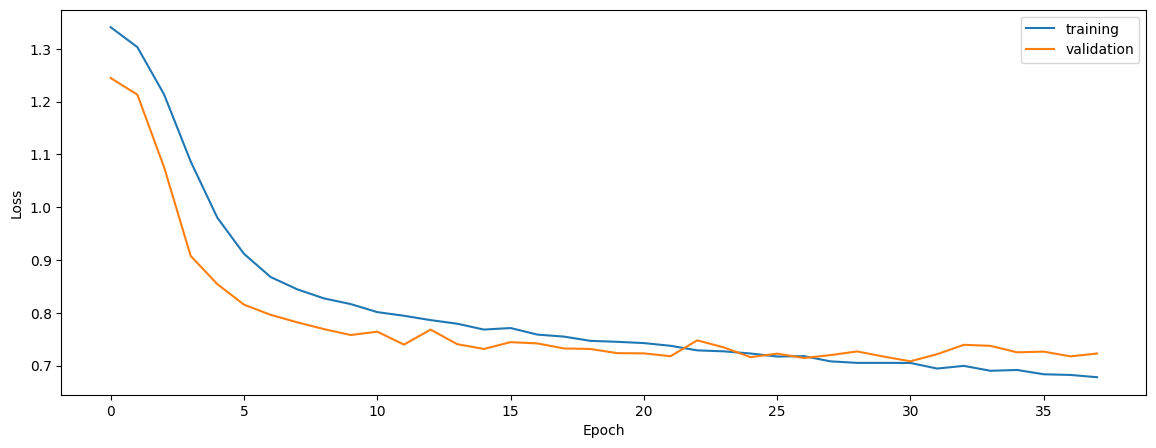

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.7230101148376302
0.716625430292599
0.7046158544566118


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.7230101148376302
0.716625430292599
0.7046158544566118


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7208470065372988
0.7123996039168226
0.7005874549933675


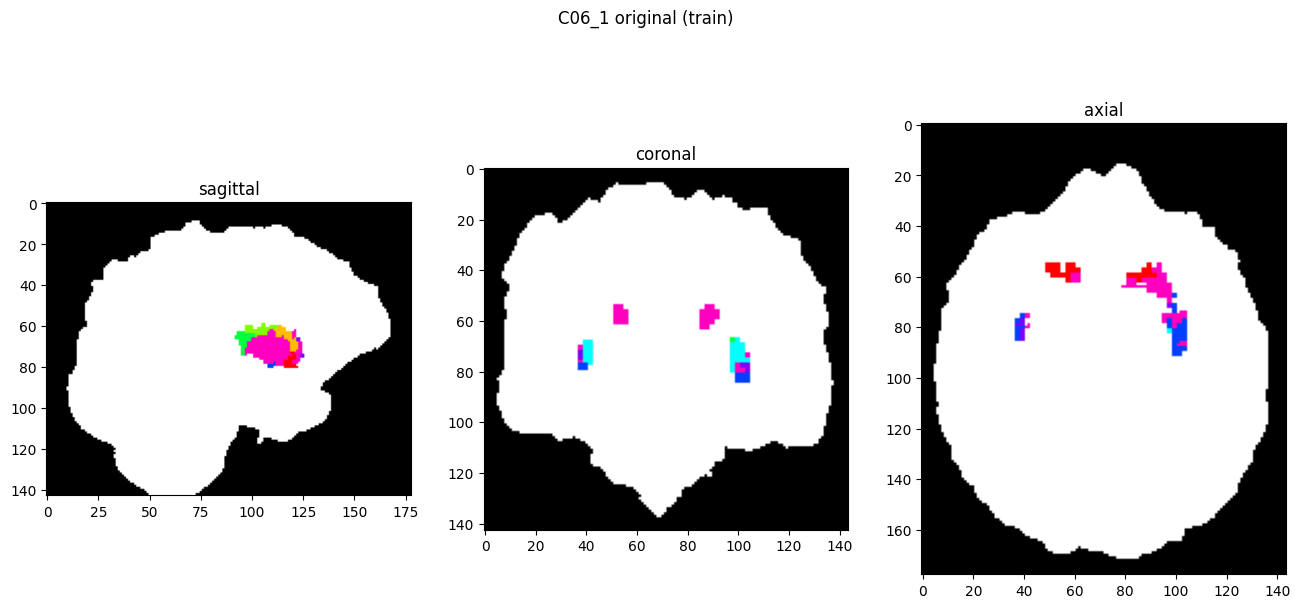

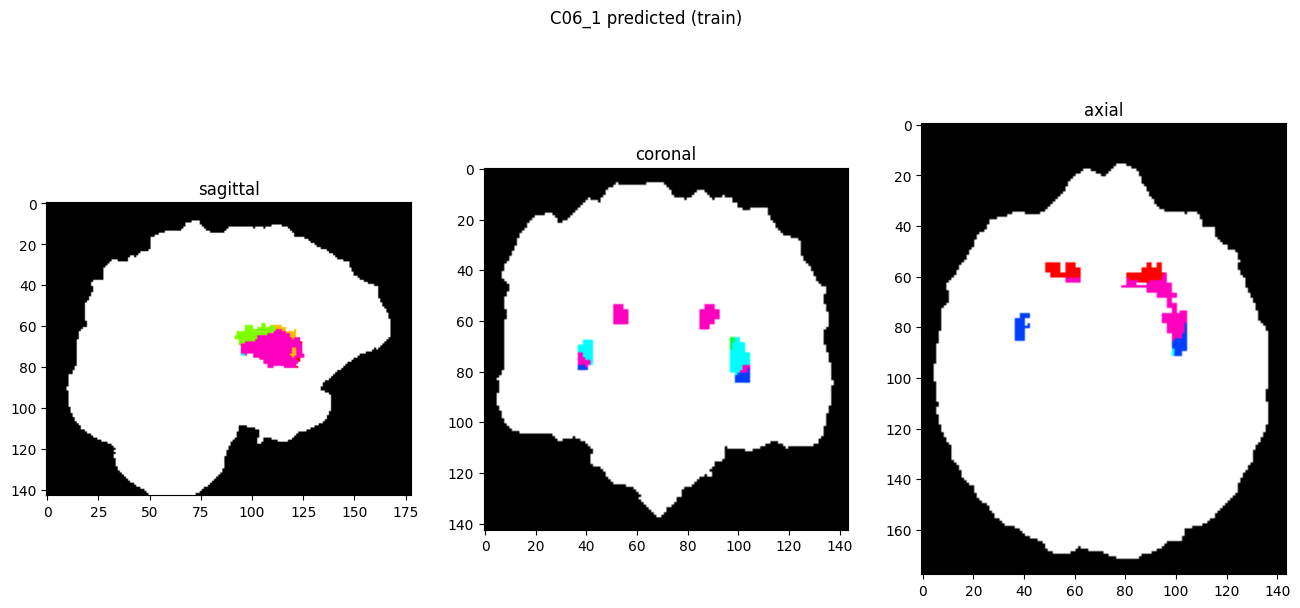

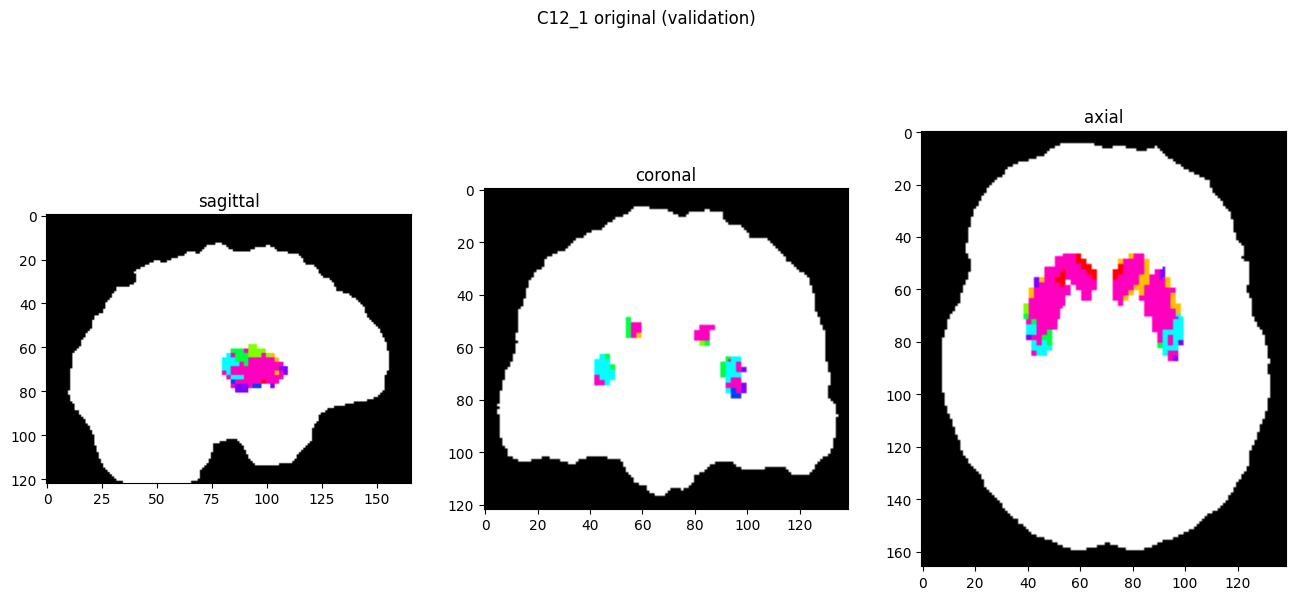

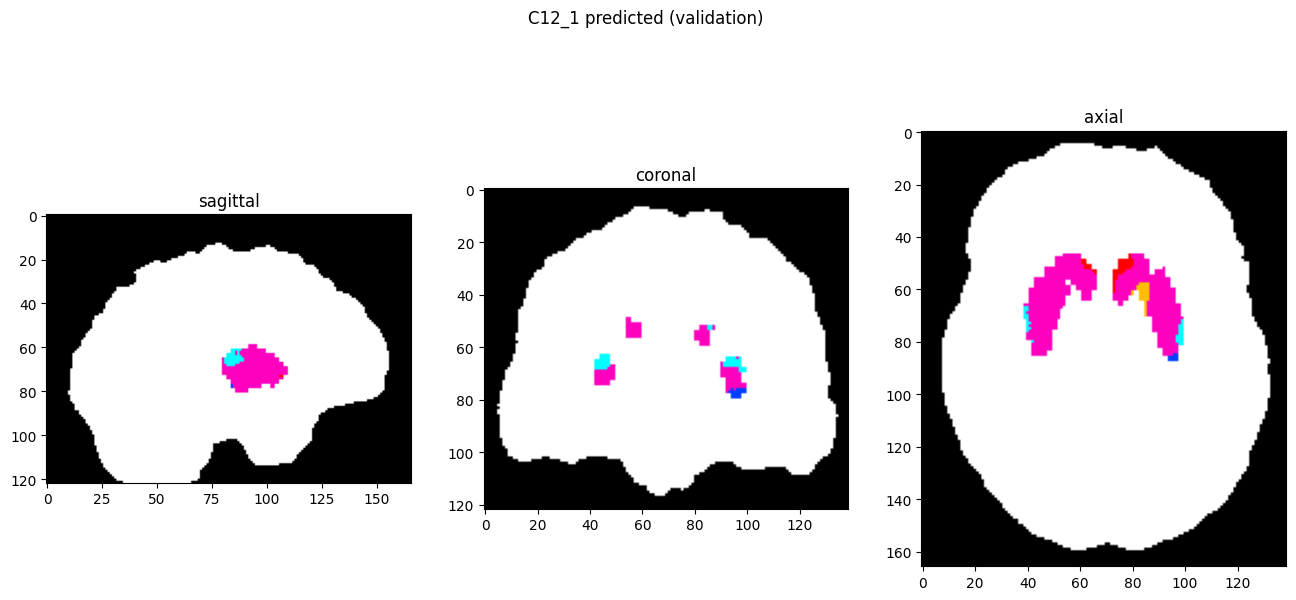

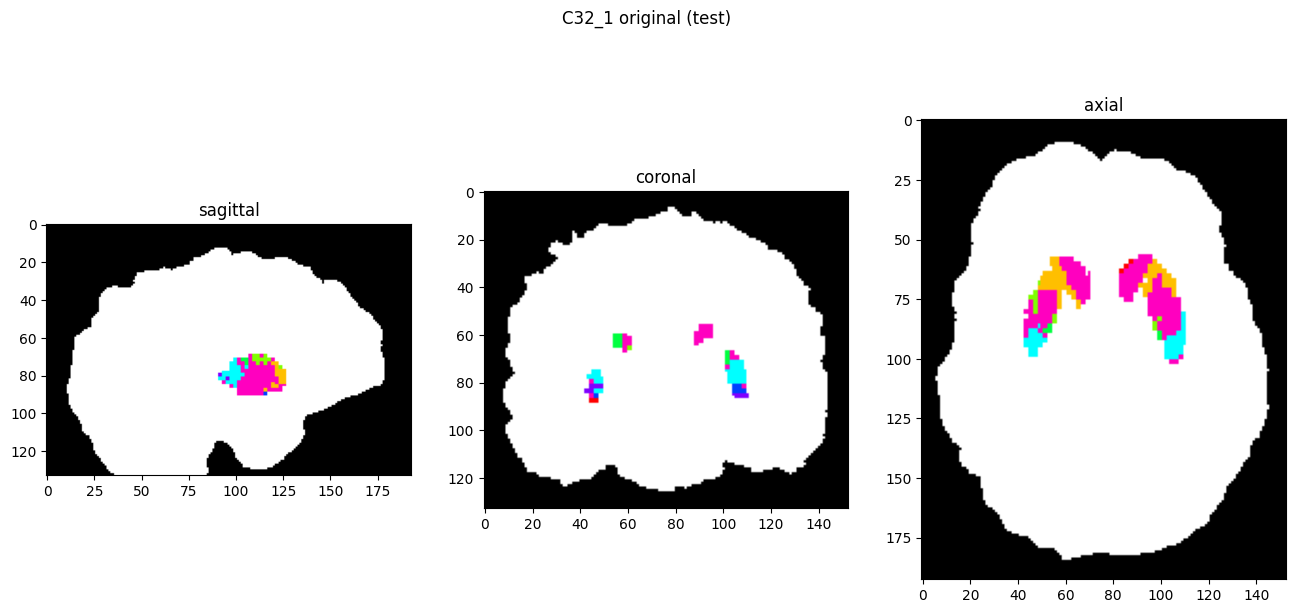

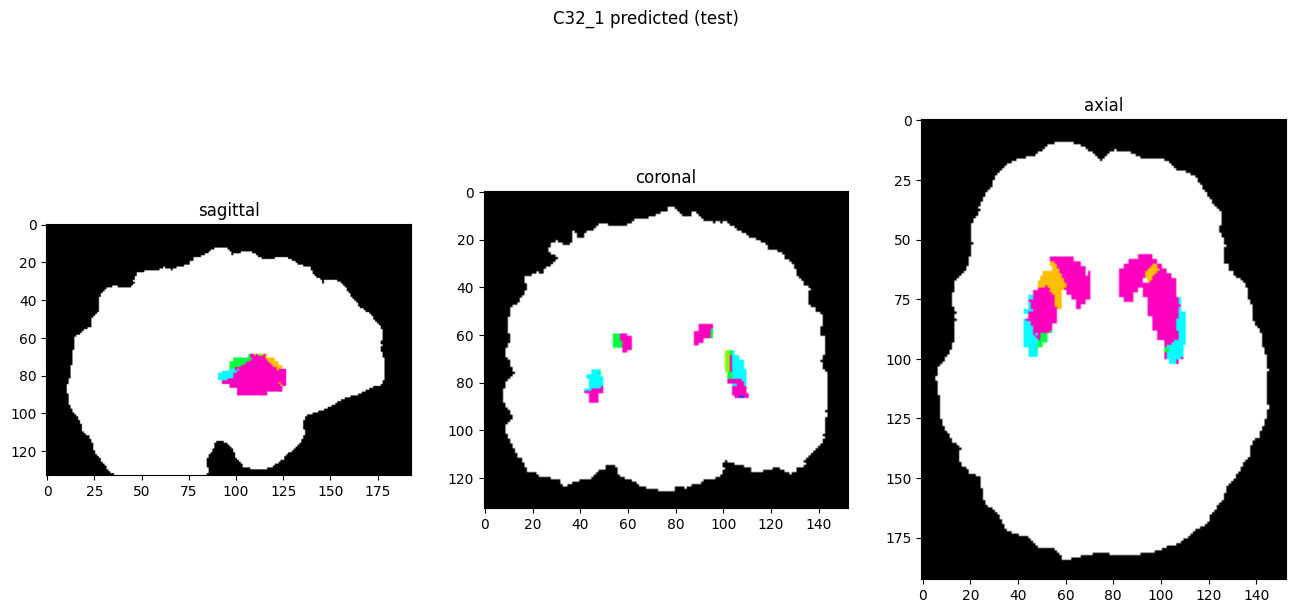

In [10]:
showResults(model, gen, threshold=0)